In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from datetime import datetime as dt

from wordcloud import WordCloud, STOPWORDS

# To visualize the geographical coordinates in the world map
import folium
from folium.plugins import HeatMap

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import tree

from sklearn.feature_selection import RFE

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#!pip install folium

In [3]:
# To display all the columns in the dataframe
pd.set_option('display.max_columns', None)

In [4]:
#Olist E-Commerce datasets
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
orderItems = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
orderReviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
productCategoryTranslation = pd.read_csv("product_category_name_translation.csv")

In [5]:
orders.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00

In [6]:
print('Number of Records:',orders.shape[0])
print('Number of Columns:',orders.shape[1])

Number of Records: 99441
Number of Columns: 8


In [7]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at)
orders['order_delivered_carrier_date'] = pd.to_datetime(orders.order_delivered_carrier_date)
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date)
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date)

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


### Treating missing values in orders dataframe

In [9]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [10]:
orders.order_id.nunique()

99441

In [11]:
orders.dropna()['order_status'].value_counts()

delivered    96455
canceled         6
Name: order_status, dtype: int64

In [12]:
orders[orders.isna().any(axis = 1)]['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered        23
created           5
approved          2
Name: order_status, dtype: int64

**Observations:**
1. Since our only target is to find customers who are still within our business, we can consider **only those customers whose orders were delivered to them**. 
2. For the records whose delivery date is missing, we could consider that those customer's orders were not delivered or under various stages of the process, for instance, shipped, cancelled, unavailable and so on. 
3. So we consider dropping such records where the datetime is missing. 
4. Null values are imputed only for the orders which are delivered and has missing values in any of the date time fields.

In [13]:
orders['purchased_approved'] = (orders.order_approved_at -orders.order_purchase_timestamp).dt.seconds
orders['approved_carrier'] = (orders.order_delivered_carrier_date - orders.order_approved_at).dt.days
orders['carrier_delivered'] = (orders.order_delivered_customer_date - orders.order_delivered_carrier_date).dt.days
orders['delivered_estimated'] = (orders.order_estimated_delivery_date - orders.order_delivered_customer_date).dt.days
orders['purchased_delivered'] = (orders.order_delivered_customer_date - orders.order_purchase_timestamp).dt.days
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  purchased_approved  approved_carrier  \
0                    2017-10-18               642.0               2.0   
1                    2018-08-13             24170.0               0.0   
2                    2018-09-04               994.0               0.0   
3                    2017-12-15              1073.0               3.0   
4                    2018-02-26              3710.0               0.0   

   carrier_delivered  delivered_estimated  purchased_delivered  
0                6.0                  7.0                  8.0  
1               12.0                  5.0                 13.0  
2                9.0                 17.0                  9.0  
3                9.0                 12.0                 13.0  
4                1.0                  9.0                  2.0

**Observations:**
1. New columns are created using the available datetime columns for easy analysis of the available data.
2. `Purchased_approved` represents the **seconds taken for an order to get approved** after the customer purchases it.
3. `approved_carrier` represents the **days taken for the order to go to the delivery carrier** after it being approved.
4. `carrier_delivered` represents the days **taken for the order to be delivered to the customer** from the date it reaches the delivery carrier.
5. `delivered_estimated` represents the **date difference between the estimated delivery date and the actual delivery date**. 
6. `purchased_delivered` represents the **days taken for the order to be delivered to the customer** from the date the customer made the purchase. 

In [14]:
orders.describe(include = np.number)

purchased_approved  approved_carrier  carrier_delivered  \
count        99281.000000      97644.000000       96475.000000   
mean         14198.031496          2.301749           8.878310   
std          23663.448160          3.560283           8.746088   
min              0.000000       -172.000000         -17.000000   
25%            755.000000          0.000000           4.000000   
50%           1169.000000          1.000000           7.000000   
75%          17166.000000          3.000000          12.000000   
max          86399.000000        125.000000         205.000000   

       delivered_estimated  purchased_delivered  
count         96476.000000         96476.000000  
mean             10.876881            12.094086  
std              10.183854             9.551746  
min            -189.000000             0.000000  
25%               6.000000             6.000000  
50%              11.000000            10.000000  
75%              16.000000            15.000000  
max             146.000000           209.000000

In [15]:
falsifiedData = orders[orders.approved_carrier < 0].index
orders.drop(index = falsifiedData, inplace = True)

In [16]:
falsifiedData = orders[orders.carrier_delivered < 0].index
orders.drop(index = falsifiedData, inplace = True)

In [17]:
canceledIndex = orders.dropna()[orders.order_status == 'canceled'].index
orders.drop(index = canceledIndex, inplace = True)

**Observations:**
1. Orders which have **carrier date prior to the date of order getting approved**, and orders which have **delivered date prior to the carrier date** are considered to be **falsified data**, as it could not be logically true.
2. Such records are **dropped**.
3. Also the records which are **cancelled and have no null values are also dropped** as we consider only the records which have a order status of delivered. 

In [18]:
orders.describe(include = np.number)

purchased_approved  approved_carrier  carrier_delivered  \
count        97893.000000      96256.000000       95096.000000   
mean         13950.420428          2.357224           8.910228   
std          23484.689925          3.503335           8.755221   
min              0.000000          0.000000           0.000000   
25%            752.000000          0.000000           4.000000   
50%           1153.000000          1.000000           7.000000   
75%          15785.000000          3.000000          12.000000   
max          86399.000000        125.000000         205.000000   

       delivered_estimated  purchased_delivered  
count         95097.000000         95097.000000  
mean             10.825568            12.153359  
std              10.199320             9.577379  
min            -189.000000             0.000000  
25%               6.000000             6.000000  
50%              11.000000            10.000000  
75%              16.000000            15.000000  
max             146.000000           209.000000

In [19]:
otherThanDelivered = orders[(orders.isna().any(axis = 1)) & (orders.order_status != 'delivered')].index
orders.drop(index = otherThanDelivered, inplace = True)

In [20]:
approvedAtNull = orders[orders.order_approved_at.isna()].index
orders.loc[approvedAtNull, 'order_approved_at'] = orders.loc[approvedAtNull, 'order_purchase_timestamp'] + pd.Timedelta(seconds = orders.purchased_approved.median())

In [21]:
deliveredCarrierNull = orders[orders.order_delivered_carrier_date.isna()].index
orders.loc[deliveredCarrierNull, 'order_delivered_carrier_date'] = orders.loc[deliveredCarrierNull, 'order_approved_at'] + pd.Timedelta(days = orders.approved_carrier.median())

In [22]:
deliveredCustomerNull = orders[orders.order_delivered_customer_date.isna()].index
orders.loc[deliveredCustomerNull, 'order_delivered_customer_date'] = orders.loc[deliveredCustomerNull, 'order_delivered_carrier_date'] + pd.Timedelta(days = orders.carrier_delivered.median())

**Observations:**
1. The **null values are dropped** which **do not have the order status as delivered**.
2. The null values in the `order_approved_at` field is imputed by adding the **median number of seconds it took for an order to get approved** after it is purchased, with the `order_purchase_timestamp`.
3. The null values in the `order_delivered_carrier_date` field is imputed by adding the **median number of days it took for an order to reach the carrier** after it is approved, with the `order_approved_at` timestamp.
4. The null values in the `order_delivered_customer_date` field is imputed by adding the **median number of days it took for an order to get delivered to the customer** after it reaches the carrier, with the `order_delivered_carrier_date` timestamp.

In [23]:
orders['purchased_approved'] = (orders.order_approved_at -orders.order_purchase_timestamp).dt.seconds
orders['approved_carrier'] = (orders.order_delivered_carrier_date - orders.order_approved_at).dt.days
orders['carrier_delivered'] = (orders.order_delivered_customer_date - orders.order_delivered_carrier_date).dt.days
orders['delivered_estimated'] = (orders.order_estimated_delivery_date - orders.order_delivered_customer_date).dt.days
orders['purchased_delivered'] = (orders.order_delivered_customer_date - orders.order_purchase_timestamp).dt.days
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  purchased_approved  approved_carrier  \
0                    2017-10-18                 642                 2   
1                    2018-08-13               24170                 0   
2                    2018-09-04                 994                 0   
3                    2017-12-15                1073                 3   
4                    2018-02-26                3710                 0   

   carrier_delivered  delivered_estimated  purchased_delivered  
0                  6                    7                    8  
1                 12                    5                   13  
2                  9                   17                    9  
3                  9                   12                   13  
4                  1                    9                    2

In [24]:
orders.describe(exclude = np.number)

order_id                       customer_id  \
count                              95105                             95105   
unique                             95105                             95105   
top     e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
freq                                   1                                 1   
first                                NaN                               NaN   
last                                 NaN                               NaN   

       order_status order_purchase_timestamp    order_approved_at  \
count         95105                    95105                95105   
unique            1                    94591                87320   
top       delivered      2018-06-01 13:39:44  2018-02-27 04:31:10   
freq          95105                        3                    9   
first           NaN      2016-09-15 12:16:38  2016-09-15 12:16:38   
last            NaN      2018-08-29 15:00:37  2018-08-29 15:10:26   

       order_delivered_carrier_date order_delivered_customer_date  \
count                         95105                         95105   
unique                        79235                         94311   
top             2018-05-09 15:48:00           2018-02-14 21:09:19   
freq                             47                             3   
first           2016-10-08 10:34:01           2016-10-11 13:46:32   
last            2018-09-11 19:48:28           2018-10-17 13:22:46   

       order_estimated_delivery_date  
count                          95105  
unique                           445  
top              2017-12-20 00:00:00  
freq                             506  
first            2016-10-04 00:00:00  
last             2018-10-25 00:00:00

**Observations:**
1. From the summary statistics, we could infer that the it took an average(median is considered as it is highly right skewed) of **1153 seconds** or **over half an hour hours** for the **order to get approved after the customer purchased it**. 
2. It took on an **average of 12 days** for the **order to get delivered to the customer from the date of purchase**. 
3. Since we considered orders which are only **delivered**, the `order_status` feature has only **one class**, i.e., **delivered**. 
4. The **first order was placed on 15/09/2016** and the **last order was placed on 29/08/2018**, from the available dataset.
5. On an average it took **11 days** for an **order to get delivered to the customer before the estimated date of delivery**. There are **many orders which were delivered late** than the estimated date of delivery.

### Distribution of purchased approved

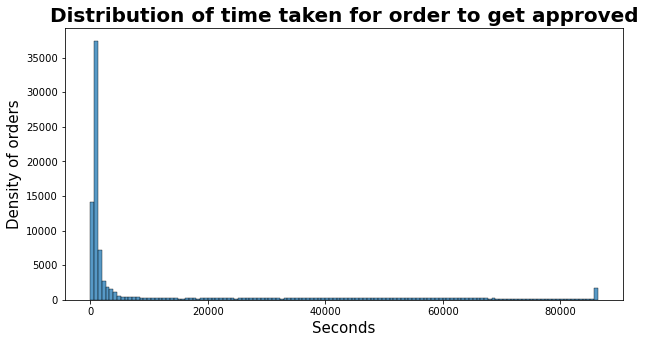

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(x='purchased_approved', data=orders)
plt.title('Distribution of time taken for order to get approved',fontweight='bold',fontsize=20)
plt.xlabel('Seconds',fontsize=15)
plt.ylabel('Density of orders',fontsize=15)
plt.show()

In [26]:
Q1 = np.quantile(orders.purchased_approved, 0.25)
Q3 = np.quantile(orders.purchased_approved, 0.75)
IQR = Q3 - Q1
purchasedApprovedDist = orders[~((orders.purchased_approved < Q1 - 1.5 * IQR) | (orders.purchased_approved > Q3 + 1.5 * IQR))]
purchasedApprovedDist.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  purchased_approved  approved_carrier  \
0                    2017-10-18                 642                 2   
1                    2018-08-13               24170                 0   
2                    2018-09-04                 994                 0   
3                    2017-12-15                1073                 3   
4                    2018-02-26                3710                 0   

   carrier_delivered  delivered_estimated  purchased_delivered  
0                  6                    7                    8  
1                 12                    5                   13  
2                  9                   17                    9  
3                  9                   12                   13  
4                  1                    9                    2

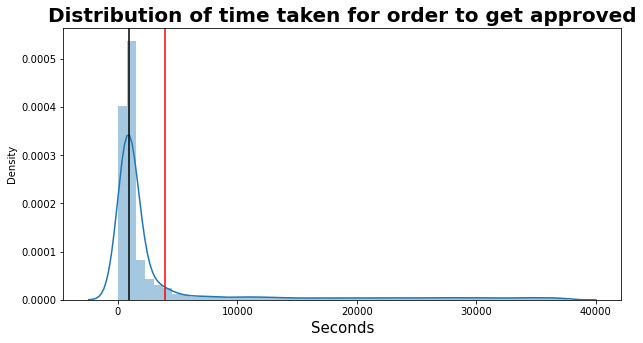

In [27]:
plt.figure(figsize=(10, 5))
sns.distplot(purchasedApprovedDist.purchased_approved)
plt.axvline(purchasedApprovedDist.purchased_approved.mean(), c = 'red')
plt.axvline(purchasedApprovedDist.purchased_approved.median(), c = 'black')
plt.xlabel('Seconds',color='black',fontsize=15)
plt.title('Distribution of time taken for order to get approved',color='black',fontsize=20,fontweight='bold')
plt.show()

In [28]:
purchasedApprovedDist.purchased_approved.describe()

count    78335.000000
mean      3944.854867
std       7741.478369
min          0.000000
25%        707.000000
50%        955.000000
75%       1940.000000
max      37563.000000
Name: purchased_approved, dtype: float64

**Observations:**
1. The approval time of orders within the interquartile range are spread mostly **between 0 and 5000 seconds**, which could be seen in the distribution plot.
2. The **average time taken for approval of the orders is 3844.85 seconds**. 

### Distribution of `purchased_delivered`

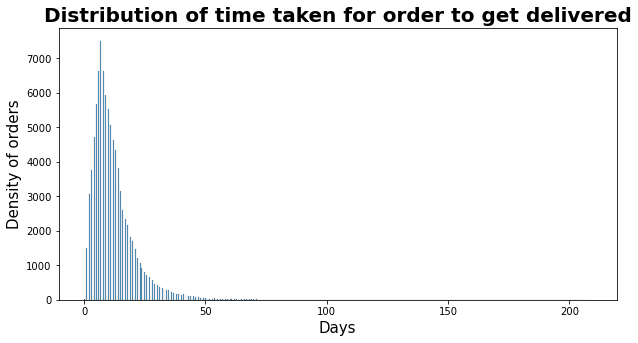

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(x='purchased_delivered', data=orders)
plt.title('Distribution of time taken for order to get delivered',fontweight='bold',fontsize=20)
plt.xlabel('Days',fontsize=15)
plt.ylabel('Density of orders',fontsize=15)
plt.show()

In [30]:
Q1 = np.quantile(orders.purchased_delivered, 0.25)
Q3 = np.quantile(orders.purchased_delivered, 0.75)
IQR = Q3 - Q1
purchasedDeliveredDist = orders[~((orders.purchased_delivered < Q1 - 1.5 * IQR) | (orders.purchased_delivered > Q3 + 1.5 * IQR))]
purchasedDeliveredDist.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  purchased_approved  approved_carrier  \
0                    2017-10-18                 642                 2   
1                    2018-08-13               24170                 0   
2                    2018-09-04                 994                 0   
3                    2017-12-15                1073                 3   
4                    2018-02-26                3710                 0   

   carrier_delivered  delivered_estimated  purchased_delivered  
0                  6                    7                    8  
1                 12                    5                   13  
2                  9                   17                    9  
3                  9                   12                   13  
4                  1                    9                    2

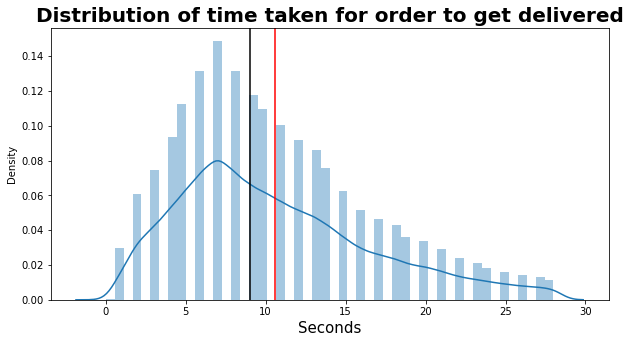

In [31]:
plt.figure(figsize=(10, 5))
sns.distplot(purchasedDeliveredDist.purchased_delivered)
plt.axvline(purchasedDeliveredDist.purchased_delivered.mean(), c = 'red')
plt.axvline(purchasedDeliveredDist.purchased_delivered.median(), c = 'black')
plt.xlabel('Seconds',color='black',fontsize=15)
plt.title('Distribution of time taken for order to get delivered',color='black',fontsize=20,fontweight='bold')
plt.show()

In [32]:
purchasedDeliveredDist.purchased_delivered.describe()

count    90096.000000
mean        10.602968
std          6.064321
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         28.000000
Name: purchased_delivered, dtype: float64

**Observations:**
1. The delivery days of orders within the interquartile range are spread mostly **between 0 and 28 days**, which could be seen in the distribution plot.
2. The **average days taken for delivery** of the orders is **11 days**. 

<a id = 'customers'></a>
## 4.2. Exploratory Data Analysis on Customers Dataframe

In [33]:
customers.head(3)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP

In [34]:
print('Number of records:',customers.shape[0])
print('Number of columns:',customers.shape[1])

Number of records: 99441
Number of columns: 5


In [35]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [36]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

**observations:**
1. There are 4 categorical variables: `customer_id`, `customer_unique_id`, `customer_city`, `customer_state`.
2. There is one Numeric variable: `customer_zip_code_prefix`, which should be converted to object datatype. 
3. There is **no presence of Null values** in the Customer dataset. 

In [37]:
customers['customer_zip_code_prefix'] = customers['customer_zip_code_prefix'].astype(object)

In [38]:
customers.describe(include='object')

customer_id                customer_unique_id  \
count                              99441                             99441   
unique                             99441                             96096   
top     06b8999e2fba1a1fbc88172c00ba8bc7  8d50f5eadf50201ccdcedfb9e2ac8455   
freq                                   1                                17   

        customer_zip_code_prefix customer_city customer_state  
count                      99441         99441          99441  
unique                     14994          4119             27  
top                        22790     sao paulo             SP  
freq                         142         15540          41746

**observations:**
1. The **total count of customer unique ID** is **99441**, while the **count of unique customer unique ID** is **96096**. We could observe that **almost all of the customers are one time visitors**, i.e., the **frequency of their visit would be 1**. 
2. The customers come from **14994 unique zip code locations**, and the **most number of customers**, **142**, belong to the zip code **22790**, which is **Rio de Janeiro**, **Brazil**.
3. The **top city** to which customers belong to is **Sao Paulo** and the **top state** to which our customers belong is **Sao Paulo**. 

### Visualization of top 10 cities 

In [39]:
customerCity = customers.customer_city.value_counts(normalize = True)[:10] * 100
print('The top 10 cities from which customers come are: \n', customerCity)

The top 10 cities from which customers come are: 
 sao paulo                15.627357
rio de janeiro            6.920687
belo horizonte            2.788588
brasilia                  2.142979
curitiba                  1.529550
campinas                  1.452117
porto alegre              1.386752
salvador                  1.251999
guarulhos                 1.195684
sao bernardo do campo     0.943273
Name: customer_city, dtype: float64


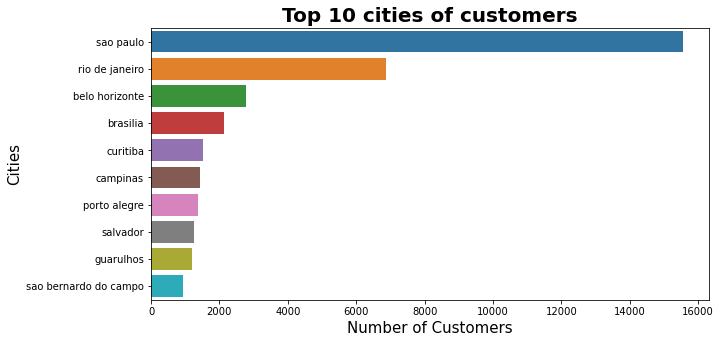

In [40]:
plt.figure(figsize=(10, 5))
sns.barplot(y = customers.customer_city.value_counts().index[:10], x = customers.customer_city.value_counts().values[:10])
plt.xlabel('Number of Customers',color='black',fontsize=15)
plt.ylabel('Cities',color='black',fontsize=15)
plt.title('Top 10 cities of customers',color='black',fontsize=20,fontweight='bold')
plt.show()

**observations:**
1. The **top city** to which the customers belong is **Sao Paulo**, which account to **15.62% of customers**. 
2. This is followed by **Rio De Janeiro**, which accounts to **6.92% of customers**.
3. The **least city** to which the customers belong to **among the top 10** is from **Sao Bernardo Do Campo**, which accounts to just **0.94%**.

### Visualization of top 10 States 

In [41]:
customerState = customers.customer_state.value_counts(normalize=True)[:10] * 100
print('The top 10 cities from which customers come are: \n', customerState)

The top 10 cities from which customers come are: 
 SP    41.980672
RJ    12.924247
MG    11.700405
RS     5.496727
PR     5.073360
SC     3.657445
BA     3.399000
DF     2.152030
ES     2.044428
GO     2.031355
Name: customer_state, dtype: float64


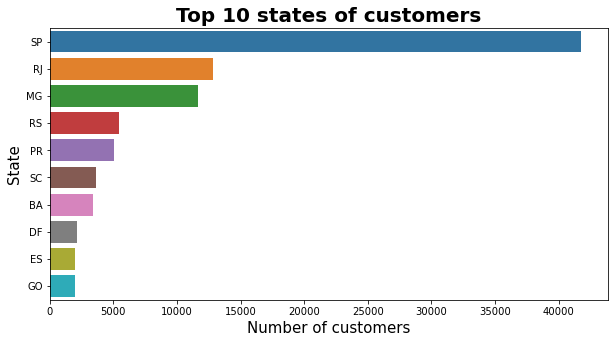

In [42]:
plt.figure(figsize=(10, 5))
sns.barplot(y = customers.customer_state.value_counts().index[:10], x = customers.customer_state.value_counts().values[:10])
plt.xlabel('Number of customers',color='black',fontsize=15)
plt.ylabel('State',color='black',fontsize=15)
plt.title('Top 10 states of customers',color='black',fontsize=20,fontweight='bold')
plt.show()

**observations:**
1. The **top state** to which customers belong is **Sao Paulo**, from where **41.98%** of customers come from. 
2. This is followed by **Rio De Janeiro**, which accounts to **12.92% of customers**. 

### Visualization of Geolocation of Customers

In [43]:
incorrectLocation = geolocation[(geolocation.geolocation_lat > 10) & (geolocation.geolocation_lng < -18)]
incorrectLocation

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
538512                        29654        29.409252       -98.484121   
538557                        29654        21.657547      -101.466766   
585242                        35179        25.995203       -98.078544   
585260                        35179        25.995245       -98.078533   

              geolocation_city geolocation_state  
538512  santo antônio do canaã                ES  
538557  santo antonio do canaa                ES  
585242      santana do paraíso                MG  
585260      santana do paraiso                MG

In [44]:
geolocation.drop(index = [538512, 538557, 585242, 585260], inplace = True)

**Observations:**
1. There are some records in the geolocation data for which the **geolocation latitude and longitude are pointing to locations in the sea**, which will lead to **inappropriate visualization of the geolocation**, when aggregation is applied to the fields. 
2. So such records are alone **dropped** from the data. 
3. Those records include **geolocation zipcodes 29654** and **35179**, for which the latitude and longitude values for certain records are incorrectly given.  
4. **Latitude greater than 10 degrees** and **longitude lesser than -18 degrees** point to the sea. 

In [45]:
geolocationMean = geolocation.groupby('geolocation_zip_code_prefix', as_index = False).agg({'geolocation_lat'  : 'max',
                                                                                            'geolocation_lng'  : 'max'})
geolocationMean.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                         1001       -23.549292       -46.633559
1                         1002       -23.544641       -46.633180
2                         1003       -23.548901       -46.634862
3                         1004       -23.549181       -46.634057
4                         1005       -23.548758       -46.634768

**Observation:**
1. Since there are many geographical coordinates given for a single geolocation zipcode, we consider the **maximum value of the coordinate for a particular zipcode**. 

In [46]:
customerDensity = customers.merge(geolocationMean, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix', how = 'left')[['customer_unique_id', 'customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]
customerDensity.head()

customer_unique_id customer_zip_code_prefix  geolocation_lat  \
0  861eff4711a542e4b93843c6dd7febb0                    14409       -20.468849   
1  290c77bc529b7ac935b93aa66c333dc3                     9790       -23.659702   
2  060e732b5b29e8181a18229c7b0b2b5e                     1151       -23.527788   
3  259dac757896d24d7702b9acbbff3f3c                     8775       -23.493944   
4  345ecd01c38d18a9036ed96c73b8d066                    13056       -22.961980   

   geolocation_lng  
0       -47.382173  
1       -46.530264  
2       -46.652997  
3       -46.172406  
4       -47.125767

In [47]:
customerDensity.dropna(inplace = True)

**observations:**
1. The **customer zip codes are mapped with the geolocation zip code's latitude and longidute**, so as to visualise from which region our customers are more densly concentrated. 
2. There are some **zip codes for which the latitude and longitude values are not available** in the data, so we **drop such records** for visualization. 

In [48]:
# create a map centered on your coordinates
m = folium.Map(location = customerDensity[['geolocation_lat', 'geolocation_lng']].values.tolist()[0], zoom_start = 13)

# create a list of coordinates
coordinates = customerDensity[['geolocation_lat', 'geolocation_lng']].values.tolist()

# create a heatmap layer with the list of coordinates
heat_layer = HeatMap(coordinates)

# add the heatmap layer to the map
heat_layer.add_to(m)

# display the map
m

**observation:**
1. From the heatmap, we could see that **most of the customers are based out of South America**, while **some are from the Europe**. 

<a id = 'orderItems'> </a>
## 4.3. Exploratory Data Analysis On OrderItems dataframe

In [49]:
orderItems.head(3)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93  
2  2018-01-18 14:48:30  199.0          17.87

In [50]:
orderItems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [51]:
orderItems['shipping_limit_date'] = pd.to_datetime(orderItems.shipping_limit_date)

In [52]:
orderItems.isna().sum() / len(orderItems) * 100

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

In [53]:
orderItems.describe(exclude = np.number)

order_id                        product_id  \
count                             112650                            112650   
unique                             98666                             32951   
top     8272b63d03f5f79c56e9e4120aec44ef  aca2eb7d00ea1a7b8ebd4e68314663af   
freq                                  21                               527   
first                                NaN                               NaN   
last                                 NaN                               NaN   

                               seller_id  shipping_limit_date  
count                             112650               112650  
unique                              3095                93318  
top     6560211a19b47992c3666cc44a7e94c0  2017-07-21 18:25:23  
freq                                2033                   21  
first                                NaN  2016-09-19 00:15:34  
last                                 NaN  2020-04-09 22:35:08

In [54]:
orderItems.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

**Observations:**
1. The order items dataframe consist of all the orders placed by the customers and the details of the products in that order. 
2. There are **98666 unique orders** placed with the business and the order with **most number of items** is **8272b63d03f5f79c56e9e4120aec44ef**, which has **21 items in a single order**. 
3. **32951 unique products** were ordered during the taken time period and the **most ordered product** is **aca2eb7d00ea1a7b8ebd4e68314663af**, which was ordered **527 times**. During the further stages of analysis, the product will be analysed mapping the ID with the products dataframe. 
4. Similarly there are **3095 unique sellers** for the product and the **seller who sells most of the product** is **6560211a19b47992c3666cc44a7e94c0**. This data is also masked but we can combine this with geolocation and find which state or city the sellers belong to and do further analysis. 
5. The **average price of the products** ordered is **120.65 Brazilian Reals**. The price of the products ordered is **highly right skewed**, as the **costliest product ordered** is priced at **6735 Brazilian Reals**. 
6. Similarly the **freight value** of the order **on an average for each order** is **19.99 Brazilian Reals**, and the **expensive freight value** is **409.68 Brazilian Reals**. The particular orders whose freight values are higher will be studied later in the course of analysis. 

### Visualization of Top 10 orders

In [55]:
topOrders = orderItems.groupby('order_id', as_index = False).agg({'price'         : 'sum',
                                                                  'freight_value' : 'sum'})
topOrders['total_price'] = topOrders.price + topOrders.freight_value
top10Orders = topOrders.sort_values(by = 'total_price', ascending = False)[:10]
top10Orders

order_id    price  freight_value  total_price
1455   03caa2c082116e1d31e67e9ae3700499  13440.0         224.08     13664.08
44467  736e1922ae60d0d6a89247b851902527   7160.0         114.88      7274.88
3130   0812eb902a67711a1cb742b3cdaa65ae   6735.0         194.31      6929.31
98298  fefacc66af859508bf1a7934eab1e97f   6729.0         193.21      6922.21
94439  f5136e38d1a14a4dbd87dff67da82701   6499.0         227.66      6726.66
17114  2cc9089445046817a7539d90805e6e5a   5934.6         146.94      6081.54
65046  a96610ab360d42a2e5335a3998b4718a   4799.0         151.34      4950.34
69531  b4c4b76c642808cbe472a32b86cddc95   4599.9         209.54      4809.44
9868   199af31afc78c699f0dbf71fb178d4d4   4690.0          74.34      4764.34
54353  8dbc85d1447242f3b127dda390d56e19   4590.0          91.78      4681.78

### Visualization of top sellers of the orders placed by customers

In [56]:
topSellers = orderItems.seller_id.value_counts()
topSellers.head()

6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
Name: seller_id, dtype: int64

In [57]:
topSellers = pd.DataFrame({'seller_id'     : topSellers.index,
                           'instances'     : topSellers.values})
topSellers.head()

seller_id  instances
0  6560211a19b47992c3666cc44a7e94c0       2033
1  4a3ca9315b744ce9f8e9374361493884       1987
2  1f50f920176fa81dab994f9023523100       1931
3  cc419e0650a3c5ba77189a1882b7556a       1775
4  da8622b14eb17ae2831f4ac5b9dab84a       1551

In [58]:
topSellersOfOrders = topSellers.merge(sellers, on = 'seller_id').merge(geolocationMean, left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix').drop(columns = ['geolocation_zip_code_prefix'], axis = 1).sort_values('instances', ascending = False)
topSellersOfOrders.head()

seller_id  instances  seller_zip_code_prefix  \
0   6560211a19b47992c3666cc44a7e94c0       2033                    5849   
2   4a3ca9315b744ce9f8e9374361493884       1987                   14940   
51  1f50f920176fa81dab994f9023523100       1931                   15025   
55  cc419e0650a3c5ba77189a1882b7556a       1775                    9015   
58  da8622b14eb17ae2831f4ac5b9dab84a       1551                   13405   

              seller_city seller_state  geolocation_lat  geolocation_lng  
0               sao paulo           SP       -23.649432       -46.753466  
2                ibitinga           SP       -21.734663       -48.809349  
51  sao jose do rio preto           SP       -20.793902       -49.376768  
55            santo andre           SP       -23.653394       -46.513267  
58             piracicaba           SP       -22.692313       -47.653256

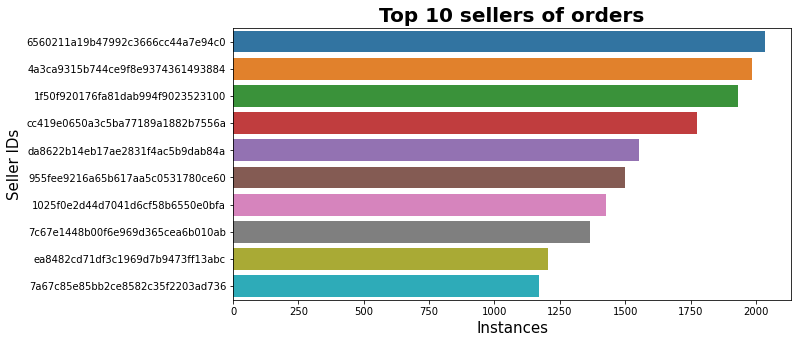

In [59]:
plt.figure(figsize=(10, 5))
sns.barplot(x = topSellers.instances[:10], y = topSellers.seller_id[:10])
plt.xlabel('Instances',color='black',fontsize=15)
plt.ylabel('Seller IDs',color='black',fontsize=15)
plt.title('Top 10 sellers of orders',color='black',fontsize=20,fontweight='bold')
plt.show()

**Observations:**
1. Since the **seller IDs are masked**, we could not make out from what the seller ID means. 
2. So we use the location and city of the sellers to draw inferences. 

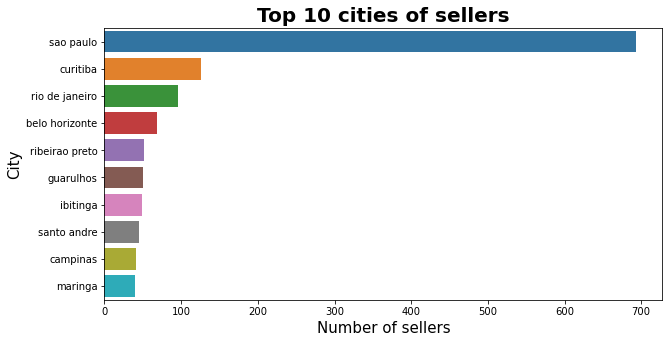

In [60]:
plt.figure(figsize=(10, 5))
sns.barplot(y = topSellersOfOrders.seller_city.value_counts().index[:10], x = topSellersOfOrders.seller_city.value_counts().values[:10])
plt.xlabel('Number of sellers',color='black',fontsize=15)
plt.ylabel('City',color='black',fontsize=15)
plt.title('Top 10 cities of sellers',color='black',fontsize=20,fontweight='bold')
plt.show()

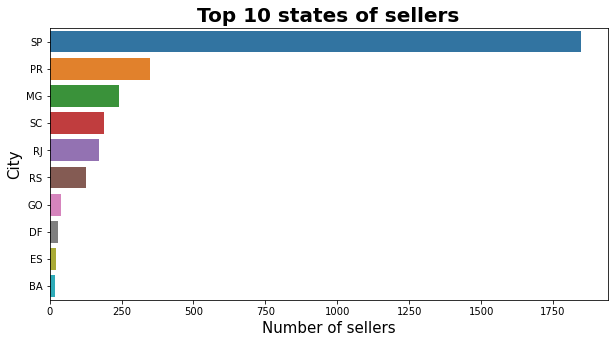

In [61]:
plt.figure(figsize=(10, 5))
sns.barplot(y = topSellersOfOrders.seller_state.value_counts().index[:10], x = topSellersOfOrders.seller_state.value_counts().values[:10])
plt.xlabel('Number of sellers',color='black',fontsize=15)
plt.ylabel('City',color='black',fontsize=15)
plt.title('Top 10 states of sellers',color='black',fontsize=20,fontweight='bold')
plt.show()

**Observations:**
1. The **sellers of orders** are mostly from the **city** of **Sao Paulo**, followed by **Curitiba** and **Rio De Janeiro**. 
2. The sellers of orders are mostly from the **state** of **Sao Paulo**. 
3. This is obvious as most of the customers are from the same state and city of Sao Paulo. 

In [62]:
# create a map centered on your coordinates
m = folium.Map(location = topSellersOfOrders[['geolocation_lat', 'geolocation_lng']].values.tolist()[0], zoom_start = 13)

# create a list of coordinates
coordinates = topSellersOfOrders[['geolocation_lat', 'geolocation_lng']].values.tolist()

# create a heatmap layer with the list of coordinates
heat_layer = HeatMap(coordinates)

# add the heatmap layer to the map
heat_layer.add_to(m)

# display the map
m

**Observation:**
1. From the heatmap of the sellers based on their latitudes and longitudes, we could infer the **concentration of sellers are only in South America**. They carter to all of our customers spread in Europe and South America.  

### Distribution of price of the orders

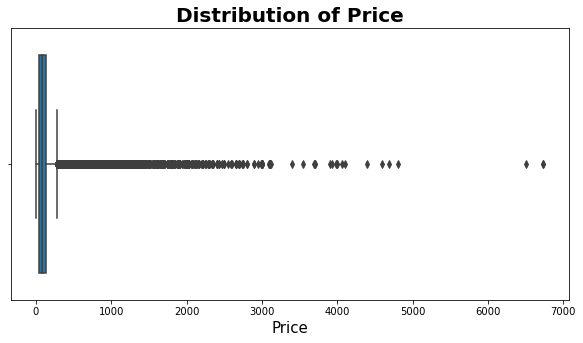

In [63]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='price', data=orderItems)
plt.xlabel('Price',color='black',fontsize=15)
plt.title('Distribution of Price',color='black',fontsize=20,fontweight='bold')
plt.show()

**Observations:**
1. From the boxplot we could infer that the **price of the products** ordered is highly **right skewed**.
2. So as to view the spread of the price more clearly we will ignore the outliers and then find the distribution. 

In [64]:
Q1 = np.quantile(orderItems.price, 0.25)
Q3 = np.quantile(orderItems.price, 0.75)
IQR = Q3 - Q1
priceDistribution = orderItems[~((orderItems.price < Q1 - 1.5 * IQR) | (orderItems.price > Q3 + 1.5 * IQR))]
priceDistribution.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99          12.79  
4 2017-02-13 13:57:51  199.90          18.14

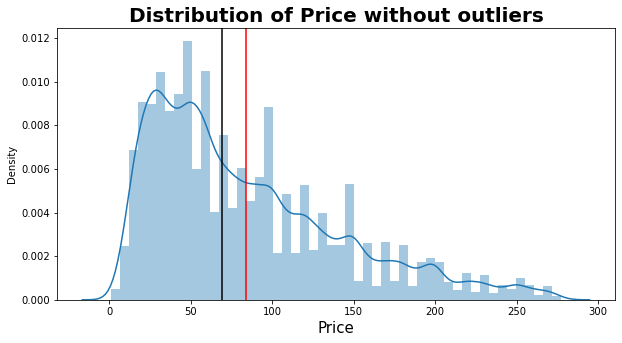

In [65]:
plt.figure(figsize=(10, 5))
sns.distplot(priceDistribution.price)
plt.axvline(priceDistribution.price.mean(), c = 'red')
plt.axvline(priceDistribution.price.median(), c = 'black')
plt.xlabel('Price',color='black',fontsize=15)
plt.title('Distribution of Price without outliers',color='black',fontsize=20,fontweight='bold')
plt.show()

In [66]:
priceDistribution.price.describe()

count    104223.000000
mean         83.974668
std          58.580002
min           0.850000
25%          38.500000
50%          69.000000
75%         118.990000
max         277.300000
Name: price, dtype: float64

**Observations:**
1. The price of the products within the interquartile range are spread mostly between 0 and 100 Brazilian Reals, which could be seen in the distribution plot. 
2. The **average price of the products** is **83.97 Brazilian Reals**. 

### Visualization of freight value of the orders

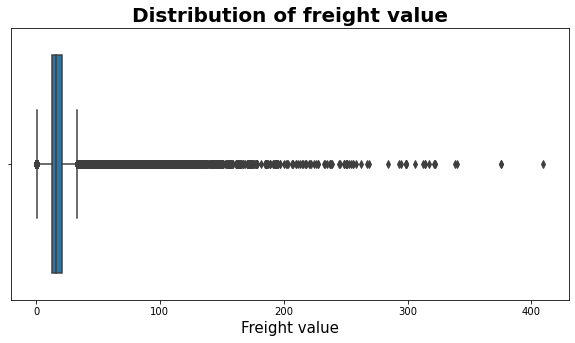

In [67]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='freight_value', data=orderItems)
plt.xlabel('Freight value',color='black',fontsize=15)
plt.title('Distribution of freight value',color='black',fontsize=20,fontweight='bold')
plt.show()

**Observations:**
1. From the boxplot we could infer that the **freight value of the product** ordered is highly **right skewed**.
2. So as to view the spread of the freight value more clearly we will ignore the outliers and then find the distribution. 

In [68]:
Q1 = np.quantile(orderItems.freight_value, 0.25)
Q3 = np.quantile(orderItems.freight_value, 0.75)
IQR = Q3 - Q1
freightValueDistribution = orderItems[~((orderItems.freight_value < Q1 - 1.5 * IQR) | (orderItems.freight_value > Q3 + 1.5 * IQR))]
freightValueDistribution.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0 2017-09-19 09:45:35   58.90          13.29  
1 2017-05-03 11:05:13  239.90          19.93  
2 2018-01-18 14:48:30  199.00          17.87  
3 2018-08-15 10:10:18   12.99          12.79  
4 2017-02-13 13:57:51  199.90          18.14

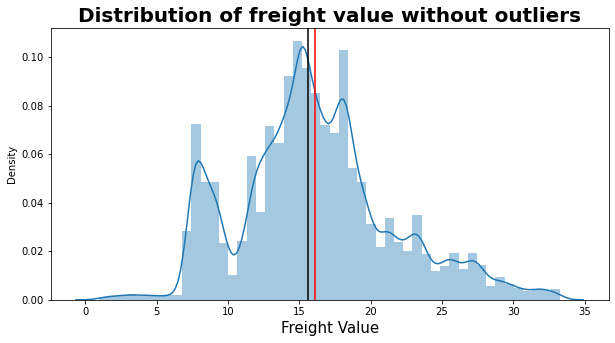

In [69]:
plt.figure(figsize=(10, 5))
sns.distplot(freightValueDistribution.freight_value)
plt.axvline(freightValueDistribution.freight_value.mean(), c = 'red')
plt.axvline(freightValueDistribution.freight_value.median(), c = 'black')
plt.xlabel('Freight Value',color='black',fontsize=15)
plt.title('Distribution of freight value without outliers',color='black',fontsize=20,fontweight='bold')
plt.show()

In [70]:
freightValueDistribution.freight_value.describe()

count    100516.000000
mean         16.125685
std           5.468564
min           0.980000
25%          12.760000
50%          15.620000
75%          18.800000
max          33.250000
Name: freight_value, dtype: float64

**Observations:**
1. The freight values of the products within the interquartile range are spread mostly between 5 and 25, which could be seen in the distribution plot. We could infer that such orders were within the continent of South America.
2. The **average freight value** of the products is **16.12 Brazilian Reals**. 

<a id="payments"></a>
## 4.4. Exploratory Data Analysis on Payments DataFrame

In [71]:
payments.head(3)

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71

In [72]:
print('Number of Records:',payments.shape[0])
print('Number of Columns:',payments.shape[1])

Number of Records: 103886
Number of Columns: 5


In [73]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [74]:
payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [75]:
payments.describe(include = np.number)

payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000

In [76]:
payments.describe(exclude = np.number)

order_id payment_type
count                             103886       103886
unique                             99440            5
top     fa65dad1b0e818e3ccc5cb0e39231352  credit_card
freq                                  29        76795

**Observations:**
1. There is **no presence of Null values** in the payments dataframe.
2. Most of the payements were made through **credit cards**. 
3. The **average number of payment installments** was **1**, since it is highly right skewed, the mean is not considered. **24 was the maximum number of payment installments** for an order. 
4. The payment value of the orders is also highly right skewed. The **average payment value** is **154.1 Brazilian Reals**.

### Visulaization Of Different Payment types

In [77]:
payments.payment_type.value_counts(normalize = True) * 100

credit_card    73.922376
boleto         19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: payment_type, dtype: float64

**Observations:**
1. From the count plot, we cound clearly see that **credit card** accounts for **73.9% of payments**, which is the **most preferred payment type**, followed by **boleto**, **voucher** and **debit card**.
2. There is imbalance present in the data as most of the payment types are of credit cards. 

### Distribution of Number of Payment Installments

In [78]:
payments.payment_installments.value_counts(normalize = True)[:10] * 100 

1     50.580444
2     11.948675
3     10.069692
4      6.832489
10     5.128699
5      5.043028
8      4.108350
6      3.773367
7      1.565177
9      0.619910
Name: payment_installments, dtype: float64

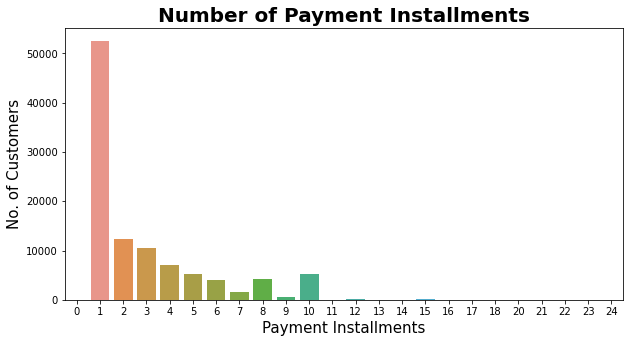

In [79]:
plt.figure(figsize=(10, 5))
sns.countplot(x='payment_installments',data=payments)
plt.title('Number of Payment Installments',fontweight='bold',fontsize=20)
plt.xlabel('Payment Installments',fontsize=15,color='black')
plt.ylabel('No. of Customers',fontsize=15,color='black')
plt.show()

**Observations:**
1. Most customers prefered to pay for the order in a **single installment**. However, customers also opted for more than one installment, the number is not insignificant.
2. For further analysis, we could **convert the installments to an object datatype** as we could not consider it as a numeric column.

### Distribution of the payment value of the orders

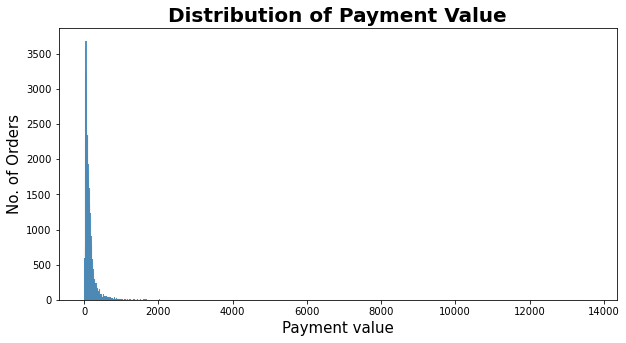

In [80]:
plt.figure(figsize=(10, 5))
sns.histplot(x='payment_value', data=payments)
plt.title('Distribution of Payment Value',fontweight='bold',fontsize=20)
plt.xlabel('Payment value',fontsize=15)
plt.ylabel('No. of Orders',fontsize=15)
plt.show()

In [81]:
Q1 = np.quantile(payments.payment_value, 0.25)
Q3 = np.quantile(payments.payment_value, 0.75)
IQR = Q3 - Q1
paymentValueDistribution = payments[~((payments.payment_value < Q1 - 1.5 * IQR) | (payments.payment_value > Q3 + 1.5 * IQR))]
paymentValueDistribution.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

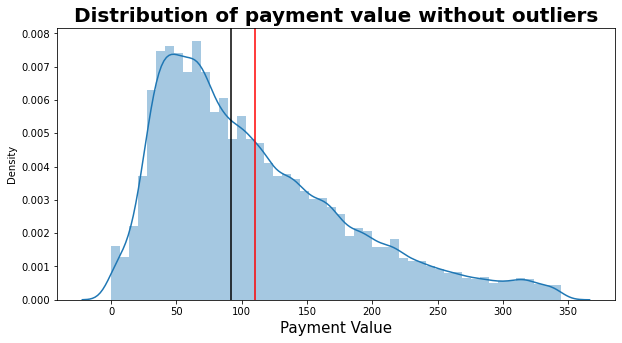

In [82]:
plt.figure(figsize=(10, 5))
sns.distplot(paymentValueDistribution.payment_value)
plt.axvline(paymentValueDistribution.payment_value.mean(), c = 'red')
plt.axvline(paymentValueDistribution.payment_value.median(), c = 'black')
plt.xlabel('Payment Value',color='black',fontsize=15)
plt.title('Distribution of payment value without outliers',color='black',fontsize=20,fontweight='bold')
plt.show()

In [83]:
paymentValueDistribution.payment_value.describe()

count    95905.000000
mean       110.062133
std         72.785054
min          0.000000
25%         54.000000
50%         92.200000
75%        150.580000
max        344.340000
Name: payment_value, dtype: float64

**Observations:**
1. The payment values of the orders within the interquartile range are spread mostly between 0 and 200, which could be seen in the distribution plot.
2. The **average payment value** for the orders is **110.06 Brazilian Reals**. 

<a id="reviews"></a>
## 4.5. Exploratory DataAnalysis On Order reviews dataframe

In [84]:
orderReviews.head(3)

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   
2             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  2018-03-10 00:00:00     2018-03-11 03:05:13  
2  2018-02-17 00:00:00     2018-02-18 14:36:24

In [85]:
print('Number of records:',orderReviews.shape[0])
print('number of columns:',orderReviews.shape[1])

Number of records: 99224
number of columns: 7


In [86]:
orderReviews['review_answer_timestamp'] = pd.to_datetime(orderReviews.review_answer_timestamp)
orderReviews['review_creation_date'] = pd.to_datetime(orderReviews.review_creation_date)

In [87]:
orderReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


In [88]:
orderReviews.isna().sum()[orderReviews.isna().sum() > 0] / len(orderReviews) * 100

review_comment_title      88.341530
review_comment_message    58.702532
dtype: float64

**Observations:**
1. There are **88.34%** of `review_comment_title` and **58.7%** of `review_comment_message` as **null values**.
2. We are **dropping** the null values.

In [89]:
orderReviews.dropna(inplace = True)

In [90]:
reviewScore = orderReviews.review_score.value_counts(normalize = True) * 100
reviewScore

5    55.107226
1    18.182742
4    14.564488
3     7.490599
2     4.654945
Name: review_score, dtype: float64

**Observations:**
1. From the count plot of review score, we could clearly see that for about **57.77%** of orders, the **review score is 5**, which is the maximum review score. 
2. From this we could clearly see that customers were mostly satisfied by the products and the business. 

### Comparision of review scores of on-time and late deliveries

In [91]:
reviewScoreAnalysis = orderReviews[['order_id', 'review_score']].merge(orders[['order_id', 'purchased_approved', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']], on = 'order_id')
reviewScoreAnalysis.head()

order_id  review_score  purchased_approved  \
0  b9bf720beb4ab3728760088589c62129             4                 525   
1  e51478e7e277a83743b6f9991dbfa3fb             5                 883   
2  37e7875cdce5a9e5b3a692971f370151             4                3042   
3  e029f708df3cc108b3264558771605c6             5                1221   
4  e2e6ee1ed2d7f2f36b05d234983bd7a0             5               74123   

   approved_carrier  carrier_delivered  delivered_estimated  \
0                 0                  6                   15   
1                 0                  3                   15   
2                 3                 16                    7   
3                 4                  7                   16   
4                 2                  7                    7   

   purchased_delivered  
0                    7  
1                    3  
2                   19  
3                   11  
4                   11

In [92]:
ontimeDelivery_review = reviewScoreAnalysis[reviewScoreAnalysis.delivered_estimated > 0][['review_score', 'purchased_approved', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']].mean()
lateDelivery_review = reviewScoreAnalysis[reviewScoreAnalysis.delivered_estimated < 0][['review_score', 'purchased_approved', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']].mean()
comparision_review = pd.DataFrame([ontimeDelivery_review, lateDelivery_review]).T
comparision_review.rename(columns = {0 : 'on time delivery', 1 : 'late delivery'}, inplace = True)
comparision_review

on time delivery  late delivery
review_score                 4.040577       2.577267
purchased_approved       14923.547788   18692.007663
approved_carrier             1.810071       4.840358
carrier_delivered            6.335004      19.363985
delivered_estimated         13.512100      -7.748404
purchased_delivered          8.939012      25.163474

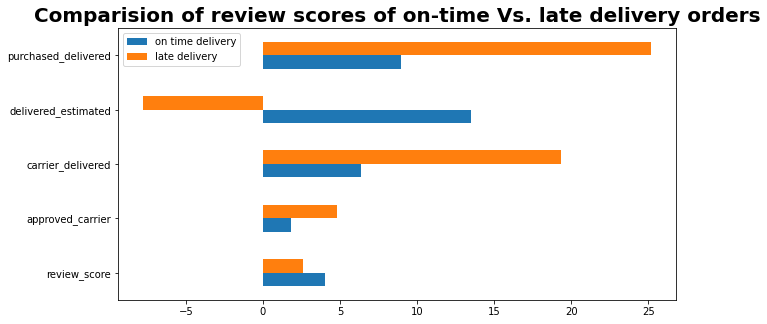

In [93]:
comparision_review.drop('purchased_approved').plot(kind = 'barh', figsize = (10, 5))
plt.title('Comparision of review scores of on-time Vs. late delivery orders',fontweight='bold',fontsize=20)
plt.show()

**Observations:**
1. The **review scores of late deliveries was 2.5** while for **on-time deliveries it was 4** on an average. 
2. It took **25 days on an average** for the **orders to get delivered** to the customers for **late delivery orders**, while it took just **9 days** for **on-time delivery orders**.
3. On an average, orders were delivered **14 days before the estimated date of delivery** for **on-time delivered orders**. 
4. It also took **extra hour** for the **orders to get approved** for orders which were **delivered late**. 

### Top comments by the customers

In [94]:
topComments = orderReviews.review_comment_title.value_counts()[:10]
print('The top 20 comments by the customer are:',topComments,sep='\n')

The top 20 comments by the customer are:
Recomendo          354
recomendo          270
Bom                228
super recomendo    213
Excelente          203
Ótimo              193
Muito bom          192
Super recomendo    184
Ótimo              149
Otimo              133
Name: review_comment_title, dtype: int64


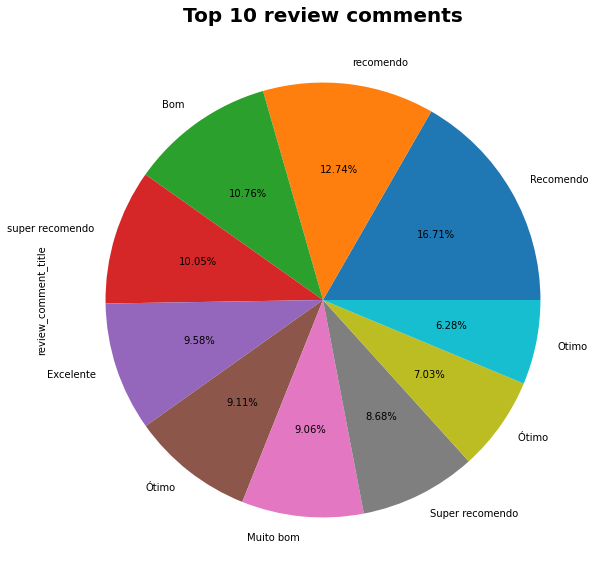

In [95]:
topComments.plot(kind="pie",autopct="%2.2f%%",figsize=(10, 10))
plt.title('Top 10 review comments',fontweight='bold',fontsize=20)
plt.show()

**Observations:**
1. The most occuring comment is **Recomendo**, **Bom**, **super recomendo** and **excelente**.
2. **Recommedo** is about **11.93%**.

In [96]:
def partition(x):
    if x < 3:
        return 0
    return 1

orderReviewsAnalysis = orderReviews.copy()
orderReviewsAnalysis['review_score']=orderReviewsAnalysis['review_score'].map(lambda cw : partition(cw) ) 
    
# checking the review score now
orderReviewsAnalysis.review_score.value_counts()

1    7592
0    2247
Name: review_score, dtype: int64

Total Positive Reviews : 7592 , ( 77.16231324321578 %)
Total Negative Reviews : 2247 , ( 22.837686756784226 %)




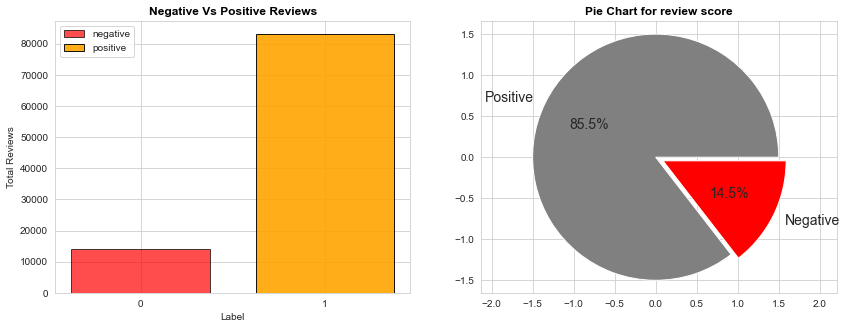

In [97]:
#counting the review score with 1 and 0
y_value_counts = orderReviewsAnalysis.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total Reviews')
plt.xlabel('Label')
plt.title('Negative Vs Positive Reviews',color='black',fontweight='bold')
plt.xticks([10,10.20],['0','1'])
#creating bar plots
plt.bar(10,14112, color = 'red', width = 0.15,alpha=0.7,label='negative',edgecolor='black')
plt.bar(10.20,83143,color = 'orange', width = 0.15,alpha=0.9,label='positive',edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
labels = ['Positive','Negative']
sizes = [83143,14112]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
color={'Red','grey'}
plt.pie(sizes,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart for review score',color='black',fontweight='bold')
plt.show()

**Observations:**
1. Review scores **below 3** are considered as **negative reviews** and **above 3** are said to be **positive reviews**. 
2. We can observe from the above plots **85.5%** of the total reviews are **positive** and only **14.5%** reviews are **negative**. 

<a id="revenueGenerated"></a>
## 4.6. Revenue Generated

### Year-wise number of orders

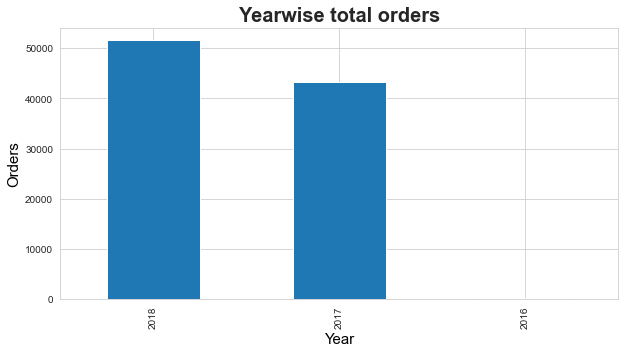

In [98]:
plt.figure(figsize=(10, 5))
pd.to_datetime(orders.order_purchase_timestamp).dt.year.value_counts().plot(kind='bar')
plt.title('Yearwise total orders',fontweight='bold',fontsize=20)
plt.xlabel('Year',fontsize=15,color='black')
plt.ylabel('Orders',fontsize=15,color='black')
plt.show()

**Observation:**
1. The year of **2018** is when **most orders were placed**. 

### Month-wise revenue for the years 2017 and 2018

In [99]:
def is_late_delivery(Days):
    if Days < 0:
        return 1
    else:
        return 0

In [100]:
def is_ontime_delivery(Days):
    if Days > 0:
        return 1
    else:
        return 0

In [101]:
year2016 = orders[orders.order_purchase_timestamp.dt.year == 2016].merge(orderItems, on = 'order_id')
year2016['Month'] = year2016.order_purchase_timestamp.dt.month
year2016['isLateDelivery'] = year2016['delivered_estimated'].apply(is_late_delivery)
year2016['isOnTimeDelivery'] = year2016['delivered_estimated'].apply(is_ontime_delivery)
revenue2016 = year2016.groupby('Month').agg({'order_id' : 'nunique', 'price' : 'sum', 'freight_value' : 'sum', 'purchased_approved' : 'mean', 'carrier_delivered' : 'mean', 'delivered_estimated' : 'mean', 'purchased_delivered' : 'mean', 'isLateDelivery' : 'sum', 'isOnTimeDelivery' : 'sum'})
revenue2016['total_revenue'] = revenue2016.price + revenue2016.freight_value
revenue2016['lateDeliveryRate'] = revenue2016['isLateDelivery'] / (revenue2016['isLateDelivery'] + revenue2016['isOnTimeDelivery'])
revenue2016

order_id     price  freight_value  purchased_approved  \
Month                                                          
9             1    134.97           8.49            0.000000   
10          261  39738.17        6093.65        31555.386364   
12            1     10.90           8.72          890.000000   

       carrier_delivered  delivered_estimated  purchased_delivered  \
Month                                                                
9                1.00000           -37.000000            54.000000   
10               5.62013            35.798701            19.198052   
12               1.00000            21.000000             4.000000   

       isLateDelivery  isOnTimeDelivery  total_revenue  lateDeliveryRate  
Month                                                                     
9                   3                 0         143.46          1.000000  
10                  3               304       45831.82          0.009772  
12                  0                 1          19.62          0.000000

In [102]:
year2017 = orders[orders.order_purchase_timestamp.dt.year == 2017].merge(orderItems, on = 'order_id')
year2017['Month'] = year2017.order_purchase_timestamp.dt.month
year2017['isLateDelivery'] = year2017['delivered_estimated'].apply(is_late_delivery)
year2017['isOnTimeDelivery'] = year2017['delivered_estimated'].apply(is_ontime_delivery)
revenue2017 = year2017.groupby('Month').agg({'order_id' : 'nunique', 'price' : 'sum', 'freight_value' : 'sum', 'purchased_approved' : 'mean', 'carrier_delivered' : 'mean', 'delivered_estimated' : 'mean', 'purchased_delivered' : 'mean', 'isLateDelivery' : 'sum', 'isOnTimeDelivery' : 'sum'})
revenue2017['total_revenue'] = revenue2017.price + revenue2017.freight_value
revenue2017['lateDeliveryRate'] = revenue2017['isLateDelivery'] / (revenue2017['isLateDelivery'] + revenue2017['isOnTimeDelivery'])
revenue2017

order_id      price  freight_value  purchased_approved  \
Month                                                           
1           749  111609.71       15666.01        14288.871570   
2          1650  233716.91       36938.42        11139.714517   
3          2545  359109.85       55107.03         6177.327807   
4          2279  338839.16       49652.13        13151.595351   
5          3531  488010.45       77258.11        13569.175069   
6          3130  421310.97       68013.90        13466.575079   
7          3841  478598.50       83898.01        13519.357536   
8          4190  553928.41       90976.11        12527.191103   
9          4137  604764.74       93400.02        12330.243381   
10         4478  648247.65      102869.36        13479.104910   
11         7288  987510.37      165582.29        14508.177956   
12         5508  725558.51      116955.07        14256.016502   

       carrier_delivered  delivered_estimated  purchased_delivered  \
Month                                                                
1               8.701427            26.734358            12.072448   
2               9.002698            18.165677            12.634107   
3               9.364421            11.439724            12.427634   
4              10.679669            12.108747            14.328211   
5               7.937296            12.395535            10.899172   
6               8.357450            11.719782            11.451622   
7               7.850893            11.586578            11.021530   
8               7.345447            12.344612            10.482038   
9               8.105910            10.435077            11.404787   
10              7.766206            10.992712            11.264097   
11             10.384470             7.281449            14.579301   
12             10.947581            12.104352            14.781427   

       isLateDelivery  isOnTimeDelivery  total_revenue  lateDeliveryRate  
Month                                                                     
1                  26               885      127275.72          0.028540  
2                  62              1787      270655.33          0.033532  
3                 163              2717      414216.88          0.056597  
4                 191              2322      388491.29          0.076005  
5                 151              3810      565268.56          0.038122  
6                 130              3332      489324.87          0.037551  
7                 160              4175      562496.51          0.036909  
8                 151              4603      644904.52          0.031763  
9                 242              4414      698164.76          0.051976  
10                264              4898      751117.01          0.051143  
11               1172              7138     1153092.66          0.141035  
12                504              5619      842513.58          0.082313

In [103]:
year2018 = orders[orders.order_purchase_timestamp.dt.year == 2018].merge(orderItems, on = 'order_id')
year2018['Month'] = year2018.order_purchase_timestamp.dt.month
year2018['isLateDelivery'] = year2018['delivered_estimated'].apply(is_late_delivery)
year2018['isOnTimeDelivery'] = year2018['delivered_estimated'].apply(is_ontime_delivery)
revenue2018 = year2018.groupby('Month').agg({'order_id' : 'nunique', 'price' : 'sum', 'freight_value' : 'sum', 'purchased_approved' : 'mean', 'carrier_delivered' : 'mean', 'delivered_estimated' : 'mean', 'purchased_delivered' : 'mean', 'isLateDelivery' : 'sum', 'isOnTimeDelivery' : 'sum'})
revenue2018['total_revenue'] = revenue2018.price + revenue2018.freight_value
revenue2018['lateDeliveryRate'] = revenue2018['isLateDelivery'] / (revenue2018['isLateDelivery'] + revenue2018['isOnTimeDelivery'])
revenue2018

order_id      price  freight_value  purchased_approved  \
Month                                                           
1          7045  922192.60      152670.38        15841.367146   
2          6543  824207.87      139455.59        14366.830757   
3          7001  953311.25      167215.46        13605.120274   
4          6409  923081.83      150642.10        17088.306233   
5          6681  966547.76      149446.94        14948.900233   
6          5976  840156.23      152896.15        12594.163708   
7          5596  797173.38      146234.44        17851.038383   
8          6265  828540.84      144748.47        14523.856960   

       carrier_delivered  delivered_estimated  purchased_delivered  \
Month                                                                
1               9.854841            12.010618            13.656090   
2              12.700693             7.361940            16.481210   
3              12.128759             5.799750            15.604741   
4               8.035366            11.935772            11.014770   
5               8.282220            11.342262            10.878106   
6               6.197031            18.297293             8.667055   
7               5.668773            10.189228             8.623914   
8               4.817653             7.402441             7.262097   

       isLateDelivery  isOnTimeDelivery  total_revenue  lateDeliveryRate  
Month                                                                     
1                 525              7405     1074862.98          0.066204  
2                1183              6173      963663.46          0.160821  
3                1641              6190     1120526.71          0.209552  
4                 368              6948     1073723.93          0.050301  
5                 618              6980     1115994.70          0.081337  
6                  93              6771      993052.38          0.013549  
7                 294              5949      943407.82          0.047093  
8                 735              5908      973289.31          0.110643

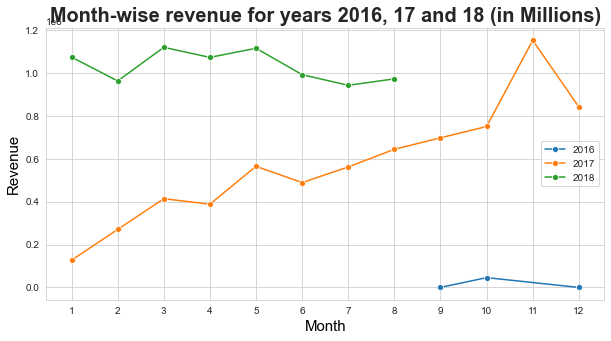

In [104]:
plt.figure(figsize=(10, 5))
sns.lineplot(y = revenue2016['total_revenue'], x = revenue2016.index, marker = 'o', label = '2016')
sns.lineplot(y = revenue2017['total_revenue'], x = revenue2017.index, marker = 'o', label = '2017')
sns.lineplot(y = revenue2018['total_revenue'], x = revenue2018.index, marker = 'o', label = '2018')
plt.title('Month-wise revenue for years 2016, 17 and 18 (in Millions)',fontweight='bold',fontsize=20)
plt.xlabel('Month',fontsize=15,color='black')
plt.ylabel('Revenue',fontsize=15,color='black')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.legend()
plt.show()

**Observations:**
1. There are **not many records available for the year 2016**, so the revenue is also less. Therefore we consider only the records from the year 2017 to the available records upto August of 2018 for our analysis. 
2. From the available data, it is clearly evident that the revenue grew constantly all throughout the year 2017, starting from **127K Brazilian Real** all the way upto **1.15M Brazilian Real** during the month of **November 2017**. 
3. There was a dip in the revenue of around **310K Brazilian Real** in the month of **December 2017**. 
4. The year **2018 saw a constant revenue flow** which was in the range of **966K - 1.13M Brazilian Real**.
5. The revenue is in **correspondance with the number of orders placed**.

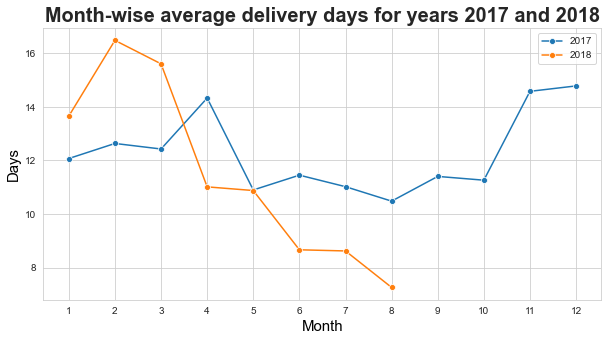

In [105]:
plt.figure(figsize=(10, 5))
sns.lineplot(y = revenue2017['purchased_delivered'], x = revenue2017.index, marker = 'o', label = '2017')
sns.lineplot(y = revenue2018['purchased_delivered'], x = revenue2018.index, marker = 'o', label = '2018')
plt.title('Month-wise average delivery days for years 2017 and 2018',fontweight='bold',fontsize=20)
plt.xlabel('Month',fontsize=15,color='black')
plt.ylabel('Days',fontsize=15,color='black')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.legend()
plt.show()

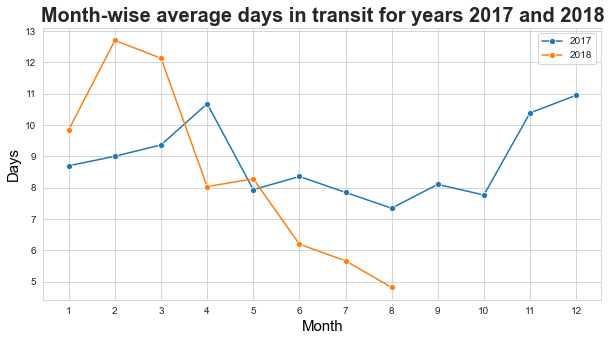

In [106]:
plt.figure(figsize=(10, 5))
sns.lineplot(y = revenue2017['carrier_delivered'], x = revenue2017.index, marker = 'o', label = '2017')
sns.lineplot(y = revenue2018['carrier_delivered'], x = revenue2018.index, marker = 'o', label = '2018')
plt.title('Month-wise average days in transit for years 2017 and 2018',fontweight='bold',fontsize=20)
plt.xlabel('Month',fontsize=15,color='black')
plt.ylabel('Days',fontsize=15,color='black')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.legend()
plt.show()

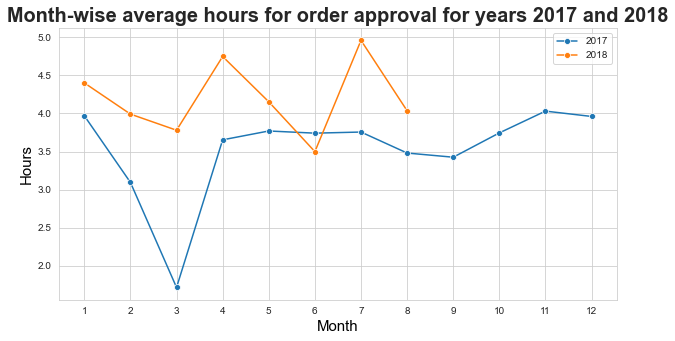

In [107]:
plt.figure(figsize=(10, 5))
sns.lineplot(y = revenue2017['purchased_approved']/3600, x = revenue2017.index, marker = 'o', label = '2017')
sns.lineplot(y = revenue2018['purchased_approved']/3600, x = revenue2018.index, marker = 'o', label = '2018')
plt.title('Month-wise average hours for order approval for years 2017 and 2018',fontweight='bold',fontsize=20)
plt.xlabel('Month',fontsize=15,color='black')
plt.ylabel('Hours',fontsize=15,color='black')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.legend()
plt.show()

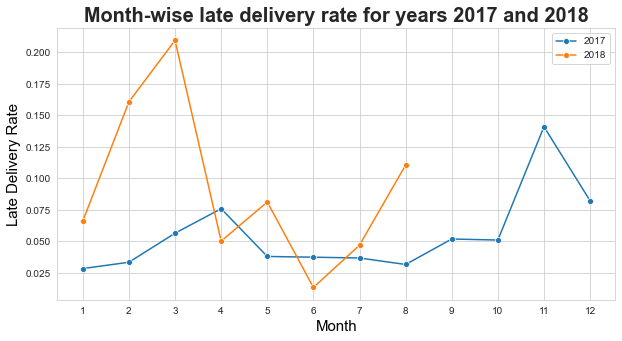

In [108]:
plt.figure(figsize=(10, 5))
sns.lineplot(y = revenue2017['lateDeliveryRate'], x = revenue2017.index, marker = 'o', label = '2017')
sns.lineplot(y = revenue2018['lateDeliveryRate'], x = revenue2018.index, marker = 'o', label = '2018')
plt.title('Month-wise late delivery rate for years 2017 and 2018',fontweight='bold',fontsize=20)
plt.xlabel('Month',fontsize=15,color='black')
plt.ylabel('Late Delivery Rate',fontsize=15,color='black')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.legend()
plt.show()

**Observations:**
1. The data for the **year 2016 was very less** so we do **not consider** it for interpretation. 
2. The rise in revenue is in **accordance with the number of days** it took on an average for the **orders to get delivered** to the customers and also the **number of days** it took on an average **while the orders were in transit**.
3. This clearly indicates that the **business thrives only based on the less number of days it takes for the order to get delivered**. 
4. **Optimising the delivery days** would actually help in **increasing the revenue** and help sustain the business over years. 
5. The graphs clearly indicate that on periods **when there were huge numbers of orders**, the **average delivery time was also comparatively high**, which indicates that proper measures should be undertaken to carter fast delivery of products. 
6. The only viable method would be to **invest in transit and delivery partners**. 
7. Hours taken for the order to get approved does not have any impact on the business.

**Business Recommendations:**
1. **Increase cross-docking centres** for **first mile delivery**.
2. Introduce **product traceability**.
3. **Optimize the inventory management** for **fast approval of orders**.
4. **Know target customers** and **increase their satisfaction**.
5. Invest in **delivery partners** and **transit**. 

### Quarter-wise revenue

In [109]:
quarters2017 = pd.DataFrame(columns = ['total_revenue'])
quarters2018 = pd.DataFrame(columns = ['total_revenue'])
quarters2017.loc['Q1'] = [sum(revenue2017.total_revenue[:3])]
quarters2017.loc['Q2'] = [sum(revenue2017.total_revenue[3:6])]
quarters2017.loc['Q3'] = [sum(revenue2017.total_revenue[6:9])]
quarters2017.loc['Q4'] = [sum(revenue2017.total_revenue[9:])]
quarters2018.loc['Q1'] = [sum(revenue2018.total_revenue[:3])]
quarters2018.loc['Q2'] = [sum(revenue2018.total_revenue[3:6])]

In [110]:
quarters2017

total_revenue
Q1      812147.93
Q2     1443084.72
Q3     1905565.79
Q4     2746723.25

In [111]:
quarters2018

total_revenue
Q1     3159053.15
Q2     3182771.01

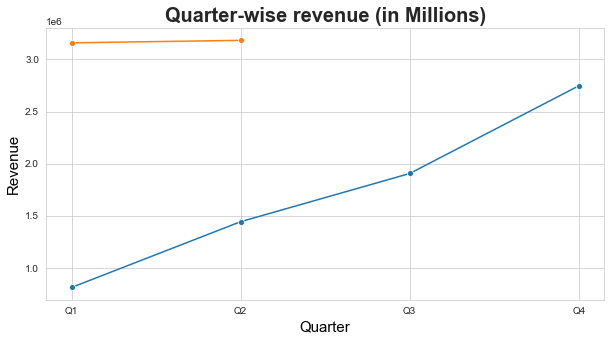

In [112]:
plt.figure(figsize=(10, 5))
sns.lineplot(y = quarters2017['total_revenue'], x = quarters2017.index, marker = 'o')
sns.lineplot(y = quarters2018['total_revenue'], x = quarters2018.index, marker = 'o')
plt.title('Quarter-wise revenue (in Millions)',fontweight='bold',fontsize=20)
plt.xlabel('Quarter',fontsize=15,color='black')
plt.ylabel('Revenue',fontsize=15,color='black')
plt.show()

**Observations:**
1. We only see the records for the quarters Q1 of FY2017 to Q2 of FY2018 as they are the available records. 
2. The revenue was on the rise during this period, which stood at a high of **3.27M Brazilian Real** at **Q2 of FY2018**. 
3. Comparing the first and second quarters of financial years 2017 and 2018 respectively, we find that the **revenue increased very drastically**, which says the business is on the uprising. 

<a id="blackFriday"></a>
## 4.7. Black Friday Sale

### Analysis of sales during November 2017

**Observations:**
1. The sales during the **month of November and December 2017** is alone studied extensively because it was the month that **saw the highest revenue generated**, and which was followed by a sudden dip in revenue the very next month. 
2. It is also in connection with the **Black Friday Sale** which was on **Friday, 24th of November 2017**. 

In [113]:
november2017 = year2017[year2017.order_purchase_timestamp.dt.month == 11]
november2017['Date'] = november2017.order_purchase_timestamp.dt.day
november2017.head()

order_id                       customer_id  \
1   949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
10  85ce859fd6dc634de8d2f1e290444043  059f7fc5719c7da6cbafe370971a8d70   
17  6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   
26  68873cf91053cd11e6b49a766db5af1a  4632eb5a8f175f6fe020520ae0c678f3   
27  8f06cc6465925031568537b815f1198d  9916715c2ab6ee1710c9c32f0a534ad2   

   order_status order_purchase_timestamp   order_approved_at  \
1     delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
10    delivered      2017-11-21 00:03:41 2017-11-21 00:14:22   
17    delivered      2017-11-24 21:27:48 2017-11-25 00:21:09   
26    delivered      2017-11-30 22:02:15 2017-12-02 02:51:18   
27    delivered      2017-11-15 11:31:41 2017-11-15 11:46:42   

   order_delivered_carrier_date order_delivered_customer_date  \
1           2017-11-22 13:39:59           2017-12-02 00:28:42   
10          2017-11-23 21:32:26           2017-11-27 18:28:00   
17          2017-12-13 21:14:05           2017-12-28 18:59:23   
26          2017-12-04 22:07:01           2017-12-05 20:28:40   
27          2017-11-16 22:03:00           2017-11-22 22:41:07   

   order_estimated_delivery_date  purchased_approved  approved_carrier  \
1                     2017-12-15                1073                 3   
10                    2017-12-11                 641                 2   
17                    2017-12-21               10401                18   
26                    2017-12-18               17343                 2   
27                    2017-12-05                 901                 1   

    carrier_delivered  delivered_estimated  purchased_delivered  \
1                   9                   12                   13   
10                  3                   13                    6   
17                 14                   -8                   33   
26                  0                   12                    4   
27                  6                   12                    7   

    order_item_id                        product_id  \
1               1  d0b61bfb1de832b15ba9d266ca96e5b0   
10              1  cce679660c66e6fbd5c8091dfd29e9cd   
17              1  be021417a6acb56b9b50d3fd2714baa8   
26              1  15a9e834e89eab39d973492882c658d6   
27              1  12087840651e83b48206b82c213b76fd   

                           seller_id shipping_limit_date  price  \
1   66922902710d126a0e7d26b0e3805106 2017-11-23 19:45:59   45.0   
10  d2374cbcbb3ca4ab1086534108cc3ab7 2017-11-29 00:14:22   17.9   
17  f5f46307a4d15880ca14fab4ad9dfc9b 2017-11-30 00:21:09  339.0   
26  a673821011d0cec28146ea42f5ab767f 2017-12-07 02:51:18   79.9   
27  5b925e1d006e9476d738aa200751b73b 2017-11-21 11:46:42  299.0   

    freight_value  Month  isLateDelivery  isOnTimeDelivery  Date  
1           27.20     11               0                 1    18  
10          11.85     11               0                 1    21  
17          17.12     11               1                 0    24  
26          11.76     11               0                 1    30  
27          18.34     11               0                 1    15

In [114]:
blackfriday = november2017[november2017['Date']==24]
blackfriday.head()

order_id                       customer_id  \
17   6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   
59   b01875821b8dcb6abc61776f0f971bce  818596f5b68adfe2c11498ebb6d39e02   
60   b01875821b8dcb6abc61776f0f971bce  818596f5b68adfe2c11498ebb6d39e02   
115  c263211bd219538f7c031591e87ef0d7  ed8c52327eecff596e141636d5b556d2   
116  c263211bd219538f7c031591e87ef0d7  ed8c52327eecff596e141636d5b556d2   

    order_status order_purchase_timestamp   order_approved_at  \
17     delivered      2017-11-24 21:27:48 2017-11-25 00:21:09   
59     delivered      2017-11-24 21:55:22 2017-11-25 01:31:43   
60     delivered      2017-11-24 21:55:22 2017-11-25 01:31:43   
115    delivered      2017-11-24 16:56:46 2017-11-28 03:48:24   
116    delivered      2017-11-24 16:56:46 2017-11-28 03:48:24   

    order_delivered_carrier_date order_delivered_customer_date  \
17           2017-12-13 21:14:05           2017-12-28 18:59:23   
59           2017-11-28 22:37:15           2017-12-01 21:11:40   
60           2017-11-28 22:37:15           2017-12-01 21:11:40   
115          2017-12-08 23:28:26           2017-12-18 20:24:54   
116          2017-12-08 23:28:26           2017-12-18 20:24:54   

    order_estimated_delivery_date  purchased_approved  approved_carrier  \
17                     2017-12-21               10401                18   
59                     2017-12-15               12981                 3   
60                     2017-12-15               12981                 3   
115                    2017-12-19               39098                10   
116                    2017-12-19               39098                10   

     carrier_delivered  delivered_estimated  purchased_delivered  \
17                  14                   -8                   33   
59                   2                   13                    6   
60                   2                   13                    6   
115                  9                    0                   24   
116                  9                    0                   24   

     order_item_id                        product_id  \
17               1  be021417a6acb56b9b50d3fd2714baa8   
59               1  a6ad77b15e566298a4e8ee2011ab1255   
60               2  a6ad77b15e566298a4e8ee2011ab1255   
115              1  028b0b0277744a9eaa2c4f57c24dcb68   
116              2  028b0b0277744a9eaa2c4f57c24dcb68   

                            seller_id shipping_limit_date  price  \
17   f5f46307a4d15880ca14fab4ad9dfc9b 2017-11-30 00:21:09  339.0   
59   1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-01 00:38:17   31.8   
60   1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-01 00:38:17   31.8   
115  1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-05 03:48:24  359.7   
116  1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-05 03:48:24  359.7   

     freight_value  Month  isLateDelivery  isOnTimeDelivery  Date  
17           17.12     11               1                 0    24  
59           39.28     11               0                 1    24  
60           39.28     11               0                 1    24  
115          17.27     11               0                 0    24  
116          17.27     11               0                 0    24

In [115]:
revenueNovember2017 = november2017.groupby('Date').agg({'order_id' : 'nunique', 'price' : 'sum', 'freight_value' : 'sum'})
revenueNovember2017['total_revenue'] = revenueNovember2017.price + revenueNovember2017.freight_value

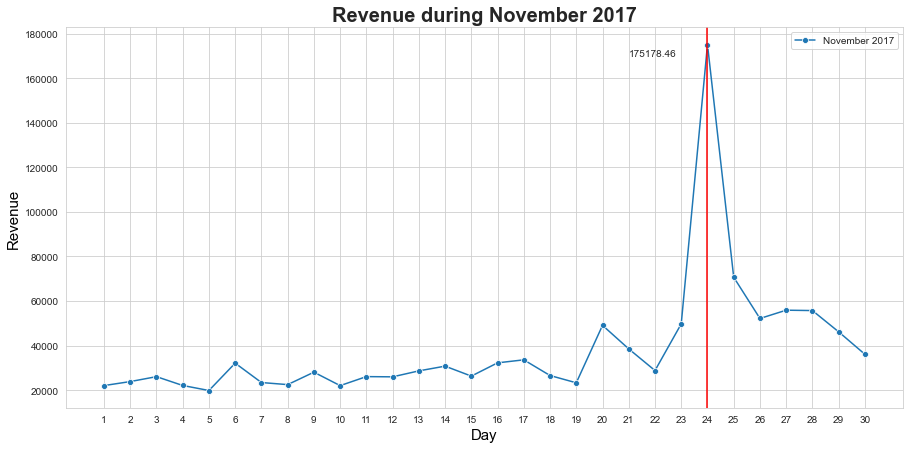

In [116]:
plt.figure(figsize=(15, 7))
sns.lineplot(y = revenueNovember2017['total_revenue'], x = revenueNovember2017.index, marker = 'o', label = 'November 2017')
plt.title('Revenue during November 2017',fontweight='bold',fontsize=20)
plt.axvline(24, c = 'r')
plt.annotate(revenueNovember2017.loc[24].total_revenue, (21, 170000))
plt.xlabel('Day',fontsize=15,color='black')
plt.ylabel('Revenue',fontsize=15,color='black')
plt.xticks(range(1, 31))
plt.legend()
plt.show()

**Observations:**
1. **Black Friday Sale** fell on **24th of November** during the year **2017**, during which the highest number of orders, **1147 orders were placed**. 
2. This generated the **maximum revenue for a single day**, which was around **175K Brazilian Real**.
3. During the further sales in later years, this should be tapped in to increase the revenue and compare with other players in the same industry.
4. The **peak and trought seen in the revenue** during the months of November and December corresponds to Black Friday Sale, and the dip in sales is not necessarily due to any specific reasons. This is said because the December's revenue is still higher than that of November's. So the **trought is not due to any wrongdoings in the business**. 

### Late delivering sellers on Black Friday

In [117]:
def deliveryType(Date):
    if Date < 0:
        return 'Late'
    else:
        return 'OnTime'

In [118]:
blackFriday = november2017[november2017.Date == 24]
blackFriday['Delivery'] = blackFriday['delivered_estimated'].apply(deliveryType)
blackFriday.head()

order_id                       customer_id  \
17   6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   
59   b01875821b8dcb6abc61776f0f971bce  818596f5b68adfe2c11498ebb6d39e02   
60   b01875821b8dcb6abc61776f0f971bce  818596f5b68adfe2c11498ebb6d39e02   
115  c263211bd219538f7c031591e87ef0d7  ed8c52327eecff596e141636d5b556d2   
116  c263211bd219538f7c031591e87ef0d7  ed8c52327eecff596e141636d5b556d2   

    order_status order_purchase_timestamp   order_approved_at  \
17     delivered      2017-11-24 21:27:48 2017-11-25 00:21:09   
59     delivered      2017-11-24 21:55:22 2017-11-25 01:31:43   
60     delivered      2017-11-24 21:55:22 2017-11-25 01:31:43   
115    delivered      2017-11-24 16:56:46 2017-11-28 03:48:24   
116    delivered      2017-11-24 16:56:46 2017-11-28 03:48:24   

    order_delivered_carrier_date order_delivered_customer_date  \
17           2017-12-13 21:14:05           2017-12-28 18:59:23   
59           2017-11-28 22:37:15           2017-12-01 21:11:40   
60           2017-11-28 22:37:15           2017-12-01 21:11:40   
115          2017-12-08 23:28:26           2017-12-18 20:24:54   
116          2017-12-08 23:28:26           2017-12-18 20:24:54   

    order_estimated_delivery_date  purchased_approved  approved_carrier  \
17                     2017-12-21               10401                18   
59                     2017-12-15               12981                 3   
60                     2017-12-15               12981                 3   
115                    2017-12-19               39098                10   
116                    2017-12-19               39098                10   

     carrier_delivered  delivered_estimated  purchased_delivered  \
17                  14                   -8                   33   
59                   2                   13                    6   
60                   2                   13                    6   
115                  9                    0                   24   
116                  9                    0                   24   

     order_item_id                        product_id  \
17               1  be021417a6acb56b9b50d3fd2714baa8   
59               1  a6ad77b15e566298a4e8ee2011ab1255   
60               2  a6ad77b15e566298a4e8ee2011ab1255   
115              1  028b0b0277744a9eaa2c4f57c24dcb68   
116              2  028b0b0277744a9eaa2c4f57c24dcb68   

                            seller_id shipping_limit_date  price  \
17   f5f46307a4d15880ca14fab4ad9dfc9b 2017-11-30 00:21:09  339.0   
59   1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-01 00:38:17   31.8   
60   1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-01 00:38:17   31.8   
115  1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-05 03:48:24  359.7   
116  1025f0e2d44d7041d6cf58b6550e0bfa 2017-12-05 03:48:24  359.7   

     freight_value  Month  isLateDelivery  isOnTimeDelivery  Date Delivery  
17           17.12     11               1                 0    24     Late  
59           39.28     11               0                 1    24   OnTime  
60           39.28     11               0                 1    24   OnTime  
115          17.27     11               0                 0    24   OnTime  
116          17.27     11               0                 0    24   OnTime

In [119]:
blackFriday.order_id.nunique()

1147

In [120]:
year2017.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
2  a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   
3  6514b8ad8028c9f2cc2374ded245783f  9bdf08b4b3b52b5526ff42d37d47f222   
4  76c6e866289321a7c93b82b54852dc33  f54a9f0e6b351c431402b8461ea51999   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
2    delivered      2017-07-09 21:57:05 2017-07-09 22:10:13   
3    delivered      2017-05-16 13:10:30 2017-05-16 13:22:11   
4    delivered      2017-01-23 18:29:09 2017-01-25 02:50:47   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-11-22 13:39:59           2017-12-02 00:28:42   
2          2017-07-11 14:58:04           2017-07-26 10:57:55   
3          2017-05-22 10:07:46           2017-05-26 12:55:51   
4          2017-01-26 14:16:31           2017-02-02 14:08:10   

  order_estimated_delivery_date  purchased_approved  approved_carrier  \
0                    2017-10-18                 642                 2   
1                    2017-12-15                1073                 3   
2                    2017-08-01                 788                 1   
3                    2017-06-07                 701                 5   
4                    2017-03-06               30098                 1   

   carrier_delivered  delivered_estimated  purchased_delivered  order_item_id  \
0                  6                    7                    8              1   
1                  9                   12                   13              1   
2                 14                    5                   16              1   
3                  4                   11                    9              1   
4                  6                   31                    9              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
2  060cb19345d90064d1015407193c233d  8581055ce74af1daba164fdbd55a40de   
3  4520766ec412348b8d4caa5e8a18c464  16090f2ca825584b5a147ab24aa30c86   
4  ac1789e492dcd698c5c10b97a671243a  63b9ae557efed31d1f7687917d248a8d   

  shipping_limit_date   price  freight_value  Month  isLateDelivery  \
0 2017-10-06 11:07:15   29.99           8.72     10               0   
1 2017-11-23 19:45:59   45.00          27.20     11               0   
2 2017-07-13 22:10:13  147.90          27.36      7               0   
3 2017-05-22 13:22:11   59.99          15.17      5               0   
4 2017-01-27 18:29:09   19.90          16.05      1               0   

   isOnTimeDelivery  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1

In [121]:
lateDeliveringSellers_blackFriday = blackFriday[blackFriday.delivered_estimated < 0]['seller_id']
lateDeliveringSellers_blackFriday.value_counts().to_frame()

seller_id
8160255418d5aaa7dbdc9f4c64ebda44         22
1f50f920176fa81dab994f9023523100         18
1025f0e2d44d7041d6cf58b6550e0bfa         18
4a3ca9315b744ce9f8e9374361493884         12
54965bbe3e4f07ae045b90b0b8541f52         11
...                                     ...
1da3aeb70d7989d1e6d9b0e887f97c23          1
7b07b3c7487f0ea825fc6df75abd658b          1
c864036feaab8c1659f65ea4faebe1da          1
712e6ed8aa4aa1fa65dab41fed5737e4          1
2c9e548be18521d1c43cde1c582c6de8          1

[114 rows x 1 columns]

In [122]:
print('Number of sellers who delivered late during black friday: ', blackFriday[blackFriday.delivered_estimated < 0]['seller_id'].nunique())

Number of sellers who delivered late during black friday:  114


In [123]:
averageLateDeliveringSellers = november2017[november2017.delivered_estimated < 0].groupby('Date').agg({'seller_id' : 'nunique'}).drop(24).seller_id.mean()
print('Average late delivering sellers over the months: ', round(averageLateDeliveringSellers))

Average late delivering sellers over the months:  22


In [124]:
lateDeliveringSellers_blackFriday = blackFriday[blackFriday.delivered_estimated < 0]['seller_id']
lateDeliveringSellers_blackFriday.value_counts()[lateDeliveringSellers_blackFriday.value_counts() > 5]

8160255418d5aaa7dbdc9f4c64ebda44    22
1f50f920176fa81dab994f9023523100    18
1025f0e2d44d7041d6cf58b6550e0bfa    18
4a3ca9315b744ce9f8e9374361493884    12
54965bbe3e4f07ae045b90b0b8541f52    11
ea8482cd71df3c1969d7b9473ff13abc    10
Name: seller_id, dtype: int64

**Observations:**
1. As the number of orders increased, late deliveries was also on the rise which indicates **inability to handle huge volume of orders**. 
2. During peak sales days, such late delivering sellers should be avoided or they should be told to **increase their delivery performance**. 

### Late deliveries on Black Friday Sale

In [125]:
ontimeDelivery_bf = blackFriday[blackFriday.delivered_estimated > 0][['purchased_approved', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']].mean()
lateDelivery_bf = blackFriday[blackFriday.delivered_estimated < 0][['purchased_approved', 'approved_carrier', 'carrier_delivered', 'delivered_estimated', 'purchased_delivered']].mean()
comparision = pd.DataFrame([ontimeDelivery_bf, lateDelivery_bf]).T
comparision.rename(columns = {0 : 'on time delivery', 1 : 'late delivery'}, inplace = True)
comparision

on time delivery  late delivery
purchased_approved       15799.711174   18235.150000
approved_carrier             3.282197       7.869231
carrier_delivered            8.235795      23.346154
delivered_estimated          9.737689      -9.788462
purchased_delivered         12.554924      32.380769

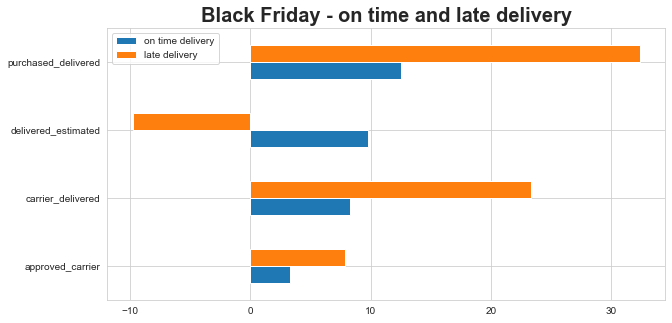

In [126]:
comparision.drop('purchased_approved').plot(kind = 'barh', figsize = (10, 5))
plt.title('Black Friday - on time and late delivery',fontweight='bold',fontsize=20)
plt.show()

In [127]:
blackFriday.Delivery.value_counts(normalize = True) * 100

OnTime    80.669145
Late      19.330855
Name: Delivery, dtype: float64

**Observations:**
1. Inability to handle huge volume of orders (1147) as **19.33%** of orders **delivered late** compared to an **overall 8.12% late deliveries**.
2. **Increase delivery performance** to attract more sales during successive offers.
3. Understand customer preference and market those products extensively on sale days.

### Products ordered on Black Friday Sale

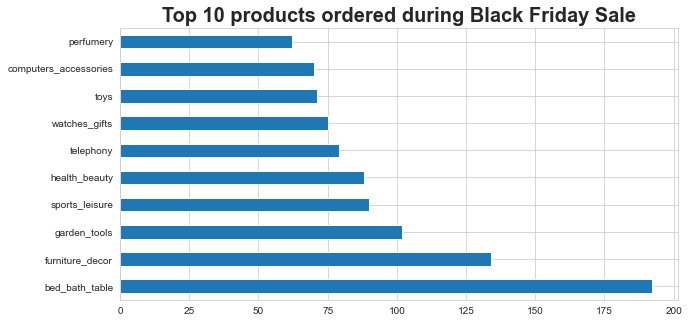

In [128]:
blackFridayProducts = blackFriday.merge(products[['product_id', 'product_category_name']], on = 'product_id').merge(productCategoryTranslation, on = 'product_category_name')
plt.figure(figsize = (10, 5))
blackFridayProducts.product_category_name_english.value_counts()[:10].plot(kind = 'barh')
plt.title('Top 10 products ordered during Black Friday Sale',fontweight='bold',fontsize=20)
plt.show()

**Observations:**
1. **Customer preferences**, **regional demands**, **market trends** should be considered during future sale days so as to increase revenue. 
2. Customer preferences could be seen from the above bar plot, which gives the top products ordered during the black friday sale.
3. **Bed bath table** constituted the **most orders during that day**. 

<a id="lateDelivery"></a>
## 4.8. Analysis of Late Deliveries

In [129]:
def is_late(Days):
    if Days < -10:
        return 'delayed by >10 days'
    elif Days < -5 and Days >= -10:
        return 'delayed by 6-10 days'
    elif Days < 0 and Days >= -5:
        return 'delayed by 1-5 days'
    else:
        return 'on time'

In [130]:
lateDelivery = orders[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'delivered_estimated']].merge(orderReviews[['order_id', 'review_score']], on = 'order_id', how = 'left')
lateDelivery['is_late'] = lateDelivery['delivered_estimated'].apply(is_late)
lateDelivery.head()

order_id order_purchase_timestamp  \
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
1  53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37   
2  47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49   
3  949d5b44dbf5de918fe9c16f97b45f8a      2017-11-18 19:28:06   
4  ad21c59c0840e6cb83a9ceb5573f8159      2018-02-13 21:18:39   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13                    2017-10-18   
1           2018-08-07 15:27:45                    2018-08-13   
2           2018-08-17 18:06:29                    2018-09-04   
3           2017-12-02 00:28:42                    2017-12-15   
4           2018-02-16 18:17:02                    2018-02-26   

   delivered_estimated  review_score  is_late  
0                    7           NaN  on time  
1                    5           4.0  on time  
2                   17           NaN  on time  
3                   12           NaN  on time  
4                    9           NaN  on time

In [131]:
lateDelivery.is_late.value_counts()

on time                 87320
delayed by 1-5 days      3596
delayed by >10 days      2294
delayed by 6-10 days     1904
Name: is_late, dtype: int64

In [132]:
lateDelivery.is_late.value_counts(normalize = True) * 100

on time                 91.805623
delayed by 1-5 days      3.780726
delayed by >10 days      2.411843
delayed by 6-10 days     2.001808
Name: is_late, dtype: float64

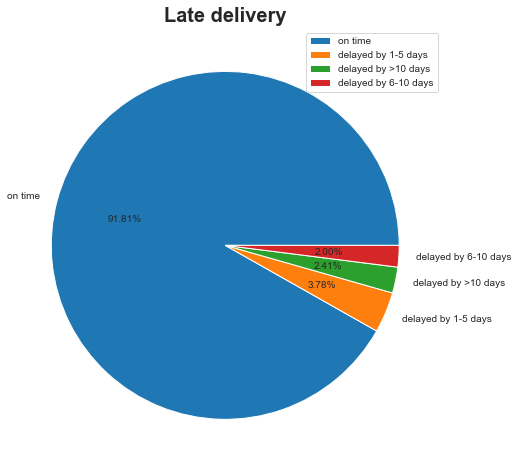

In [133]:
plt.figure(figsize = (10, 8))
plt.pie(lateDelivery.is_late.value_counts(), autopct = '%0.2f%%', labels = lateDelivery.is_late.value_counts().index)
plt.title('Late delivery',fontweight='bold',fontsize=20)
plt.legend()
plt.show()

**Observations:**
1. To find out if the order was delivered late than the expected date of delivery, we took the `order_delivered_customer_date` and the `order_estimated_delivery_date` and **subtracted them to get the required number of days**. 
2. If the value was in **positive**, it denotes that the products were **delivered before the estimated date of delivery**, which are mapped to **on time**.
3. Late deliveries upto 5 days are mapped to **delayed by 1-5 days**, while late deliveries between 5-10 days are mapped to **delayed by 6-10 days** and late deliveries greater than 10 are mapped to **delayed by >10 days**.
4. Of all the orders, **91.89%** of orders were **delivered on time**, whereas, only **8.11%** of deliveries were **delivered late**. But this level of late deliveries should also be minimized in order to retain more customers, as they could potentially move to other e-commerce platforms. 

In [134]:
reviewScore_lateDelivery = lateDelivery.groupby('is_late').agg({'review_score' : 'mean'})
reviewScore_lateDelivery

review_score
is_late                           
delayed by 1-5 days       3.393782
delayed by 6-10 days      1.824645
delayed by >10 days       1.736559
on time                   4.042449

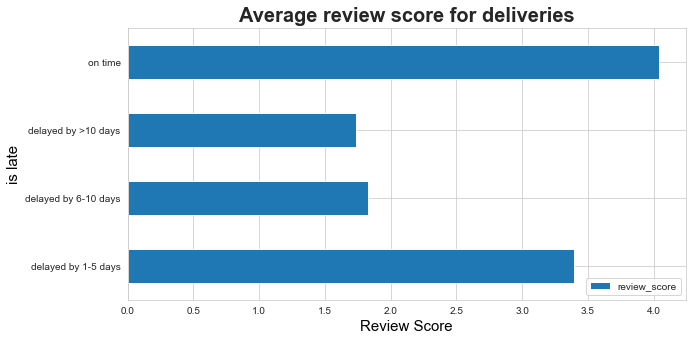

In [135]:
reviewScore_lateDelivery.plot(kind = 'barh', figsize = (10, 5))
plt.title('Average review score for deliveries',fontweight='bold',fontsize=20)
plt.xlabel('Review Score',fontsize=15,color='black')
plt.ylabel('is late',fontsize=15,color='black')
plt.show()

**Observations:**
1. The delivery time with respect to the expected date of delivery is correlated with the **review score** that the customers give. 
2. For instance, orders which were **delivered on time** recieved on an average of **4** as their review score, while orders which were **delivered late by more than 10 days** recieved an average review score of **1.7**. 
3. This could be a clear indication that the **customers were dissatisfied by the late deliveries**, and this needs to be minimized to a greater extent to retain customers. 

In [136]:
lateDeliveringSellers = lateDelivery[lateDelivery.is_late != 'on time'].merge(orderItems[['seller_id', 'product_id', 'order_id', 'product_id']], on = 'order_id', how = 'left')
lateDeliveringSellersAnalysis = lateDeliveringSellers.groupby('seller_id').agg({'order_id' : 'count', 'delivered_estimated' : 'mean'}).sort_values(by = 'order_id', ascending = False)[:11]
lateDeliveringSellersAnalysis['delivered_estimated'] = lateDeliveringSellersAnalysis['delivered_estimated'].round()
lateDeliveringSellersAnalysis

order_id  delivered_estimated
seller_id                                                      
4a3ca9315b744ce9f8e9374361493884       214                -11.0
1f50f920176fa81dab994f9023523100       182                -10.0
4869f7a5dfa277a7dca6462dcf3b52b2       133                 -9.0
1025f0e2d44d7041d6cf58b6550e0bfa       130                 -6.0
7c67e1448b00f6e969d365cea6b010ab       130                -11.0
ea8482cd71df3c1969d7b9473ff13abc       123                 -8.0
6560211a19b47992c3666cc44a7e94c0       122                 -7.0
955fee9216a65b617aa5c0531780ce60       119                 -7.0
da8622b14eb17ae2831f4ac5b9dab84a       113                -11.0
cc419e0650a3c5ba77189a1882b7556a       103                 -8.0
8b321bb669392f5163d04c59e235e066       103                 -9.0

**Observations:**
1. The list of sellers who were involved in late deliveries of more than 100 orders, and the `delivered_estimated` field is the average number of days taken for late delivery of such orders. 
2. If we could make these sellers deliver on time, we could further avoid customer dissatisfaction, which was reflected in the low review rating. 

<a id="goldenHour"></a>
## 4.9. Golden hours for business

In [137]:
def weekend(dayName):
    if dayName == 'Saturday' or dayName == 'Sunday':
        return 'weekend'
    else:
        return 'weekday'

In [138]:
ordersTimeAnalysis = orders.copy().merge(orderItems, on = 'order_id')
ordersTimeAnalysis['Hour'] = ordersTimeAnalysis.order_purchase_timestamp.dt.hour
ordersTimeAnalysis['day_name'] = ordersTimeAnalysis.order_purchase_timestamp.dt.day_name()
ordersTimeAnalysis['is_weekend'] = ordersTimeAnalysis.day_name.apply(weekend)
ordersTimeAnalysis['total_revenue'] = ordersTimeAnalysis.price + ordersTimeAnalysis.freight_value
ordersTimeAnalysis.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  purchased_approved  approved_carrier  \
0                    2017-10-18                 642                 2   
1                    2018-08-13               24170                 0   
2                    2018-09-04                 994                 0   
3                    2017-12-15                1073                 3   
4                    2018-02-26                3710                 0   

   carrier_delivered  delivered_estimated  purchased_delivered  order_item_id  \
0                  6                    7                    8              1   
1                 12                    5                   13              1   
2                  9                   17                    9              1   
3                  9                   12                   13              1   
4                  1                    9                    2              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

  shipping_limit_date   price  freight_value  Hour   day_name is_weekend  \
0 2017-10-06 11:07:15   29.99           8.72    10     Monday    weekday   
1 2018-07-30 03:24:27  118.70          22.76    20    Tuesday    weekday   
2 2018-08-13 08:55:23  159.90          19.22     8  Wednesday    weekday   
3 2017-11-23 19:45:59   45.00          27.20    19   Saturday    weekend   
4 2018-02-19 20:31:37   19.90           8.72    21    Tuesday    weekday   

   total_revenue  
0          38.71  
1         141.46  
2         179.12  
3          72.20  
4          28.62

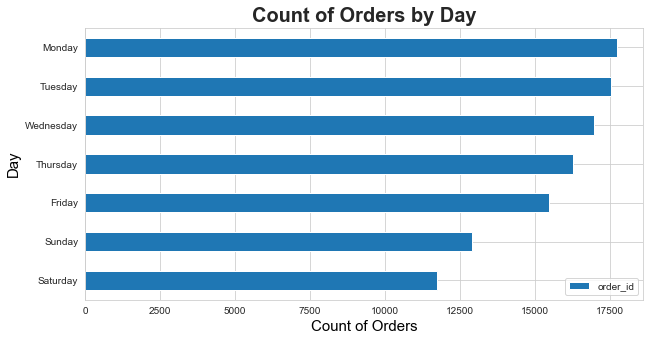

In [139]:
ordersTimeAnalysis.groupby(['day_name']).agg({'order_id' : 'count'}).sort_values('order_id').plot(kind = 'barh', figsize = (10, 5))
plt.title('Count of Orders by Day',fontweight='bold',fontsize=20)
plt.xlabel('Count of Orders',fontsize=15,color='black')
plt.ylabel('Day',fontsize=15,color='black')
plt.show()

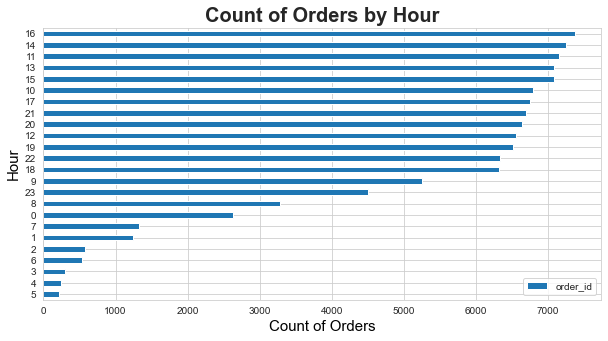

In [140]:
ordersTimeAnalysis.groupby(['Hour']).agg({'order_id' : 'count'}).sort_values('order_id').plot(kind = 'barh', figsize = (10, 5))
plt.title('Count of Orders by Hour',fontweight='bold',fontsize=20)
plt.xlabel('Count of Orders',fontsize=15,color='black')
plt.ylabel('Hour',fontsize=15,color='black')
plt.show()

**Observations:**
1. The above plots represent the **peak hours** and **peak days** during which the customers order products. 
2. The **customer traffic is more during the weekdays compared to the weekends**, with **Monday** and **Tuesday** being the days when most orders were placed. 
3. Similarly, the **peak time** during which most number of orders were placed were between **11 AM** to **4 PM** in the afternoon. 
4. We could improve our sales and revenue if we could tap in this information and target the customers with attractive offers. 

**Business recommendations:**
1. **Increase weekend sales** by **strong digital presence** and **extensive marketing**.
2. **Attractive offers** during peak hour business.
3. Targeting customers through personalised advertisements of products they prefer.
4. **Loyal customers benefits** and **improve customer support**.

<a id="products"></a>
## 4.10. Exploratory Data Analysis On Products dataframe

In [141]:
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [142]:
print('Number of records:',products.shape[0])
print('Number of Columns:',products.shape[1])

Number of records: 32951
Number of Columns: 9


In [143]:
products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [144]:
products.dropna(inplace = True)

**Observation:**
1. Since the **product IDs are masked**, if they do not have any category name, we could not interpret anything from the data, so **dropping such records** will be the best way to proceed with the analysis. 

In [145]:
orderedProducts = products.merge(orderItems, on = 'product_id').merge(productCategoryTranslation, on = 'product_category_name')[['product_id', 'product_category_name_english', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'order_id', 'price', 'freight_value']]
orderedProducts['total_revenue'] = orderedProducts.price + orderedProducts.freight_value
orderedProducts.head()

product_id product_category_name_english  \
0  1e9e8ef04dbcff4541ed26657ea517e5                     perfumery   
1  6a2fb4dd53d2cdb88e0432f1284a004c                     perfumery   
2  6a2fb4dd53d2cdb88e0432f1284a004c                     perfumery   
3  0d009643171aee696f4733340bc2fdd0                     perfumery   
4  0d009643171aee696f4733340bc2fdd0                     perfumery   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 39.0                       346.0                 2.0   
2                 39.0                       346.0                 2.0   
3                 52.0                       150.0                 1.0   
4                 52.0                       150.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             225.0               16.0               10.0              14.0   
1             400.0               27.0                5.0              20.0   
2             400.0               27.0                5.0              20.0   
3             422.0               21.0               16.0              18.0   
4             422.0               21.0               16.0              18.0   

                           order_id   price  freight_value  total_revenue  
0  e17e4f88e31525f7deef66779844ddce   10.91           7.39          18.30  
1  048cc42e03ca8d43c729adf6962cb348   16.90           7.78          24.68  
2  5fa78e91b5cb84b6a8ccc42733f95742   16.90           7.78          24.68  
3  24b1c4d88fdb7a2dc87f8ecc7d8f47f1  339.00          17.13         356.13  
4  7b13c77c64a9a956500cbf1a9a23798d  275.00          23.48         298.48

In [146]:
orderedProductsAnalysis = orderedProducts.groupby('product_category_name_english', as_index = False).agg({
                                                        'product_id'                      : 'count',                                                       
                                                        'order_id'                        : 'count',
                                                        'price'                           : 'sum',
                                                        'freight_value'                   : 'sum',
                                                        'total_revenue'                   : 'sum'})
orderedProductsAnalysis.head()

product_category_name_english  product_id  order_id     price  \
0    agro_industry_and_commerce         212       212  72530.47   
1              air_conditioning         297       297  55024.96   
2                           art         209       209  24202.64   
3         arts_and_craftmanship          24        24   1814.01   
4                         audio         364       364  50688.50   

   freight_value  total_revenue  
0        5843.60       78374.07  
1        6749.23       61774.19  
2        4045.17       28247.81  
3         370.13        2184.14  
4        5710.44       56398.94

In [147]:
orderedProductsAnalysis.select_dtypes(include = np.number).describe()

product_id      order_id         price  freight_value  total_revenue
count     71.000000     71.000000  7.100000e+01      71.000000   7.100000e+01
mean    1563.690141   1563.690141  1.887980e+05   31313.653521   2.201117e+05
std     2606.537422   2606.537422  3.036850e+05   50281.462423   3.515343e+05
min        2.000000      2.000000  2.832900e+02      41.220000   3.245100e+02
25%       93.000000     93.000000  9.171185e+03    1973.205000   1.174393e+04
50%      281.000000    281.000000  4.685688e+04    6749.230000   5.605240e+04
75%     1819.000000   1819.000000  2.029071e+05   35505.620000   2.214684e+05
max    11115.000000  11115.000000  1.258681e+06  204693.040000   1.441248e+06

In [148]:
top10revenueGenerating = orderedProductsAnalysis.sort_values(by = 'total_revenue', ascending = False)[:10]
top10revenueGenerating

product_category_name_english  product_id  order_id       price  \
43                 health_beauty        9670      9670  1258681.34   
70                 watches_gifts        5991      5991  1205005.68   
7                 bed_bath_table       11115     11115  1036988.68   
65                sports_leisure        8641      8641   988048.97   
15         computers_accessories        7827      7827   911954.32   
39               furniture_decor        8334      8334   729762.49   
49                    housewares        6964      6964   632248.66   
20                    cool_stuff        3796      3796   635290.85   
5                           auto        4235      4235   592720.11   
42                  garden_tools        4347      4347   485256.46   

    freight_value  total_revenue  
43      182566.73     1441248.07  
70      100535.93     1305541.61  
7       204693.04     1241681.72  
65      168607.51     1156656.48  
15      147318.08     1059272.40  
39      172749.30      902511.79  
49      146149.11      778397.77  
20       84039.10      719329.95  
5        92664.21      685384.32  
42       98962.75      584219.21

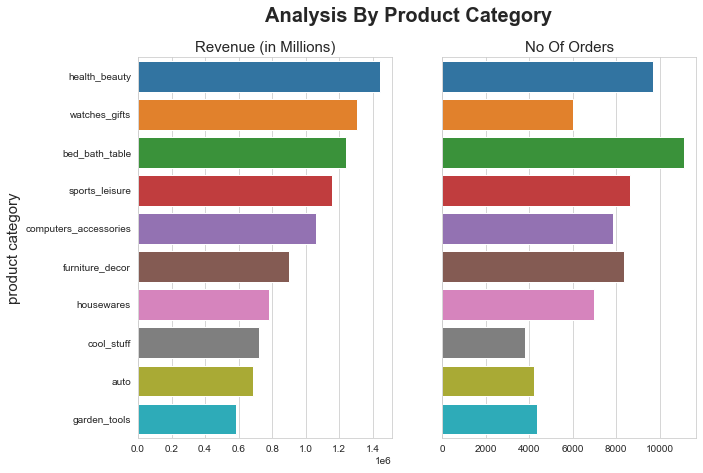

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), sharey=True)
fig.suptitle('Analysis By Product Category', fontsize=20, fontweight = 'bold')

sns.barplot(ax=ax[0], x='total_revenue', y= top10revenueGenerating.product_category_name_english, data = top10revenueGenerating)
ax[0].set_title('Revenue (in Millions)', fontsize = 15)
ax[0].set_ylabel('product category', fontsize = 15)

sns.barplot(ax=ax[1], x='order_id', y = top10revenueGenerating.product_category_name_english, data = top10revenueGenerating)
ax[1].set_title('No Of Orders', fontsize = 15)

for i in range(0,2):
    ax[i].set(xlabel=None)

for i in range(1,2):
    ax[i].set(ylabel=None)

In [150]:
bottom10revenueGenerating = orderedProductsAnalysis.sort_values(by = 'total_revenue', ascending = True)[:10]
bottom10revenueGenerating

product_category_name_english  product_id  order_id    price  \
61         security_and_services           2         2   283.29   
29     fashion_childrens_clothes           8         8   569.85   
11             cds_dvds_musicals          14        14   730.00   
46                home_comfort_2          30        30   760.27   
35                       flowers          33        33  1110.04   
23           diapers_and_hygiene          39        39  1567.59   
3          arts_and_craftmanship          24        24  1814.01   
52                    la_cuisine          14        14  2054.99   
32                 fashion_sport          30        30  2119.51   
27        fashio_female_clothing          48        48  2803.64   

    freight_value  total_revenue  
61          41.22         324.51  
29          95.51         665.36  
11         224.99         954.99  
46         410.31        1170.58  
35         488.87        1598.91  
23         573.68        2141.27  
3          370.13        2184.14  
52         333.55        2388.54  
32         578.13        2697.64  
27         621.75        3425.39

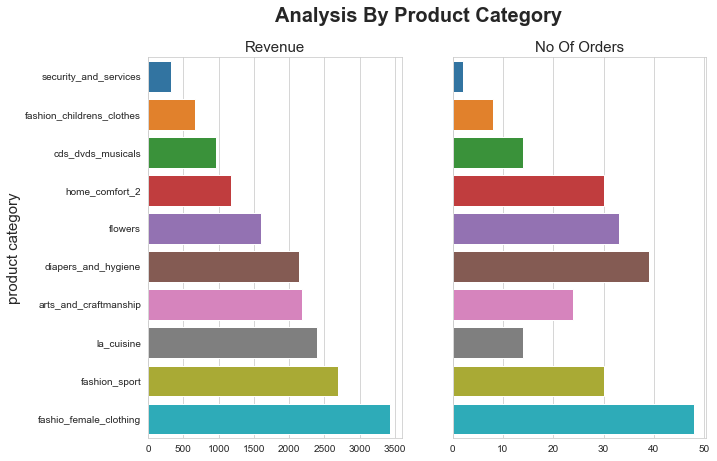

In [151]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), sharey=True)
fig.suptitle('Analysis By Product Category', fontsize=20, fontweight = 'bold')

sns.barplot(ax=ax[0], x='total_revenue', y= bottom10revenueGenerating.product_category_name_english, data = bottom10revenueGenerating)
ax[0].set_title('Revenue', fontsize = 15)
ax[0].set_ylabel('product category', fontsize = 15)

sns.barplot(ax=ax[1], x='order_id', y = bottom10revenueGenerating.product_category_name_english, data = bottom10revenueGenerating)
ax[1].set_title('No Of Orders', fontsize = 15)

for i in range(0,2):
    ax[i].set(xlabel=None)

for i in range(1,2):
    ax[i].set(ylabel=None)

**Observations:**
1. The main inference from the analysis of products ordered is, the total revenue each product category generated.
2. The minimum revenue generated products were, **security and services**, **fashion childrens clothes** and **cds dvds musicals**.
3. While the maximum revenue generated products were **health beauty**, **watches gifts** and **bed bath table**.
4. **security and services** is the least ordered product, while **bed bath table** is the most ordered product. 

<a id="overseas"></a>
## 4.11. Overseas Customers

In [152]:
overseasCustomers = customerDensity[customerDensity.geolocation_lat > 10]
overseasCustomers.head()

customer_unique_id customer_zip_code_prefix  \
3830   3fbfe90197db709a78d7e0eaabe0aac0                    47310   
4887   a8563d0be40211e2527f8b80c24f4845                    28595   
5111   aef278d3c4350b0d32907d429421f071                    68447   
14955  c037aa753c0787f6e28b2d5c5e40d997                    68447   
16444  f570b38fd1007c094f293aadb09bcedf                    68447   

       geolocation_lat  geolocation_lng  
3830         38.268205        -7.803886  
4887         43.684961        -7.411080  
5111         42.428884        -6.873344  
14955        42.428884        -6.873344  
16444        42.428884        -6.873344

In [153]:
# create a map centered on your coordinates
m = folium.Map(location = overseasCustomers[['geolocation_lat', 'geolocation_lng']].values.tolist()[0], zoom_start = 13)

# create a list of coordinates
coordinates = overseasCustomers[['geolocation_lat', 'geolocation_lng']].values.tolist()

# create a heatmap layer with the list of coordinates
heat_layer = HeatMap(coordinates)

# add the heatmap layer to the map
heat_layer.add_to(m)

# display the map
m

In [154]:
overseasAnalysis = overseasCustomers[['customer_unique_id']].merge(customers, on = 'customer_unique_id').merge(orders, on = 'customer_id').merge(orderItems, on = 'order_id').merge(products, on = 'product_id').merge(productCategoryTranslation, on = 'product_category_name')
overseasAnalysis.head()

customer_unique_id                       customer_id  \
0  3fbfe90197db709a78d7e0eaabe0aac0  d92a2fbf56a1e0f231a58f7a1e9ca540   
1  a8563d0be40211e2527f8b80c24f4845  4457d60c844b9cec4abec3a9507f23a5   
2  6e9d7c002cb4603011d3e83033b01878  2dd769df72fbd8448297d18c48df7b92   
3  aef278d3c4350b0d32907d429421f071  d90af5c00814430fc3e212e8163bf2b8   
4  2a4b1192846ec238d62df3838257bad9  88aac7b0942dcdb41ebabf7811b106fc   

  customer_zip_code_prefix       customer_city customer_state  \
0                    47310  santana do sobrado             BA   
1                    28595             portela             RJ   
2                    46560            ibiajara             BA   
3                    68447    vila dos cabanos             PA   
4                    68275     porto trombetas             PA   

                           order_id order_status order_purchase_timestamp  \
0  ed7774b614a7ad220649f09dc6a4c043    delivered      2017-11-16 23:27:21   
1  a85ce89cbcc514dfe135de0036be45db    delivered      2017-08-21 16:17:56   
2  897ec6416d50126a9061626f0fc2d658    delivered      2017-04-20 15:05:38   
3  72fb560d115ecf3b15de9b853c02e505    delivered      2018-04-19 14:04:23   
4  4d5abe7999d76d1fb6237d3677706af0    delivered      2017-11-23 18:13:30   

    order_approved_at order_delivered_carrier_date  \
0 2017-11-16 23:50:57          2017-11-17 22:32:25   
1 2017-08-23 02:50:25          2017-08-23 15:33:02   
2 2017-04-20 15:21:31          2017-04-24 07:52:21   
3 2018-04-19 14:34:54          2018-04-23 09:57:00   
4 2017-11-23 18:55:39          2017-11-28 20:07:50   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-12-11 14:14:54                    2017-12-13   
1           2017-09-19 10:52:56                    2017-09-13   
2           2017-05-18 08:06:47                    2017-05-22   
3           2018-06-06 20:32:22                    2018-06-01   
4           2017-12-19 08:58:58                    2018-01-04   

   purchased_approved  approved_carrier  carrier_delivered  \
0                1416                 0                 23   
1               37949                 0                 26   
2                 953                 3                 24   
3                1831                 3                 44   
4                2529                 5                 20   

   delivered_estimated  purchased_delivered  order_item_id  \
0                    1                   24              1   
1                   -7                   28              1   
2                    3                   27              1   
3                   -6                   48              1   
4                   15                   25              1   

                         product_id                         seller_id  \
0  1a980a10bed1d765e2eb2ad3608a63a1  dbc22125167c298ef99da25668e1011f   
1  7a10781637204d8d10485c71a6108a2e  4869f7a5dfa277a7dca6462dcf3b52b2   
2  1d54b96972338247c7341a2069e2bd96  6560211a19b47992c3666cc44a7e94c0   
3  3fbc0ef745950c7932d5f2a446189725  06a2c3af7b3aee5d69171b0e14f0ee87   
4  187e7d92b8168c3661824809d0c5dffb  431af27f296bc6519d890aa5a05fdb11   

  shipping_limit_date   price  freight_value product_category_name  \
0 2017-11-22 23:50:57   36.90          17.92      malas_acessorios   
1 2017-08-29 02:50:25  229.90          16.36    relogios_presentes   
2 2017-04-27 15:21:31   45.00          20.80    relogios_presentes   
3 2018-04-25 14:31:42   64.99          18.33          beleza_saude   
4 2017-11-29 18:31:09  119.90          29.24          beleza_saude   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 45.0                       217.0                 1.0   
1                 42.0                       236.0                 1.0   
2                 59.0                       184.0                 1.0   
3                 50.0                      1257.0                 1.0   
4                 30.0          

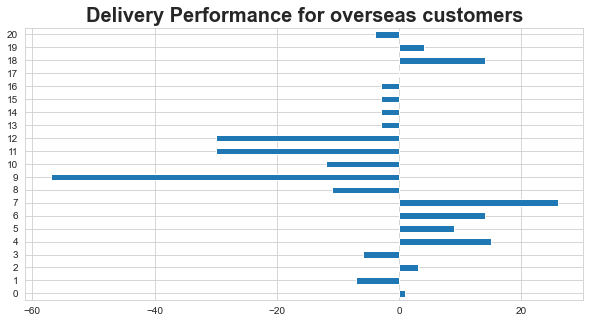

In [155]:
overseasAnalysis.delivered_estimated.plot(kind = 'barh', figsize = (10, 5))
plt.title('Delivery Performance for overseas customers', fontsize=20, fontweight = 'bold')
plt.show()

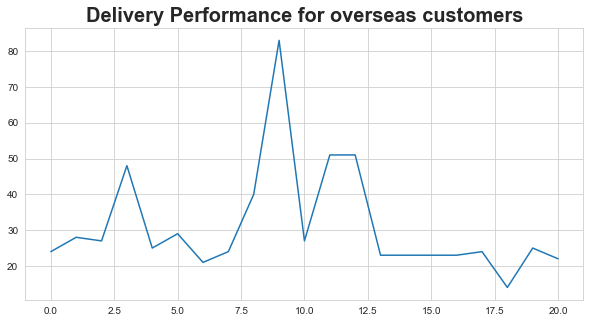

In [156]:
overseasAnalysis.purchased_delivered.plot(kind = 'line', figsize = (10, 5))
plt.title('Delivery Performance for overseas customers', fontsize=20, fontweight = 'bold')
plt.show()

In [157]:
overseasAnalysis.product_category_name_english.value_counts()

stationery             6
health_beauty          3
watches_gifts          2
auto                   2
luggage_accessories    1
art                    1
home_appliances        1
furniture_decor        1
bed_bath_table         1
cool_stuff             1
telephony              1
home_appliances_2      1
Name: product_category_name_english, dtype: int64

**Business Recommendations:**
1. **Overseas customers** mostly ordered **from 2018**.
2. **More than 50% of orders** were **delivered late** than the estimated delivery date.
3. Very **poor shipment delivery rate** should be handled by **opting for a new logistic partner**.
4. **Promoting indigenous products** especially **among overseas customers** to increase sales and revenue.
5. Focus on **company branding** and **prominency in the origin region**, to help create trust among customers.
6. Focus on **CX (Customer Experience)** throughout the process of order and **offer customer support**.

<a id="merge"></a>
# 5. Merging the individual datasets

In [158]:
merged = customers.merge(orders, on = 'customer_id').merge(orderItems, on = 'order_id').merge(products, on = 'product_id').merge(geolocationMean, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix').merge(payments, on = 'order_id').merge(sellers, on = 'seller_id').merge(productCategoryTranslation, on = 'product_category_name').merge(orderReviews, on = 'order_id', how = 'left')
merged.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2  8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
3  f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
4  6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   

  customer_zip_code_prefix    customer_city customer_state  \
0                    14409           franca             SP   
1                    68030         santarem             PA   
2                    68030         santarem             PA   
3                    92480  nova santa rita             RS   
4                    25931             mage             RJ   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  c1d2b34febe9cd269e378117d6681172    delivered      2017-11-09 00:50:13   
2  c1d2b34febe9cd269e378117d6681172    delivered      2017-11-09 00:50:13   
3  b1a5d5365d330d10485e0203d54ab9e8    delivered      2017-05-07 20:11:26   
4  2e604b3614664aa66867856dba7e61b7    delivered      2018-02-03 19:45:40   

    order_approved_at order_delivered_carrier_date  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57   
1 2017-11-10 00:47:48          2017-11-22 01:43:37   
2 2017-11-10 00:47:48          2017-11-22 01:43:37   
3 2017-05-08 22:22:56          2017-05-19 20:16:31   
4 2018-02-04 22:29:19          2018-02-19 18:21:47   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-05-25 10:35:35                    2017-06-05   
1           2017-11-28 00:09:50                    2017-12-19   
2           2017-11-28 00:09:50                    2017-12-19   
3           2017-05-26 09:54:04                    2017-06-12   
4           2018-02-28 21:09:00                    2018-03-22   

   purchased_approved  approved_carrier  carrier_delivered  \
0                 997                 6                  1   
1               86255                12                  5   
2               86255                12                  5   
3                7890                10                  6   
4                9819                14                  9   

   delivered_estimated  purchased_delivered  order_item_id  \
0                   10                    8              1   
1                   20                   18              1   
2                   20                   18              2   
3                   16                   18              1   
4                   21                   25              1   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
2  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
3  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
4  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   

  shipping_limit_date   price  freight_value product_category_name  \
0 2017-05-22 15:22:12  124.99          21.88     moveis_escritorio   
1 2017-11-23 00:47:18  112.99          24.90     moveis_escritorio   
2 2017-11-23 00:47:18  112.99          24.90     moveis_escritorio   
3 2017-05-22 22:22:56  124.99          15.62     moveis_escritorio   
4 2018-02-18 21:29:19  106.99          30.59     moveis_escritorio   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 41.0                      1141.0                 1.0   
1                 41.0                      1141.0                 1.0   
2                 41.0                      1141.0                 1.0   
3                 41.0                      1141.0                 1.0   
4                 41.0                      1141.0       

In [159]:
merged.shape

(111468, 48)

**Observation:**
1. The merged dataframe is obtained from merging all the individual dataframes. We will use the merged dataframe for our further analysis. 

In [160]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111468 entries, 0 to 111467
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    111468 non-null  object        
 1   customer_unique_id             111468 non-null  object        
 2   customer_zip_code_prefix       111468 non-null  object        
 3   customer_city                  111468 non-null  object        
 4   customer_state                 111468 non-null  object        
 5   order_id                       111468 non-null  object        
 6   order_status                   111468 non-null  object        
 7   order_purchase_timestamp       111468 non-null  datetime64[ns]
 8   order_approved_at              111468 non-null  datetime64[ns]
 9   order_delivered_carrier_date   111468 non-null  datetime64[ns]
 10  order_delivered_customer_date  111468 non-null  datetime64[ns]
 11  

In [161]:
merged.drop(columns = ['order_status', 'order_item_id', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'approved_carrier', 'carrier_delivered', 'seller_id', 'shipping_limit_date', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'geolocation_zip_code_prefix', 'payment_sequential', 'seller_zip_code_prefix', 'review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'seller_city', 'seller_state'], axis = 1, inplace = True)
merged.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
2  8912fc0c3bbf1e2fbf35819e21706718  9eae34bbd3a474ec5d07949ca7de67c0   
3  f0ac8e5a239118859b1734e1087cbb1f  3c799d181c34d51f6d44bbbc563024db   
4  6bc8d08963a135220ed6c6d098831f84  23397e992b09769faf5e66f9e171a241   

  customer_zip_code_prefix    customer_city customer_state  \
0                    14409           franca             SP   
1                    68030         santarem             PA   
2                    68030         santarem             PA   
3                    92480  nova santa rita             RS   
4                    25931             mage             RJ   

                           order_id order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1      2017-05-16 15:05:35   
1  c1d2b34febe9cd269e378117d6681172      2017-11-09 00:50:13   
2  c1d2b34febe9cd269e378117d6681172      2017-11-09 00:50:13   
3  b1a5d5365d330d10485e0203d54ab9e8      2017-05-07 20:11:26   
4  2e604b3614664aa66867856dba7e61b7      2018-02-03 19:45:40   

   purchased_approved  delivered_estimated  purchased_delivered  \
0                 997                   10                    8   
1               86255                   20                   18   
2               86255                   20                   18   
3                7890                   16                   18   
4                9819                   21                   25   

                         product_id   price  freight_value  product_weight_g  \
0  a9516a079e37a9c9c36b9b78b10169e8  124.99          21.88            8683.0   
1  a9516a079e37a9c9c36b9b78b10169e8  112.99          24.90            8683.0   
2  a9516a079e37a9c9c36b9b78b10169e8  112.99          24.90            8683.0   
3  a9516a079e37a9c9c36b9b78b10169e8  124.99          15.62            8683.0   
4  a9516a079e37a9c9c36b9b78b10169e8  106.99          30.59            8683.0   

   product_length_cm  product_height_cm  product_width_cm  geolocation_lat  \
0               54.0               64.0              31.0       -20.468849   
1               54.0               64.0              31.0        -2.430314   
2               54.0               64.0              31.0        -2.430314   
3               54.0               64.0              31.0       -29.826454   
4               54.0               64.0              31.0       -22.604835   

   geolocation_lng payment_type  payment_installments  payment_value  \
0       -47.382173  credit_card                     2         146.87   
1       -54.693217  credit_card                     1         275.79   
2       -54.693217  credit_card                     1         275.79   
3       -51.245676  credit_card                     7         140.61   
4       -43.026500  credit_card                    10         137.58   

  product_category_name_english  review_score  
0              office_furniture           NaN  
1              office_furniture           NaN  
2              office_furniture           NaN  
3              office_furniture           NaN  
4              office_furniture           NaN

<a id="Grp"></a>
# 6. Creating a grouped-by dataframe based on individual customers

In [162]:
final = merged.groupby('customer_unique_id', as_index=False).agg({'customer_zip_code_prefix'      : 'max',
                                                                  'customer_city'                 : 'max',
                                                                  'customer_state'                : 'max',
                                                                  'order_id'                      : 'nunique',
                                                                  'purchased_approved'            : 'mean',
                                                                  'delivered_estimated'           : 'min',
                                                                  'purchased_delivered'           : 'mean',
                                                                  'product_id'                    : 'nunique',
                                                                  'price'                         : 'sum',
                                                                  'freight_value'                 : 'sum',
                                                                  'product_weight_g'              : 'sum',
                                                                  'product_length_cm'             : 'sum',
                                                                  'product_height_cm'             : 'sum',
                                                                  'product_width_cm'              : 'sum',
                                                                  'geolocation_lat'               : 'mean',
                                                                  'geolocation_lng'               : 'mean',
                                                                  'payment_type'                  : 'max',
                                                                  'payment_installments'          : 'max',
                                                                  'payment_value'                 : 'sum',
                                                                  'review_score'                  : 'mean'})

final.head()

customer_unique_id  customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                      7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                      6053        osasco   
2  0000f46a3911fa3c0805444483337064                     88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                     66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                     18040      sorocaba   

  customer_state  order_id  purchased_approved  delivered_estimated  \
0             SP         1               891.0                    4   
1             SP         1             26057.0                    4   
2             SC         1                 0.0                    1   
3             PA         1              1176.0                   11   
4             SP         1              1270.0                    7   

   purchased_delivered  product_id   price  freight_value  product_weight_g  \
0                  6.0           1  129.90          12.00            1500.0   
1                  3.0           1   18.90           8.29             375.0   
2                 25.0           1   69.00          17.22            1500.0   
3                 20.0           1   25.99          17.63             150.0   
4                 13.0           1  180.00          16.89            6050.0   

   product_length_cm  product_height_cm  product_width_cm  geolocation_lat  \
0               34.0                7.0              32.0       -23.333580   
1               26.0               11.0              18.0       -23.545029   
2               25.0               50.0              35.0       -27.532246   
3               19.0                5.0              11.0        -1.304189   
4               16.0                3.0              11.0       -23.496567   

   geolocation_lng payment_type  payment_installments  payment_value  \
0       -46.823060  credit_card                     8         141.90   
1       -46.781482  credit_card                     1          27.19   
2       -48.618667  credit_card                     8          86.22   
3       -48.476339  credit_card                     4          43.62   
4       -47.462811  credit_card                     6         196.89   

   review_score  
0           5.0  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [163]:
final.rename(columns = {'order_id' : 'no_of_orders', 'product_id' : 'no_of_products'}, inplace = True)

In [164]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90528 entries, 0 to 90527
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        90528 non-null  object 
 1   customer_zip_code_prefix  90528 non-null  int64  
 2   customer_city             90528 non-null  object 
 3   customer_state            90528 non-null  object 
 4   no_of_orders              90528 non-null  int64  
 5   purchased_approved        90528 non-null  float64
 6   delivered_estimated       90528 non-null  int64  
 7   purchased_delivered       90528 non-null  float64
 8   no_of_products            90528 non-null  int64  
 9   price                     90528 non-null  float64
 10  freight_value             90528 non-null  float64
 11  product_weight_g          90528 non-null  float64
 12  product_length_cm         90528 non-null  float64
 13  product_height_cm         90528 non-null  float64
 14  produc

In [165]:
final['customer_zip_code_prefix'] = final.customer_zip_code_prefix.astype('object')

In [166]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90528 entries, 0 to 90527
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        90528 non-null  object 
 1   customer_zip_code_prefix  90528 non-null  object 
 2   customer_city             90528 non-null  object 
 3   customer_state            90528 non-null  object 
 4   no_of_orders              90528 non-null  int64  
 5   purchased_approved        90528 non-null  float64
 6   delivered_estimated       90528 non-null  int64  
 7   purchased_delivered       90528 non-null  float64
 8   no_of_products            90528 non-null  int64  
 9   price                     90528 non-null  float64
 10  freight_value             90528 non-null  float64
 11  product_weight_g          90528 non-null  float64
 12  product_length_cm         90528 non-null  float64
 13  product_height_cm         90528 non-null  float64
 14  produc

In [167]:
# to save the grouped-by dataframe as a new csv for future usage.
final.to_csv('final1.csv')
merged.to_csv('merged.csv')

<a id="rfm"></a>
# 7. RMF Analysis
RFM analysis is a data driven customer behavior segmentation technique.<br> <br>

RFM stands for recency, frequency, and monetary value.<br><br>

The  idea is to segment customers based on when their last purchase was, how often they’ve purchased in the past, and how much they’ve spent overall. All three of these measures have proven to be effective predictors of a customer's willingness to engage in marketing messages and offers.<br>
<img src = "rfm.png" width = "600" height = "600">

<a id="recency"></a>
## 7.1. Recency

In [168]:
recency = merged.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
recency.rename(columns={'order_purchase_timestamp':'LastPurchaseDate'},inplace = True)
recency.head()

customer_unique_id    LastPurchaseDate
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42

In [169]:
recent_date = merged['order_purchase_timestamp'].dt.date.max()
print('The last recent date in the available dataset is: ', recent_date)

The last recent date in the available dataset is:  2018-08-29


In [170]:
recency['Recency'] = recency['LastPurchaseDate'].dt.date.apply(lambda x: (recent_date - x).days)
recency.head()

customer_unique_id    LastPurchaseDate  Recency
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27      111
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27      114
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03      537
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41      321
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42      288

**Observations:**
1. The last purchase date of every individual customer is taken using the group by function.
2. **Recency** is calculated by **subtracting the last recent date available** in the dataset with **every customer's last purchase date**. 

<a id="frequency"></a>
## 7.2. Frequency

In [171]:
frequency = merged.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency.rename(columns={'order_id':'Frequency'},inplace=True)
frequency.head()

customer_unique_id  Frequency
0  0000366f3b9a7992bf8c76cfdf3221e2          1
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1
2  0000f46a3911fa3c0805444483337064          1
3  0000f6ccb0745a6a4b88665a16c9f078          1
4  0004aac84e0df4da2b147fca70cf8255          1

**Observation:**
1. **Frequency** is calculated by selecting the **number of `unique order_id`** or orders placed by each individual customer.

<a id="monetary"></a>
## 7.3. Monetary

In [172]:
monetary = merged.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary.rename(columns={'payment_value':'Monetary'},inplace=True)
monetary.head()

customer_unique_id  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2  0000f46a3911fa3c0805444483337064     86.22
3  0000f6ccb0745a6a4b88665a16c9f078     43.62
4  0004aac84e0df4da2b147fca70cf8255    196.89

In [173]:
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
2  0000f46a3911fa3c0805444483337064      537          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89

**Observation:**
1. **Monetary** is calculated by **summing up the payment value of each individual customer** who placed one or more orders.

<a id="rfmanalysis"></a>
## 7.4. Analysing the RFM data

In [174]:
rfm[rfm.Recency == 0]

customer_unique_id  Recency  Frequency  Monetary
1463   0421e7a23f21e5d54efed456aedbc513        0          1    119.42
4454   0c6d7218d5f3fa14514fd29865269993        0          1    178.25
12062  21dbe8eabd00b34492a939c540e2b1a7        0          1     14.29
13032  24ac2b4327e25baf39f2119e4228976a        0          1     93.75
32785  5c58de6fb80e93396e2f35642666b693        0          1   1021.92
43195  7a22d14aa3c3599238509ddca4b93b01        0          1     73.10
45280  7febafa06d9d8f232a900a2937f04338        0          1     61.29
62249  afbcfd0b9c5233e7ccc73428526fbb52        0          1   2486.25
64024  b4dcade04bc548b7e3b0243c801f8c26        0          1    106.95
64767  b701bebbdf478f5500348f03aff62121        0          1     33.23
87738  f80013faf776e37bcea7634d59c2181e        0          1     74.21

In [175]:
rfm['Recency'] = rfm.Recency.apply(lambda x: 1 if x == 0 else x)

**Observations:**
1. The recency column had values 0, i.e., a customer came at the last day of the date which we took as the threshold to calculate recency. 
2. 0 in recency should be treated or removed for creating the target variable, i.e., Churn and for further process of scaling or normalization, so the **0 is converted to 1 for our convenience**. 

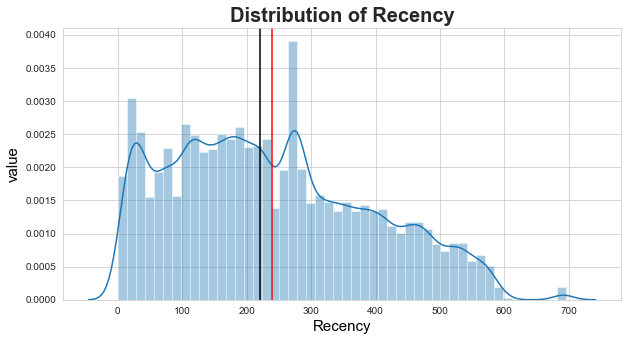

Mean of recency:  238.73377297631671
Median of recency:  220.0
Skewness of recency:  0.43585883202493925


In [176]:
plt.figure(figsize = (10, 5))
sns.distplot(rfm.Recency)
plt.axvline(rfm.Recency.mean(), c = 'red')
plt.axvline(rfm.Recency.median(), c = 'black')
plt.title('Distribution of Recency',fontweight='bold',fontsize=20)
plt.xlabel('Recency',fontsize=15,color='black')
plt.ylabel('value',fontsize=15,color='black')
plt.show()
print('Mean of recency: ', rfm.Recency.mean())
print('Median of recency: ', rfm.Recency.median())
print('Skewness of recency: ', rfm.Recency.skew())

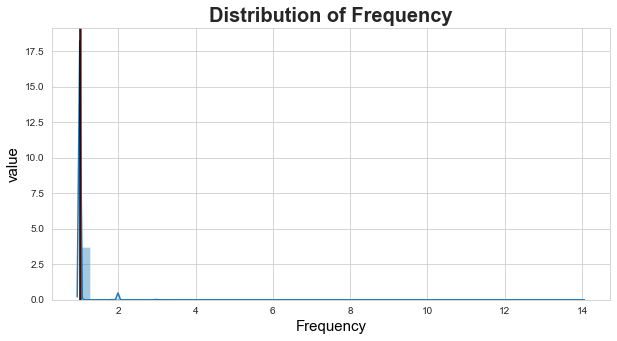

Mean of frequency:  1.0328958996111701
Median of frequency:  1.0
Skewness of frequency:  10.676600298052568


In [177]:
plt.figure(figsize = (10, 5))
sns.distplot(rfm.Frequency)
plt.axvline(rfm.Frequency.mean(), c = 'red')
plt.axvline(rfm.Frequency.median(), c = 'black')
plt.title('Distribution of Frequency',fontweight='bold',fontsize=20)
plt.xlabel('Frequency',fontsize=15,color='black')
plt.ylabel('value',fontsize=15,color='black')
plt.show()
print('Mean of frequency: ', rfm.Frequency.mean())
print('Median of frequency: ', rfm.Frequency.median())
print('Skewness of frequency: ', rfm.Frequency.skew())

In [178]:
Q1 = np.quantile(rfm.Frequency, 0.25)
Q3 = np.quantile(rfm.Frequency, 0.75)
IQR = Q3 - Q1
frequencyDistribution = rfm[~((rfm.Frequency < Q1 - 1.5 * IQR) | (rfm.Frequency > Q3 + 1.5 * IQR))]
frequencyDistribution.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
2  0000f46a3911fa3c0805444483337064      537          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89

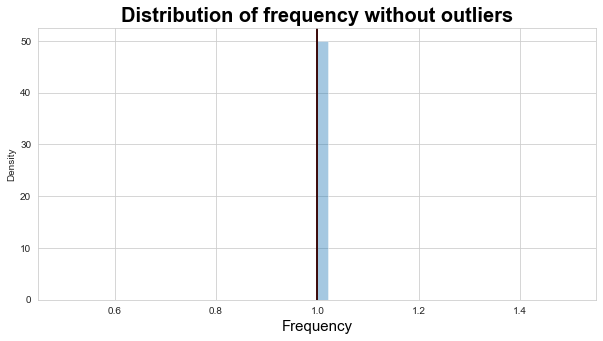

In [179]:
plt.figure(figsize=(10, 5))
sns.distplot(frequencyDistribution.Frequency)
plt.axvline(frequencyDistribution.Frequency.mean(), c = 'red')
plt.axvline(frequencyDistribution.Frequency.median(), c = 'black')
plt.xlabel('Frequency',color='black',fontsize=15)
plt.title('Distribution of frequency without outliers',color='black',fontsize=20,fontweight='bold')
plt.show()

In [180]:
frequencyDistribution.Frequency.describe()

count    87850.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: Frequency, dtype: float64

**Observations:**
1. The **frequency** from RFM analysis without outliers has a **standard deviation of 0**, that is, **all the values are only 1**. 
2. So the **frequency will not help in our analysis** and also to segment the customers. 

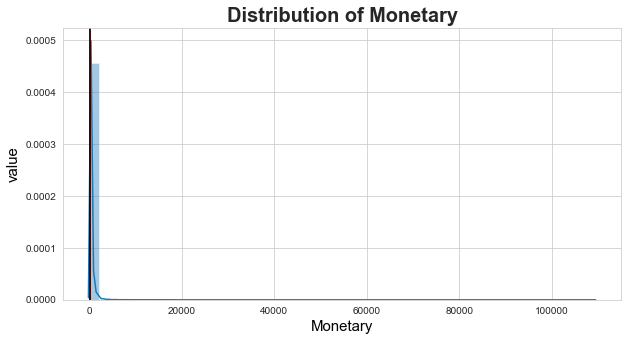

Mean of monetary:  212.23630898727467
Median of monetary:  112.83
Skewness of monetary:  70.4949829190865


In [181]:
plt.figure(figsize = (10, 5))
sns.distplot(rfm.Monetary)
plt.axvline(rfm.Monetary.mean(), c = 'red')
plt.axvline(rfm.Monetary.median(), c = 'black')
plt.title('Distribution of Monetary',fontweight='bold',fontsize=20)
plt.xlabel('Monetary',fontsize=15,color='black')
plt.ylabel('value',fontsize=15,color='black')
plt.show()
print('Mean of monetary: ', rfm.Monetary.mean())
print('Median of monetary: ', rfm.Monetary.median())
print('Skewness of monetary: ', rfm.Monetary.skew())

In [182]:
Q1 = np.quantile(rfm.Monetary, 0.25)
Q3 = np.quantile(rfm.Monetary, 0.75)
IQR = Q3 - Q1
monetaryDistribution = rfm[~((rfm.Monetary < Q1 - 1.5 * IQR) | (rfm.Monetary > Q3 + 1.5 * IQR))]
monetaryDistribution.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
2  0000f46a3911fa3c0805444483337064      537          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89

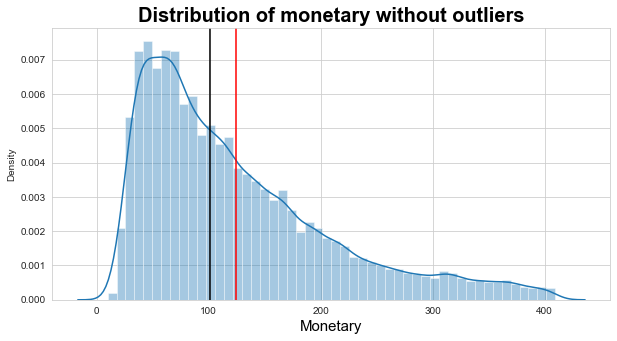

In [183]:
plt.figure(figsize=(10, 5))
sns.distplot(monetaryDistribution.Monetary)
plt.axvline(monetaryDistribution.Monetary.mean(), c = 'red')
plt.axvline(monetaryDistribution.Monetary.median(), c = 'black')
plt.xlabel('Monetary',color='black',fontsize=15)
plt.title('Distribution of monetary without outliers',color='black',fontsize=20,fontweight='bold')
plt.show()

In [184]:
monetaryDistribution.Monetary.describe()

count    81643.000000
mean       124.744198
std         85.108001
min          9.590000
25%         60.000000
50%        101.220000
75%        166.710000
max        409.610000
Name: Monetary, dtype: float64

**Observations:**
1. The average monetary value after outlier treatement is **124.74 Brazilian Real**, while the median value is **101.25 Brazilian Real**. 
2. The middle 50% of values of monetary lie between **60 and 166.71 Brazilian Real**. 

<a id="seg"></a>
# 8. Customer Segmentation

<a id="lare"></a>
## 8.1. Labels for Recency

In [185]:
ll_r = rfm.Recency.quantile(0.25)
mid_r = rfm.Recency.quantile(0.50)
ul_r = rfm.Recency.quantile(0.75)
print(ll_r, mid_r, ul_r)

115.0 220.0 347.0


In [186]:
def recency_label(recent):
    if recent <= ll_r:
        return 1
    elif (recent > ll_r) and (recent <= mid_r):
        return 2
    elif (recent > mid_r) and (recent <= ul_r):
        return 3
    elif recent > ul_r:
        return 4

In [187]:
rfm['recency_label'] = rfm.Recency.apply(recency_label)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19   
2  0000f46a3911fa3c0805444483337064      537          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89   

   recency_label  
0              1  
1              1  
2              4  
3              3  
4              3

**Recency label breakdown:**<br>
1 - These are the customers who whose visit date(s) are the most recent. (Recency value within the 25% quantile)<br>
2 - These are the customers who whose visit date(s) are not very recent. (Recency value between 25% and 50% quantile)<br>
3 - These are the customers who whose visit date(s) are somewhat recent. (Recency value between 50% and 75% quantile)<br>
4 - These are the customers who whose visit date(s) are the oldest. (Recency value more than 75% quantile)

<a id="lamy"></a>
## 8.2. Labels for Monetary

In [188]:
ll_m = rfm.Monetary.quantile(0.25)
mid_m = rfm.Monetary.quantile(0.50)
ul_m = rfm.Monetary.quantile(0.75)
print(ll_m, mid_m, ul_m)

63.79 112.83 202.1225


In [189]:
def monetary_label(money):
    if money <= ll_m:
        return 4
    elif (money > ll_m) and (money <= mid_m):
        return 3
    elif (money > mid_m) and (money <= ul_m):
        return 2
    elif money > ul_m:
        return 1

In [190]:
rfm['monetary_label'] = rfm.Monetary.apply(monetary_label)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19   
2  0000f46a3911fa3c0805444483337064      537          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89   

   recency_label  monetary_label  
0              1               2  
1              1               4  
2              4               3  
3              3               4  
4              3               2

**Monetary label breakdown:**<br>
1 - These are the customers who spend large amount. (Monetary value within the 25% quantile)<br>
2 - These are the customers who spend good amount. (Monetary value between 25% and 50% quantile)<br>
3 - These are the customers who spend moderately. (Monetary value between 50% and 75% quantile)<br>
4 - These are the customers who spend the least. (Monetary value more than 75% quantile)

<a id="lafr"></a>
## 8.3. Labels for Frequency

In [191]:
rfm.Frequency.value_counts()

1     87850
2      2462
3       171
4        28
5         9
6         3
7         3
9         1
14        1
Name: Frequency, dtype: int64

In [192]:
def frequency_label(frequent):
    if frequent == 1:
        return 4
    elif frequent == 2:
        return 3
    elif frequent == 3:
        return 2
    elif frequent > 3:
        return 1

In [193]:
rfm['frequency_label'] = rfm.Frequency.apply(frequency_label)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19   
2  0000f46a3911fa3c0805444483337064      537          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89   

   recency_label  monetary_label  frequency_label  
0              1               2                4  
1              1               4                4  
2              4               3                4  
3              3               4                4  
4              3               2                4

**Frequency label breakdown:**<br>
1 - These are the most frequent customers. (Frequency > 3)<br>
2 - These are the frequent frequent customers. (Frequency = 3)<br>
3 - These are the somewhat frequent customers. (Frequency = 2)<br>
4 - These are the least frequent customers. (Frequency = 1)

In [194]:
rfm['Rank'] = list(zip(rfm.recency_label, rfm.monetary_label, rfm.frequency_label))
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19   
2  0000f46a3911fa3c0805444483337064      537          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89   

   recency_label  monetary_label  frequency_label       Rank  
0              1               2                4  (1, 2, 4)  
1              1               4                4  (1, 4, 4)  
2              4               3                4  (4, 3, 4)  
3              3               4                4  (3, 4, 4)  
4              3               2                4  (3, 2, 4)

In [195]:
rfm.recency_label.value_counts()

1    22754
4    22595
3    22594
2    22585
Name: recency_label, dtype: int64

In [196]:
rfm.frequency_label.value_counts()

4    87850
3     2462
2      171
1       45
Name: frequency_label, dtype: int64

In [197]:
rfm.monetary_label.value_counts()

4    22637
1    22632
2    22630
3    22629
Name: monetary_label, dtype: int64

**Observation:**
1. Since **most of the frequency class is 4**, we will use only **recency and monetary for customer segmentation**. 

In [198]:
rfm['rank_rm'] = list(zip(rfm.recency_label, rfm.monetary_label))
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19   
2  0000f46a3911fa3c0805444483337064      537          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89   

   recency_label  monetary_label  frequency_label       Rank rank_rm  
0              1               2                4  (1, 2, 4)  (1, 2)  
1              1               4                4  (1, 4, 4)  (1, 4)  
2              4               3                4  (4, 3, 4)  (4, 3)  
3              3               4                4  (3, 4, 4)  (3, 4)  
4              3               2                4  (3, 2, 4)  (3, 2)

In [199]:
rfm.rank_rm.value_counts()

(1, 2)    5867
(3, 3)    5837
(4, 3)    5835
(1, 1)    5793
(2, 4)    5745
(4, 4)    5723
(2, 2)    5701
(3, 1)    5664
(2, 1)    5644
(1, 4)    5632
(3, 2)    5556
(3, 4)    5537
(4, 1)    5531
(4, 2)    5506
(2, 3)    5495
(1, 3)    5462
Name: rank_rm, dtype: int64

<a id="ranking"></a>
## 8.4. Meaning of ranks:
### The most important and least important customers (Recency Rank, Monetary Rank):
- Comparing Recency and Monetary - Recency rank is of higher importance than Monetary rank

### The most important ranks:
1. (Recency - 1, Monetary - 1) - They are very recent and have spend a lot of money
2. (Recency - 1, Monetary - 2) - They are very recent and have spend a good amount of money
3. (Recency - 2, Monetary - 1) - They are recent and have spend a lot of money
4. (Recency - 2, Monetary - 2) - They are recent and have spend a good of money
5. (Recency - 1, Monetary - 3) - They are very recent and have spend a decent of money

### The least important ranks:
1. (Recency - 4, Monetary - 4) - They are not at all recent and spend a negligible amount of money
2. (Recency - 4, Monetary - 3) - They are not at all recent and spend a a decent amount of money
3. (Recency - 4, Monetary - 2) - They are not at all recent and spend a good amount of money
4. (Recency - 3, Monetary - 4) - They are not very recent and spend a negligible amount of money
5. (Recency - 3, Monetary - 3) - They are not very recent and spend a decent amount of money

<a id="insights"></a>
## 8.5. Business Insights from RM analysis

**Insights from Recency Ranks:**
1. Customers can be incentivised to purchase more in our store using offers/discounts/events which will make them more recent and at the same time bring in more money
2. Customers will use our store if the website is user-friendly and quick. This will help make the customer's shopping experience smooth meaning they will continue coming back to our store/website for their purchasing needs
3. When advertising using digital marketing techniques:
    - Customers who have a low recency ranks should be targeted less or removed from advertisement lists as it will not bring as much or even returns/sales (This can also be done using customer's time spent on website but that will be for a future project)
    - Customers who have high recency ranks should be targeted more extensively as it will bring a lot of sales in return

**Insights from Monetary Ranks:**
1. Customer's monetary values can be increased with a better algorithm which will recommend similar/useful items when an item is added to cart

**Insights from Frequency Ranks:**<br>
97% (89100 out of 91832) of the customers have the lowest frequency rank (4) meaning they are very infrequent in their purchases. In order to combat this:-
1. Local language can be used in the ecommerce platform/store
2. Extend special offers for repeated purchases
3. Encourage Loyalty programs
4. Lower the Product Pricing for Increased Customer Frequency

<a id="target"></a>
# 9. Creating a target variable

In [200]:
rfm['Churn'] = rfm.Recency.apply(lambda x: 1 if x > rfm.Recency.mean() else 0)
rfm.head()

customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19   
2  0000f46a3911fa3c0805444483337064      537          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89   

   recency_label  monetary_label  frequency_label       Rank rank_rm  Churn  
0              1               2                4  (1, 2, 4)  (1, 2)      0  
1              1               4                4  (1, 4, 4)  (1, 4)      0  
2              4               3                4  (4, 3, 4)  (4, 3)      1  
3              3               4                4  (3, 4, 4)  (3, 4)      1  
4              3               2                4  (3, 2, 4)  (3, 2)      1

**Observations:**
1. The **churn rate**, also known as the **rate of attrition** or customer churn, is the **rate at which customers stop doing business with an entity**. 
2. We used the **recency column to frame the target variable**. If the **customer's recency falls above the average** value of recency, we consider such customers as **churned**. The **rest of the customers** as **not churned**.
3. We used the **mean of recency as the threshold** as the **recency is normally** or symmetrically distributed. 
4. We will have to **impute the target variable to the main dataframe** and do the further classification algorithm.

<a id="finaldf"></a>
# 10. Merging the target variable with our final dataframe

In [201]:
final = final.merge(rfm[['customer_unique_id', 'Recency', 'Monetary', 'Frequency', 'Churn']], on = 'customer_unique_id')
final.head()

customer_unique_id customer_zip_code_prefix customer_city  \
0  0000366f3b9a7992bf8c76cfdf3221e2                     7787       cajamar   
1  0000b849f77a49e4a4ce2b2a4ca5be3f                     6053        osasco   
2  0000f46a3911fa3c0805444483337064                    88115      sao jose   
3  0000f6ccb0745a6a4b88665a16c9f078                    66812         belem   
4  0004aac84e0df4da2b147fca70cf8255                    18040      sorocaba   

  customer_state  no_of_orders  purchased_approved  delivered_estimated  \
0             SP             1               891.0                    4   
1             SP             1             26057.0                    4   
2             SC             1                 0.0                    1   
3             PA             1              1176.0                   11   
4             SP             1              1270.0                    7   

   purchased_delivered  no_of_products   price  freight_value  \
0                  6.0               1  129.90          12.00   
1                  3.0               1   18.90           8.29   
2                 25.0               1   69.00          17.22   
3                 20.0               1   25.99          17.63   
4                 13.0               1  180.00          16.89   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0            1500.0               34.0                7.0              32.0   
1             375.0               26.0               11.0              18.0   
2            1500.0               25.0               50.0              35.0   
3             150.0               19.0                5.0              11.0   
4            6050.0               16.0                3.0              11.0   

   geolocation_lat  geolocation_lng payment_type  payment_installments  \
0       -23.333580       -46.823060  credit_card                     8   
1       -23.545029       -46.781482  credit_card                     1   
2       -27.532246       -48.618667  credit_card                     8   
3        -1.304189       -48.476339  credit_card                     4   
4       -23.496567       -47.462811  credit_card                     6   

   payment_value  review_score  Recency  Monetary  Frequency  Churn  
0         141.90           5.0      111    141.90          1      0  
1          27.19           NaN      114     27.19          1      0  
2          86.22           NaN      537     86.22          1      1  
3          43.62           NaN      321     43.62          1      1  
4         196.89           NaN      288    196.89          1      1

In [202]:
records, features = final.shape
print('Total number of unique records: ', records)
print('Total number of features: ', features)

Total number of unique records:  90528
Total number of features:  25


In [203]:
final['Churn'] = final.Churn.astype('object')

<a id="out"></a>
# 11. Outlier Treatement

Skewness of no_of_orders: 10.676600298052568
Standard deviation of no_of_orders: 0.20649360862515379


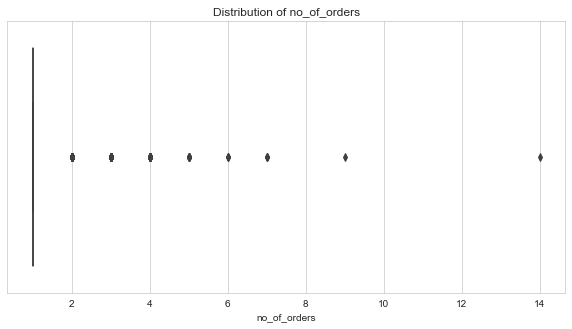

Skewness of purchased_approved: 1.6936517976235201
Standard deviation of purchased_approved: 23397.78777997723


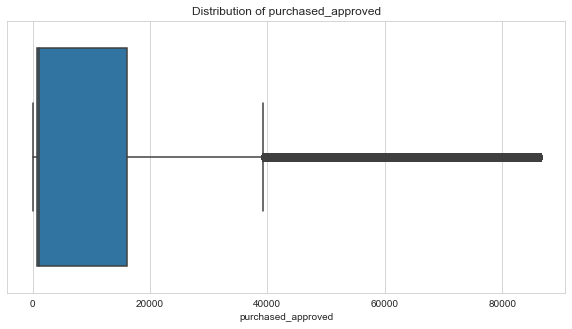

Skewness of delivered_estimated: -2.101764866389134
Standard deviation of delivered_estimated: 10.203242967047574


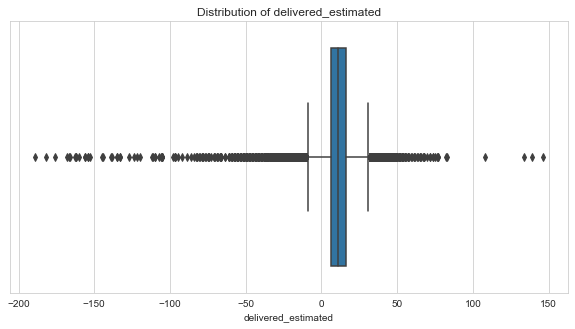

Skewness of purchased_delivered: 3.885615578737388
Standard deviation of purchased_delivered: 9.567765067053164


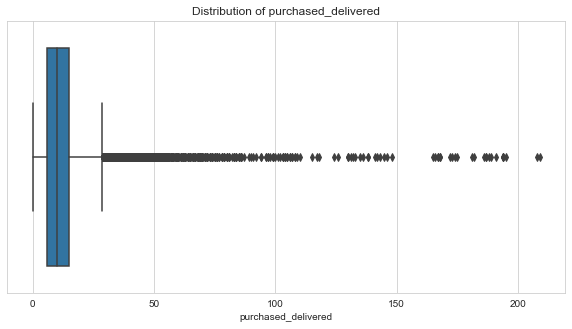

Skewness of no_of_products: 7.414378109080429
Standard deviation of no_of_products: 0.31373679944656546


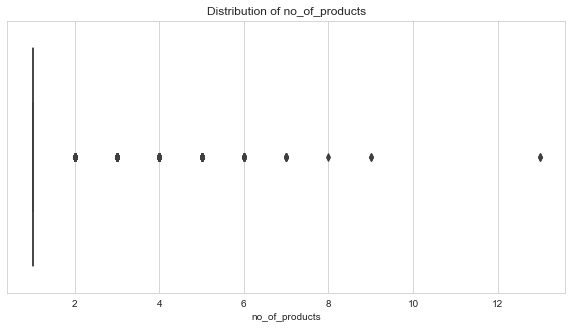

Skewness of price: 11.791837108894033
Standard deviation of price: 244.2877497694806


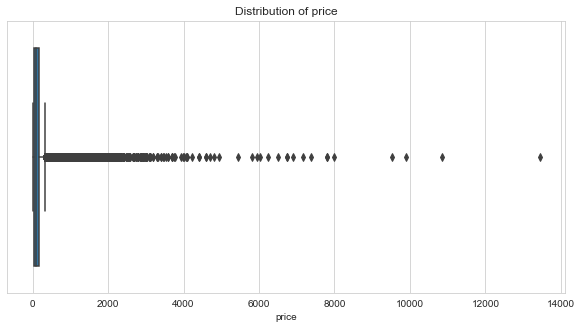

Skewness of freight_value: 13.696046608723156
Standard deviation of freight_value: 26.890560470727753


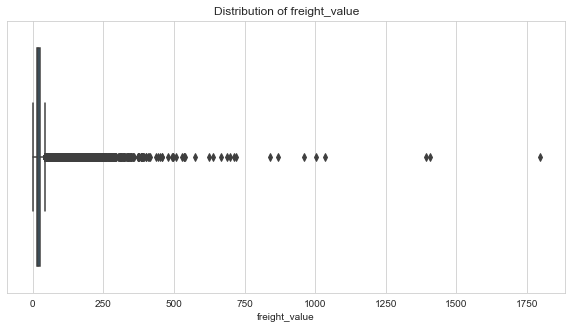

Skewness of product_weight_g: 12.131479466882134
Standard deviation of product_weight_g: 5812.31317595522


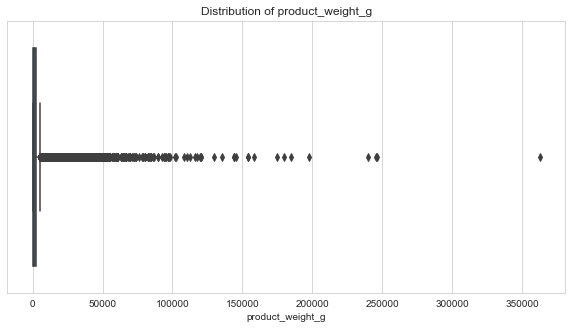

Skewness of product_length_cm: 16.000317045845396
Standard deviation of product_length_cm: 35.43155752809726


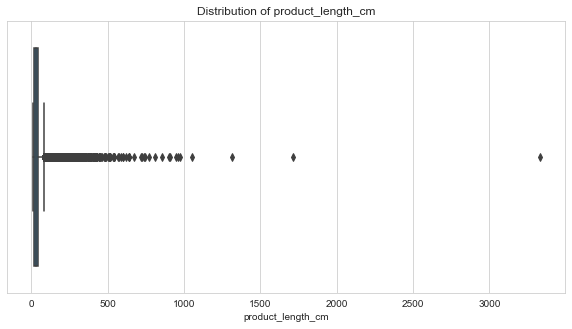

Skewness of product_height_cm: 14.445872079638715
Standard deviation of product_height_cm: 25.187955183905892


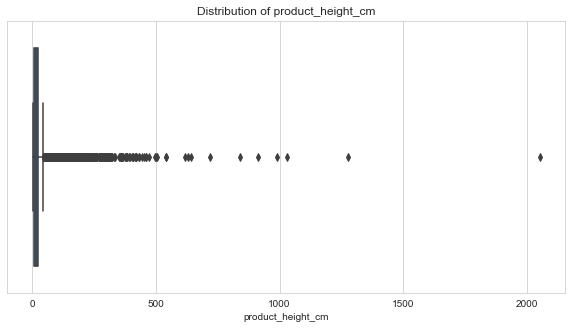

Skewness of product_width_cm: 16.47431670120788
Standard deviation of product_width_cm: 26.235366771942363


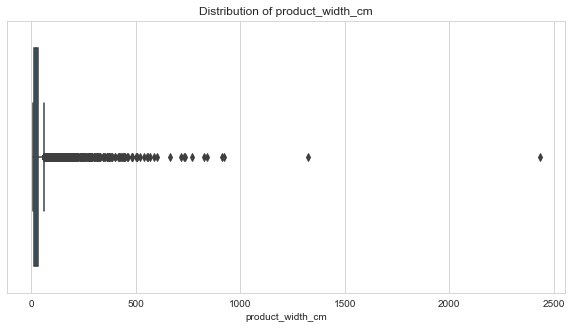

Skewness of geolocation_lat: 1.7731522011144614
Standard deviation of geolocation_lat: 5.683911480427566


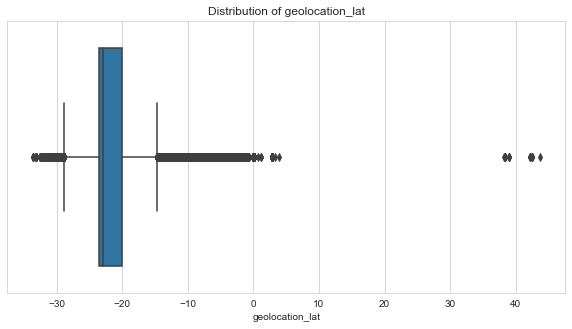

Skewness of geolocation_lng: 0.18920688857939136
Standard deviation of geolocation_lng: 4.095579090984395


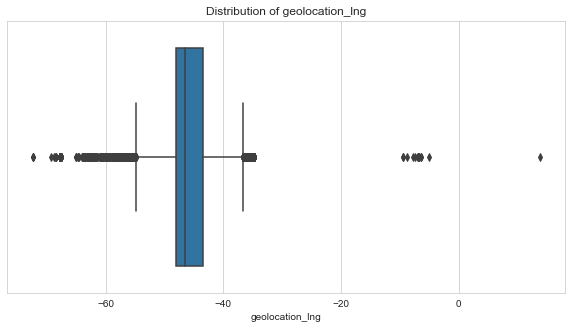

Skewness of payment_installments: 1.5985424567820286
Standard deviation of payment_installments: 2.7284629737523685


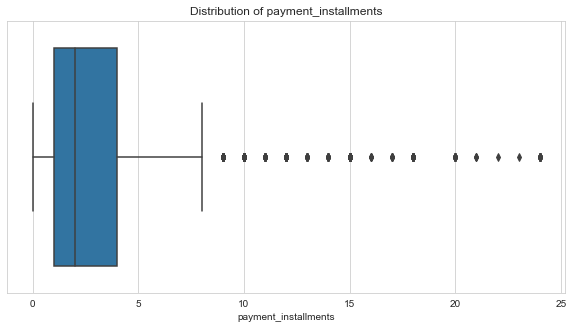

Skewness of payment_value: 70.4949829190865
Standard deviation of payment_value: 647.5936527572555


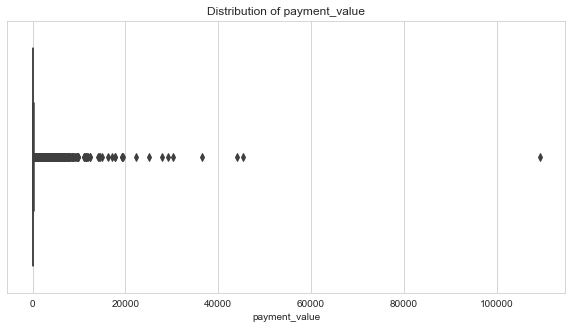

Skewness of review_score: -1.0689366055733671
Standard deviation of review_score: 1.50818532419873


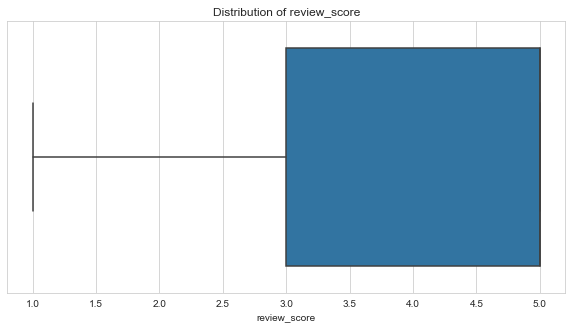

Skewness of Recency: 0.43585883202493925
Standard deviation of Recency: 152.38669351591855


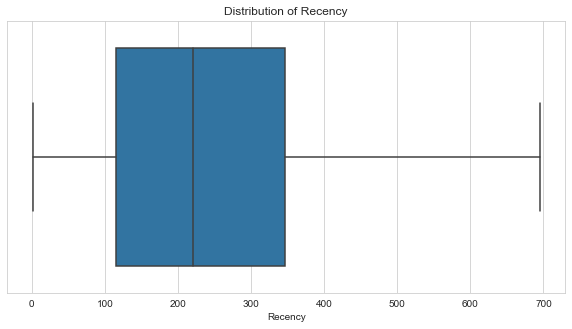

Skewness of Monetary: 70.4949829190865
Standard deviation of Monetary: 647.5936527572555


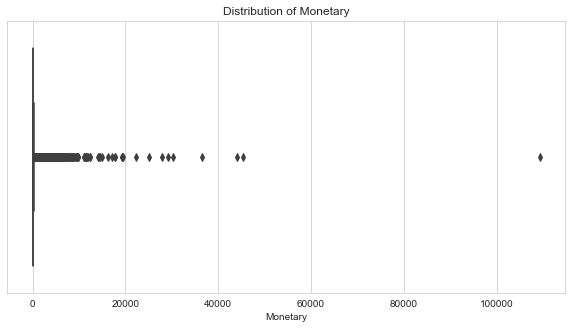

Skewness of Frequency: 10.676600298052568
Standard deviation of Frequency: 0.20649360862515379


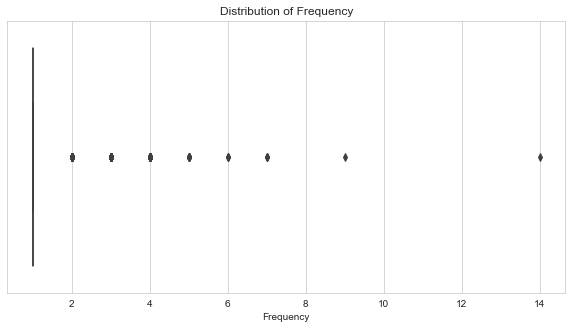

In [204]:
for col in final.select_dtypes(include = np.number).columns:
    plt.figure(figsize = (10, 5))
    print(f'Skewness of {col}: {final[col].skew()}')
    print(f'Standard deviation of {col}: {final[col].std()}')
    sns.boxplot(final[col])
    plt.title(f'Distribution of {col}')
    plt.show()

In [205]:
final.drop(columns = ['customer_zip_code_prefix', 'no_of_orders', 'no_of_products', 'Frequency'], axis = 1, inplace = True)

**Observation:**
1. Since the columns `no_of_orders`, `no_of_products` and `Frequency` has **standard deviation almost equal to 0**, we are **dropping those columns**, as it would **not add value to the model building**. 

In [206]:
final_outlierTreated = final.copy()

In [207]:
for i in final_outlierTreated.select_dtypes(include = np.number).columns:
    q1 = final_outlierTreated[i].quantile(0.25)
    q3 = final_outlierTreated[i].quantile(0.75)
    iqr = q3 - q1
    ul = q3 + 1.5*iqr
    ll = q1 - 1.5*iqr
    final_outlierTreated[i] = np.where(final_outlierTreated[i]>ul,ul,final_outlierTreated[i])
    final_outlierTreated[i] = np.where(final_outlierTreated[i]<ll,ll,final_outlierTreated[i])

Skewness of purchased_approved: 1.216427542911808
Standard deviation of purchased_approved: 15172.739925538926


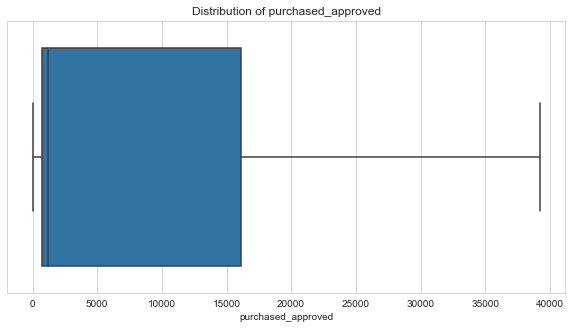

Skewness of delivered_estimated: -0.09874592372345704
Standard deviation of delivered_estimated: 8.27409624934651


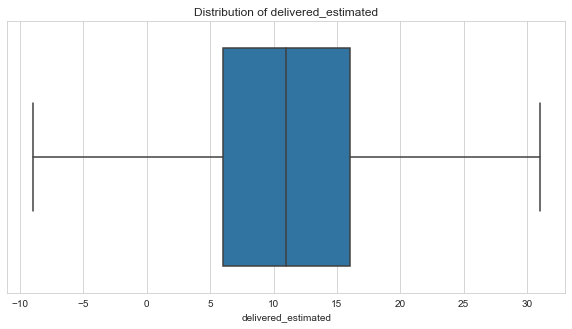

Skewness of purchased_delivered: 0.8756697985741126
Standard deviation of purchased_delivered: 7.1153096913632865


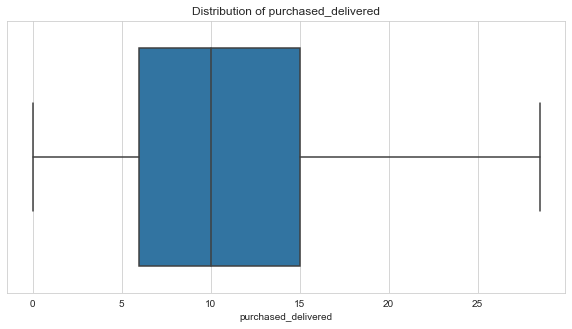

Skewness of price: 1.0621689422971194
Standard deviation of price: 92.20044361066165


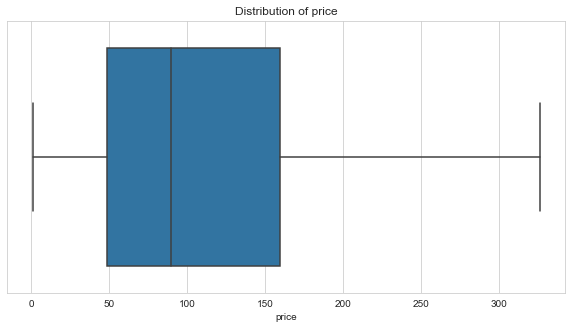

Skewness of freight_value: 0.9844226195345266
Standard deviation of freight_value: 11.097659947870035


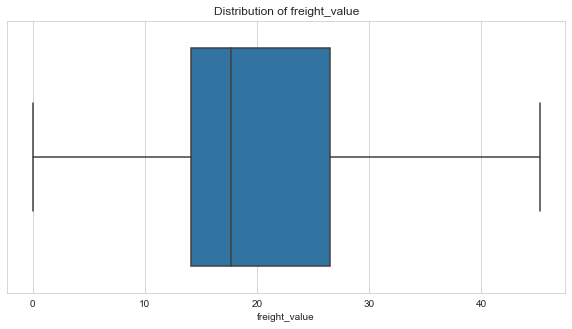

Skewness of product_weight_g: 1.184708672928979
Standard deviation of product_weight_g: 1768.5773964327332


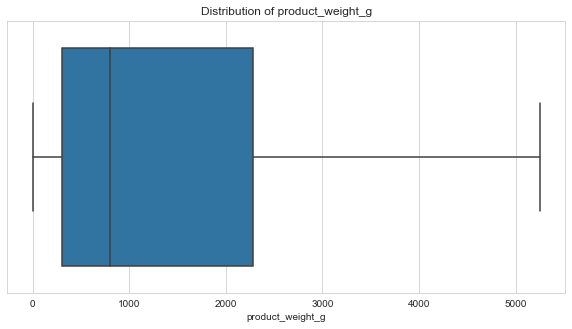

Skewness of product_length_cm: 1.0917311795460445
Standard deviation of product_length_cm: 18.78532590013228


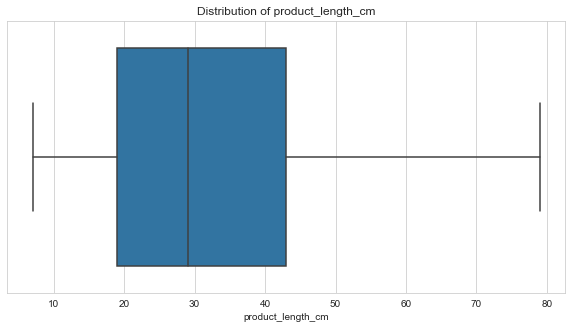

Skewness of product_height_cm: 0.9828445611757387
Standard deviation of product_height_cm: 12.625083800218338


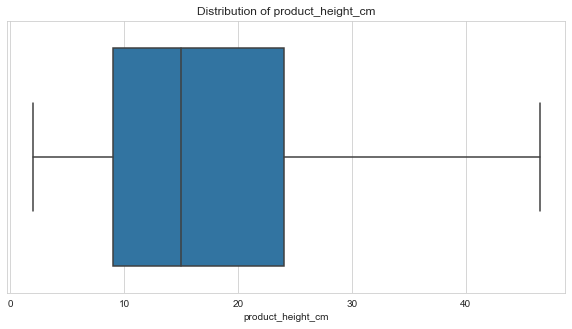

Skewness of product_width_cm: 1.125375095461402
Standard deviation of product_width_cm: 14.460754794476287


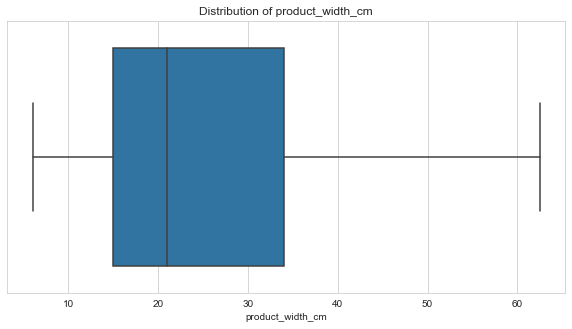

Skewness of geolocation_lat: 0.5304176813724053
Standard deviation of geolocation_lat: 3.670463249603015


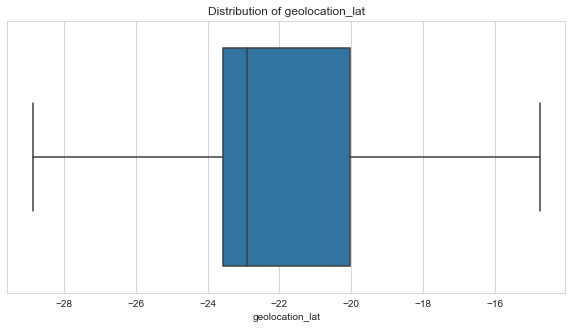

Skewness of geolocation_lng: 0.2797774883012845
Standard deviation of geolocation_lng: 3.8012245383733556


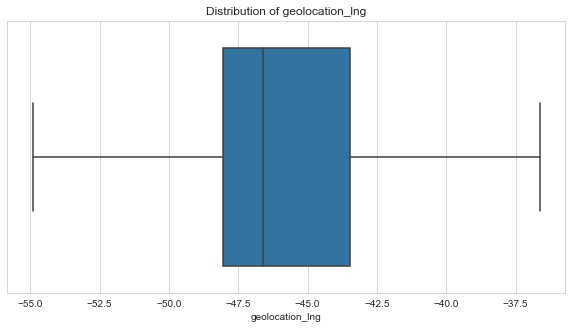

Skewness of payment_installments: 1.2118688690198518
Standard deviation of payment_installments: 2.439670722077591


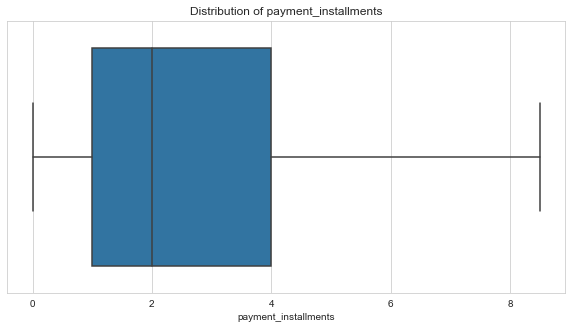

Skewness of payment_value: 1.0925860647703838
Standard deviation of payment_value: 117.11471507512717


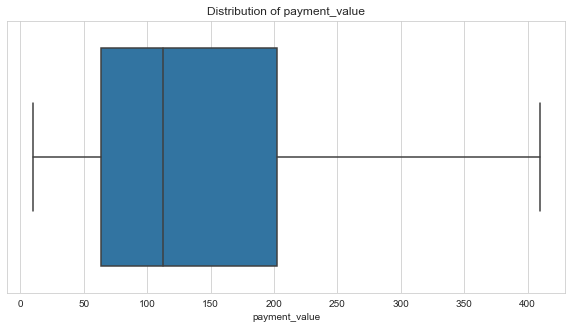

Skewness of review_score: -1.0689366055733671
Standard deviation of review_score: 1.50818532419873


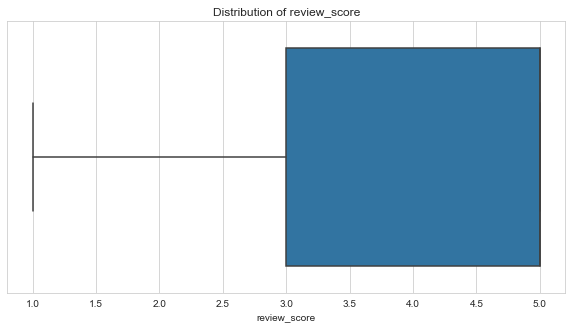

Skewness of Recency: 0.43585883202493925
Standard deviation of Recency: 152.38669351591855


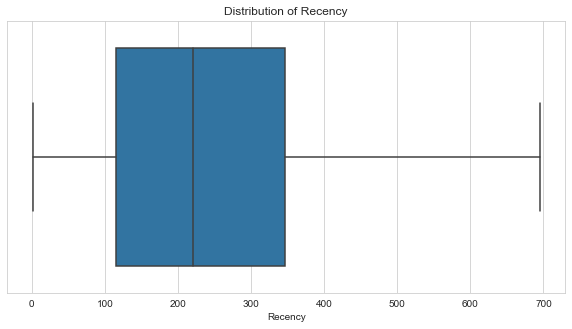

Skewness of Monetary: 1.0925860647703838
Standard deviation of Monetary: 117.11471507512717


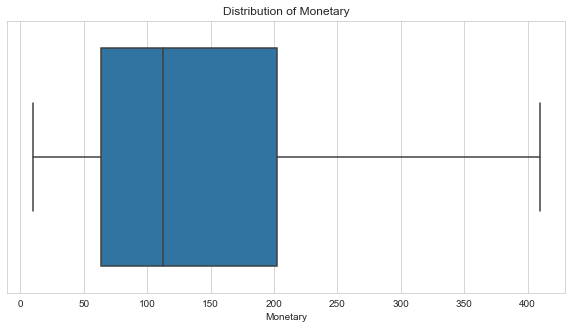

In [208]:
for col in final_outlierTreated.select_dtypes(include = np.number).columns:
    plt.figure(figsize = (10, 5))
    print(f'Skewness of {col}: {final_outlierTreated[col].skew()}')
    print(f'Standard deviation of {col}: {final_outlierTreated[col].std()}')
    sns.boxplot(final_outlierTreated[col])
    plt.title(f'Distribution of {col}')
    plt.show()

In [209]:
final_outlierTreated.shape

(90528, 21)

**Observations:**
1. The outliers are treated by the method of **capping**. 
2. Values which fall outside of the upper and lower whisker are capped to the upper and lower whisker values respectively. 
3. Since **dropping the values** would lead to **loss of huge volumes of data**, we prefer to cap the values.

<a id="miss"></a>
# 12. Missing Value Treatement

In [210]:
final_outlierTreated.isna().sum() / len(final) * 100

customer_unique_id       0.000000
customer_city            0.000000
customer_state           0.000000
purchased_approved       0.000000
delivered_estimated      0.000000
purchased_delivered      0.000000
price                    0.000000
freight_value            0.000000
product_weight_g         0.000000
product_length_cm        0.000000
product_height_cm        0.000000
product_width_cm         0.000000
geolocation_lat          0.000000
geolocation_lng          0.000000
payment_type             0.000000
payment_installments     0.000000
payment_value            0.000000
review_score            90.099196
Recency                  0.000000
Monetary                 0.000000
Churn                    0.000000
dtype: float64

In [211]:
final_outlierTreated.drop(columns = ['review_score'], axis = 1, inplace = True)

**Observation:**
1. Since more than **85%** of values are missing in the `review_score` feature, we are **dropping the column**. 

<a id="edafinal"></a>
# 13. Multi-variate Analysis

<a id="targetImbalance"></a>
## 13.1. Target imbalance

In [212]:
final_outlierTreated.Churn.value_counts(normalize = True) * 100

0    54.591949
1    45.408051
Name: Churn, dtype: float64

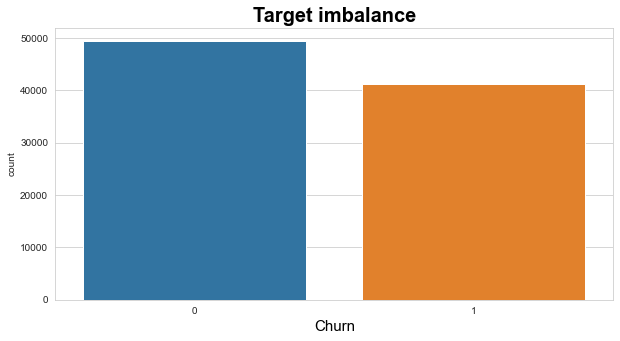

In [213]:
plt.figure(figsize=(10, 5))
sns.countplot(final_outlierTreated.Churn)
plt.xlabel('Churn',color='black',fontsize=15)
plt.title('Target imbalance',color='black',fontsize=20,fontweight='bold')
plt.show()

**Observation:**
1. **Target variable is balanced**. So we **do not require upsampling** of the data using SMOTE. 

<a id="multivariate"></a>
## 13.2. Multivariate Analysis

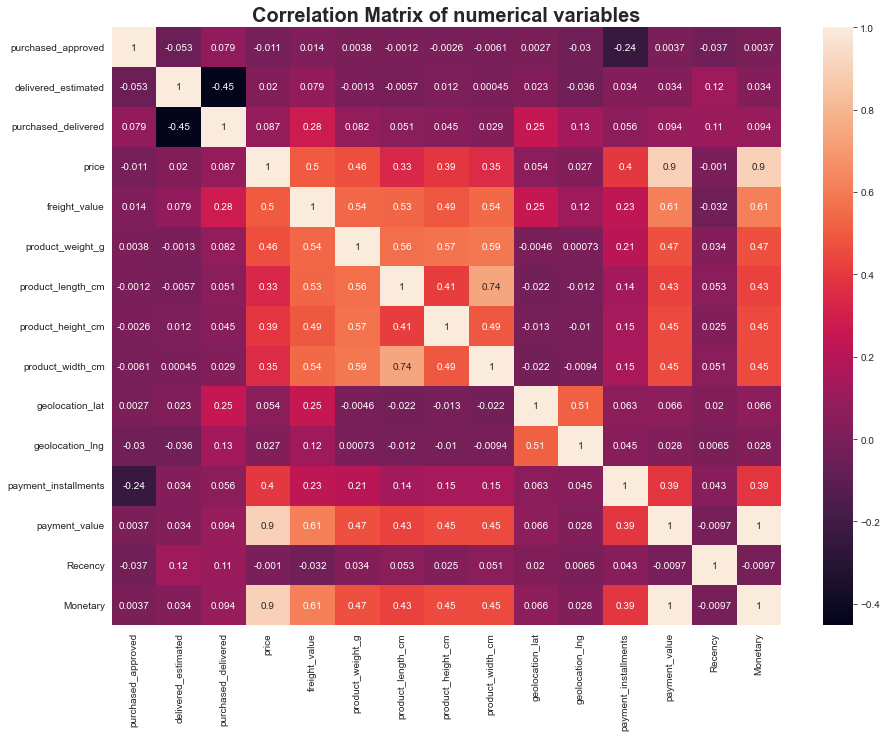

In [214]:
plt.figure(figsize=(15,11))
sns.heatmap(final_outlierTreated.corr(), annot = True)
plt.title('Correlation Matrix of numerical variables',fontsize=20,fontweight='bold')
plt.show()

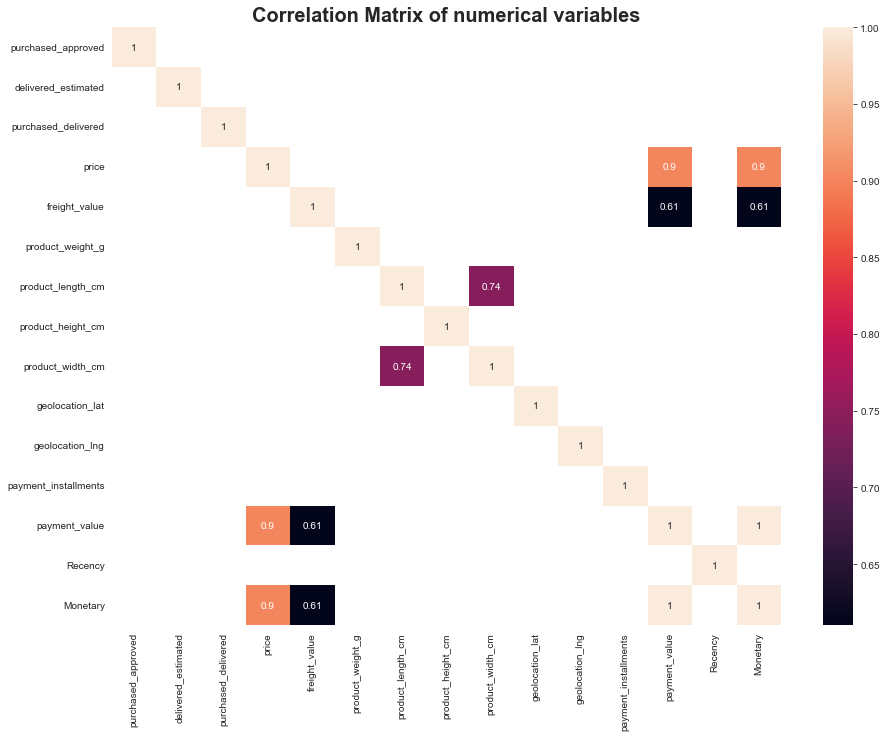

In [215]:
plt.figure(figsize=(15,11))
sns.heatmap(final_outlierTreated.corr()[final_outlierTreated.corr() > 0.6], annot = True)
plt.title('Correlation Matrix of numerical variables',fontsize=20,fontweight='bold')
plt.show()

**Observations:**
1. The above heatmap of the correlation coefficients between numerical variables shows which variables are moderately to highly correlated between themselves. 
2. `product_width_cm` is **fairly correlated** with `product_length_cm`.
3. `freight_value` is **fairly correlated** with `Monetary` and `payment_value`, which both are the same. This variable would cause multi-collinearity, so it must be removed. 
4. Similarly, `price` is **highly correlated** with `Monetary` and `payment_value`. 

<a id="stats"></a>
# 14. Statistical Tests

### Statistical test for categorical and categorical variables 
**Chi-Squared test for Independence** <br><br>
**Hypothesis**<br>
**Null Hypothesis, H0**: Variables are independent.<br>
**Alternate Hypothesis, Ha**: Variables are dependent.

In [216]:
def cat_cat(variable):
    dependent_variables = []
    independent_variables = []
    for var in variable:
        print(f'{var} and Churn')
        observed = pd.crosstab(final_outlierTreated[var], final_outlierTreated.Churn)
        chi_stats, pval, dof, expected = stats.chi2_contingency(observed)
        print('test statistics: ', chi_stats)
        print('p - value: ', pval)
        print('degrees of freedom: ', dof)
        if pval < 0.05:
            print(f'Reject Null Hypothesis. \nThe variables {var} and target variable, Churn are dependent.\n')
            dependent_variables.append(var)
        else:
            print(f'Failed to reject Null Hypothesis. \nThe variables {var} and target variable, Churn are independent.\n')
            independent_variables.append(var)
    print('Dependent variables: ', dependent_variables)
    print('Independent variables: ', independent_variables)
        
variable = ['customer_state', 'payment_type', 'payment_installments', 'customer_city']
cat_cat(variable)

customer_state and Churn
test statistics:  353.9562373606318
p - value:  2.9132771252108942e-59
degrees of freedom:  26
Reject Null Hypothesis. 
The variables customer_state and target variable, Churn are dependent.

payment_type and Churn
test statistics:  266.16944819672017
p - value:  2.0805608001059732e-57
degrees of freedom:  3
Reject Null Hypothesis. 
The variables payment_type and target variable, Churn are dependent.

payment_installments and Churn
test statistics:  489.01783336833216
p - value:  1.2904748666154383e-99
degrees of freedom:  9
Reject Null Hypothesis. 
The variables payment_installments and target variable, Churn are dependent.

customer_city and Churn
test statistics:  4523.939055252141
p - value:  1.8256365995978932e-08
degrees of freedom:  4011
Reject Null Hypothesis. 
The variables customer_city and target variable, Churn are dependent.

Dependent variables:  ['customer_state', 'payment_type', 'payment_installments', 'customer_city']
Independent variables:  []

### Statistical test for categorical and numerical variables 
**ANOVA test for Independence**<br><br>
**Hypothesis**<br>
**Null Hypothesis, H0**: Variables are not correlated with each other.<br>
**Alternate Hypothesis, Ha**: Variables are correlated with each other.

In [217]:
def num_cat(variable):
    correlated_variables = []
    noncorrelated_variables = []
    for var in variable:
        print(f'{var} Vs. target variable, Churn')
        churn = final[final.Churn == 1][var]
        not_churn = final[final.Churn == 0][var]
        test_stats, churn_pval = stats.shapiro(churn)
        test_stats, notchurn_pval = stats.shapiro(not_churn)
        if churn_pval < 0.05:
            print(f'churn of {var} is not normal')
        else: 
            print(f'churn of {var} is normal')
        if notchurn_pval < 0.05:
            print(f'not churn of {var} is not normal')
        else: 
            print(f'not churn of {var} is normal')
        levene_teststats, pval_levene = stats.levene(churn, not_churn)
        if pval_levene < 0.05:
            print(f'atleast one variance is not equal')
        else: 
            print(f'all variances are equal')
        anova_teststats, pval_anova = stats.f_oneway(churn, not_churn)
        if pval_anova < 0.05:
            print(f'Reject Null Hypothesis. \nThe variables {var} and target variable, Churn are correlated with each other.\n')
            correlated_variables.append(var)
        else:
            print(f'Failed to reject Null Hypothesis. \nThe variables {var} and target variable, Churn are not correlated with each other.\n')
            noncorrelated_variables.append(var)
            
    print('Correlated variables: ', correlated_variables)
    print('Non-correlated variables: ', noncorrelated_variables)

            
variable = ['purchased_approved', 'delivered_estimated', 'purchased_delivered', 'price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'geolocation_lat', 'geolocation_lng', 'Recency', 'Monetary']
num_cat(variable)

purchased_approved Vs. target variable, Churn
churn of purchased_approved is not normal
not churn of purchased_approved is not normal
atleast one variance is not equal
Reject Null Hypothesis. 
The variables purchased_approved and target variable, Churn are correlated with each other.

delivered_estimated Vs. target variable, Churn
churn of delivered_estimated is not normal
not churn of delivered_estimated is not normal
atleast one variance is not equal
Reject Null Hypothesis. 
The variables delivered_estimated and target variable, Churn are correlated with each other.

purchased_delivered Vs. target variable, Churn
churn of purchased_delivered is not normal
not churn of purchased_delivered is not normal
atleast one variance is not equal
Reject Null Hypothesis. 
The variables purchased_delivered and target variable, Churn are correlated with each other.

price Vs. target variable, Churn
churn of price is not normal
not churn of price is not normal
all variances are equal
Failed to rejec

In [218]:
def non_parametric_tests(variable):
    correlated_variables = []
    noncorrelated_variables = []
    for var in variable:
        test_stats, pval = stats.mannwhitneyu(final_outlierTreated[final_outlierTreated.Churn == 1][var], final_outlierTreated[final_outlierTreated.Churn == 0][var])
        if pval < 0.05:
            print(f'Reject Null Hypothesis. \nThe variables {var} and target variable, Churn are correlated with each other.\n')
            correlated_variables.append(var)
        else:
            print(f'Failed to reject Null Hypothesis. \nThe variables {var} and target variable, Churn are not correlated with each other.\n')
            noncorrelated_variables.append(var)
    print(f'Correlated variables: ', correlated_variables)
    print(f'Non correlated variables: ', noncorrelated_variables)
        
variable = ['purchased_approved', 'delivered_estimated', 'purchased_delivered', 'price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'geolocation_lat', 'geolocation_lng', 'Recency', 'Monetary']
non_parametric_tests(variable)

Reject Null Hypothesis. 
The variables purchased_approved and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables delivered_estimated and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables purchased_delivered and target variable, Churn are correlated with each other.

Failed to reject Null Hypothesis. 
The variables price and target variable, Churn are not correlated with each other.

Reject Null Hypothesis. 
The variables freight_value and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables product_weight_g and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables product_length_cm and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables product_height_cm and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables product_width_cm and ta

**Observations:**
1. **All the categorical variables** are **dependant** on the **target variable**. 
2. **The numerical variables**, which fail the normality test, when done non-parametric tests, are **all correlated** with the **target variable**, except for `price`. 

<a id="trans"></a>
# 15. Transformation of Data

In [219]:
transformed_data = final_outlierTreated.copy()
transformed_data['Churn'] = transformed_data['Churn'].astype('object')

In [220]:
transformed_data.skew()

purchased_approved      1.216428
delivered_estimated    -0.098746
purchased_delivered     0.875670
price                   1.062169
freight_value           0.984423
product_weight_g        1.184709
product_length_cm       1.091731
product_height_cm       0.982845
product_width_cm        1.125375
geolocation_lat         0.530418
geolocation_lng         0.279777
payment_installments    1.211869
payment_value           1.092586
Recency                 0.435859
Monetary                1.092586
Churn                   0.184461
dtype: float64

In [221]:
transformed_data.describe()

purchased_approved  delivered_estimated  purchased_delivered  \
count        90528.000000         90528.000000          90528.00000   
mean         10218.436257            10.918180             11.54482   
std          15172.739926             8.274096              7.11531   
min              0.000000            -9.000000              0.00000   
25%            756.000000             6.000000              6.00000   
50%           1164.000000            11.000000             10.00000   
75%          16142.250000            16.000000             15.00000   
max          39221.625000            31.000000             28.50000   

              price  freight_value  product_weight_g  product_length_cm  \
count  90528.000000   90528.000000      90528.000000       90528.000000   
mean     118.080877      21.391276       1627.081113          34.209084   
std       92.200444      11.097660       1768.577396          18.785326   
min        0.850000       0.000000          0.000000           7.000000   
25%       48.900000      14.100000        304.000000          19.000000   
50%       89.900000      17.670000        800.000000          29.000000   
75%      159.900000      26.550000       2283.000000          43.000000   
max      326.400000      45.225000       5251.500000          79.000000   

       product_height_cm  product_width_cm  geolocation_lat  geolocation_lng  \
count       90528.000000      90528.000000     90528.000000     90528.000000   
mean           18.046422         26.419865       -21.859878       -46.111407   
std            12.625084         14.460755         3.670463         3.801225   
min             2.000000          6.000000       -28.882827       -54.921403   
25%             9.000000         15.000000       -23.578469       -48.060327   
50%            15.000000         21.000000       -22.898404       -46.614879   
75%            24.000000         34.000000       -20.042230       -43.486277   
max            46.500000         62.500000       -14.737871       -36.625202   

       payment_installments  payment_value       Recency      Monetary  
count          90528.000000   90528.000000  90528.000000  90528.000000  
mean               2.837614     152.703864    238.733773    152.703864  
std                2.439671     117.114715    152.386694    117.114715  
min                0.000000       9.590000      1.000000      9.590000  
25%                1.000000      63.790000    115.000000     63.790000  
50%                2.000000     112.830000    220.000000    112.830000  
75%                4.000000     202.122500    347.000000    202.122500  
max                8.500000     409.621250    695.000000    409.621250

In [222]:
pt = PowerTransformer(method = 'yeo-johnson')
for var in transformed_data:
    if var in ['delivered_estimated','geolocation_lat','geolocation_lng']:
        transformed_data[var] = pt.fit_transform(transformed_data[[var]])

In [223]:
pt = PowerTransformer(method='box-cox')
for var in transformed_data.select_dtypes(include=np.number):
    if var not in ['delivered_estimated','geolocation_lat','geolocation_lng']:
        transformed_data[var] = pt.fit_transform(0.001 + transformed_data[[var]])

In [224]:
transformed_data.skew()

purchased_approved      0.136317
delivered_estimated     0.102573
purchased_delivered    -0.025024
price                  -0.029814
freight_value           0.177740
product_weight_g       -0.004216
product_length_cm       0.101678
product_height_cm      -0.033945
product_width_cm        0.070255
geolocation_lat         0.032696
geolocation_lng        -0.013325
payment_installments   -0.367193
payment_value          -0.000312
Recency                -0.161802
Monetary               -0.000312
Churn                   0.184461
dtype: float64

**Observations:**
1. The variables which have **negative values** are transformed using **yeo-johnson** method, as log of 0 or negative values would return infinite value. 
2. The variables which has **only positive values** in it are transformed using **box-cox** method. 

<a id="class"></a>
# 16. Classification Models

In [225]:
transformed_data.head()

customer_unique_id customer_city customer_state  \
0  0000366f3b9a7992bf8c76cfdf3221e2       cajamar             SP   
1  0000b849f77a49e4a4ce2b2a4ca5be3f        osasco             SP   
2  0000f46a3911fa3c0805444483337064      sao jose             SC   
3  0000f6ccb0745a6a4b88665a16c9f078         belem             PA   
4  0004aac84e0df4da2b147fca70cf8255      sorocaba             SP   

   purchased_approved  delivered_estimated  purchased_delivered     price  \
0           -0.579563            -0.866609            -0.725370  0.452317   
1            1.299464            -0.866609            -1.516359 -1.663291   
2           -3.569347            -1.214404             1.609794 -0.307908   
3           -0.452622            -0.016225             1.167662 -1.352995   
4           -0.416681            -0.506891             0.401717  0.872268   

   freight_value  product_weight_g  product_length_cm  product_height_cm  \
0      -0.869439          0.460791           0.378968          -0.913417   
1      -1.410467         -0.678234          -0.167282          -0.383337   
2      -0.258318          0.460791          -0.253514           1.750517   
3      -0.215367         -1.409315          -0.907027          -1.272156   
4      -0.293336          1.525512          -1.364730          -1.764051   

   product_width_cm  geolocation_lat  geolocation_lng payment_type  \
0          0.712075        -0.339009        -0.147663  credit_card   
1         -0.427525        -0.403676        -0.136448  credit_card   
2          0.867575        -1.742476        -0.641800  credit_card   
3         -1.629117         1.762773        -0.601932  credit_card   
4         -1.629117        -0.388799        -0.321518  credit_card   

   payment_installments  payment_value   Recency  Monetary Churn  
0              1.594216       0.278586 -0.750358  0.278586     0  
1             -0.934791      -1.840386 -0.724705 -1.840386     0  
2              1.594216      -0.360895  1.654413 -0.360895     1  
3              0.923510      -1.234730  0.630258 -1.234730     1  
4              1.333123       0.699222  0.449167  0.699222     1

In [227]:
transformed_data.to_csv("Fianl data for analysis.csv")

In [ ]:
def state_encoding(state):
    if state in ['RS', 'SC', 'PR']:
        return 'southern'
    elif state in ['SP', 'RJ', 'MG', 'ES']:
        return 'southeastern'
    elif state in ['MT', 'MS', 'GO', 'DF']:
        return 'centralwestern'
    elif state in ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA']:
        return 'northeastern'
    else: 
        return 'northern'

In [ ]:
transformed_data['customer_state'] = transformed_data['customer_state'].apply(state_encoding)

**Observation:**
1. Since the states are spread across the brazil, we are grouping the states based on the regions they are in, namely **southern**, **southeastern**, **centralwestern**, **northeastern** and **northern**. 

In [ ]:
features = transformed_data.copy()
features.head()

In [ ]:
features.drop(columns = ['customer_unique_id', 'customer_city', 'payment_value'], axis = 1, inplace = True)

**Observations:**
1. Since the `payment_value` feature is same as that of the `Monetary` feature, the former is dropped. 
2. Similarly, `customer_city` is a **multi-class feature**, so encoding it would be useless. So we drop the feature. 

In [ ]:
features.head(1)

In [ ]:
independent = features.drop(columns = ['Churn'], axis = 1)
df_numeric = independent.select_dtypes(include = np.number)
df_categorical = independent.select_dtypes(exclude = np.number)
df_target = features['Churn'].astype('int')

In [ ]:
encoded_data = pd.get_dummies(df_categorical, drop_first = True)

In [ ]:
X = pd.concat([df_numeric, encoded_data], axis = 1)
X.drop(columns = ['Recency'], axis = 1, inplace = True)

**Observation:**
1. The `Recency` feature is dropped for the model building, as it is **used to create the target variable**. Predictions would be 100% accurate if the `Recency` feature is not dropped, which would be a good model. 

<a id="traintest"></a>
## 16.1. Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), df_target, random_state = 500, test_size = 0.2)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

**Statistically proving train & test are good representations of overall data** <br>
A t-test independence on each column to show both have equal or similar representation.<br><br>
**Null Hypothesis, H0**: Both sets have same mean, thus they have equal representation.<br>
**Alternate Hypothesis, Ha**: Both sets have unequal means, thus unequal representation.<br>

In [ ]:
tstats,pvals = stats.ttest_ind(X_train, X_test)
ref_df = pd.DataFrame(pvals,index=X_train.columns,columns=['pvals'])
(ref_df < 0.05).any()

**Observation:**
1. As all the columns have **p-values greater than significance level of 0.05**, we **do not reject the null hypothesis** and  we can conclude that **all independent features are properly represented both in train and test sets**.

<a id="logit"></a>
## 16.2. Logit Regression

In [ ]:
logreg = sm.Logit(y_train, X_train).fit()
print(logreg.summary())

In [ ]:
print('Akaike information criterion (AIC):', logreg.aic)

**Observations:**
1. The Akaike Information Criteria (AIC) is a **relative measure of model evaluation** for a given dataset.
2. It is given by: **-2 ln(L) + 2K**, where, L - Log Likelihood, K - Parameters to be estimated.
3. The AIC gives a **trade-off between the model accuracy and model complexity**, i.e., it **prevents from overfitting**.

### Interpret the odds for each variable 

In [ ]:
logreg.params

In [ ]:
df_odds = pd.DataFrame(np.exp(logreg.params), columns= ['Odds']) 
df_odds

**Observations:** 
1. `const`: The **odds of customer churning** is **0.490694**, considering **all other variables take zero value**.
2. `purchased_delivered` = **1.41**, which implies that the **odds of customer churning increases by a factor of 1.41** due to **one unit increase in the days taken for order to get delivered to the customer from the date it was purchased**, keeping other variables constant.

### Predict values

In [ ]:
#train set
y_pred_prob_train = logreg.predict(X_train)
y_pred_train = [ 0 if x < 0.5 else 1 for x in y_pred_prob_train]

In [ ]:
#test set
y_pred_prob = logreg.predict(X_test)
y_pred_prob.head()

In [ ]:
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]
y_pred[0:5]

**Observation:**
1. Since the target variable can take only two values either 0 or 1. We decide the cut-off of 0.5, i.e., if `y_pred_prob` is less than 0.5, then consider it to be 0 else consider it to be 1.

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

### Classification Report

In [ ]:
acc_table = classification_report(y_test, y_pred)
print(acc_table)

In [ ]:
kappa = cohen_kappa_score(y_test, y_pred)
print('kappa value:',kappa)

**Observations:** 
1. From the above output, we can infer that the **recall of the positive class** is known as **sensitivity** and the **recall of the negative class** is **specificity**.
2. **Support** is the **number of observations in the corresponding class**.
3. The **macro average** in the output is obtained by **averaging the unweighted mean per label** and the **weighted average** is given by **averaging the support-weighted mean per label**.
4. **Kappa score** is a **measure of inter-rater reliability**. For logistic regression, the actual and predicted values of the target variable are the raters.
5. As the kappa score for the full model (with cut-off probability 0.5) is **0.189**, we can say that there is **slight agreement between the actual and predicted values**.

### ROC curve

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for Churn Classification (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob),4)))
plt.grid(True)

**Observations:** 
1. ROC curve is plotted with the **true positive rate (tpr) on the y-axis** and **false positive rate (fpr) on the x-axis**. The area under this curve is used as a **measure of separability of the model**.
2. The **red dotted line** represents the ROC curve of a **purely random classifier**. A good classifier stays as far away from that line as possible (toward the top-left corner).
3. From the above plot, we can see that our classifier (logistic regression) is **near the dotted line**, with the **AUC score 0.644**.

In [ ]:
cols = ['test_accuracy', 'train_accuracy', 'test_precision', 'train_precision','test_recall','train_recall', 'test_kappa', 'train_kappa', 'f1_score','roc_auc_score']
model_evaluation = pd.DataFrame(columns=cols)
model_evaluation.loc['Logit_FullModel'] = [accuracy_score(y_test,y_pred), accuracy_score(y_train,y_pred_train),
                                          precision_score(y_test,y_pred), precision_score(y_train,y_pred_train),
                                          recall_score(y_test,y_pred), recall_score(y_train,y_pred_train),
                                          cohen_kappa_score(y_test,y_pred), cohen_kappa_score(y_train,y_pred_train),
                                          f1_score(y_test,y_pred), roc_auc_score(y_test,y_pred_prob)]
model_evaluation

### Identify the Best Cut-off Value - Youden's Index

In [ ]:
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)
youdens_table.head()

**Observations:**
1. Youden's Index is the classification cut-off probability for which the (Sensitivity + Specificity - 1) is maximized.
2. Youden's Index = max(Sensitivity + Specificity - 1) = max(TPR + TNR - 1) = max(TPR - FPR)
3. As we can see that the **optimal cut-off probability is approximately 0.455**. Let us consider this cut-off to predict the target values, i.e., if `y_pred_prob` is less than 0.455, then consider it to be 0 else consider it to be 1.
4. Model evaluation metrics are calculated with the cut-off value obtained from youden's cut-off value. 

In [ ]:
y_pred_train_youden = [ 0 if x < 0.455 else 1 for x in y_pred_prob_train]
y_pred_youden = [ 0 if x < 0.455 else 1 for x in y_pred_prob]

In [ ]:
model_evaluation.loc['Logit_FullModel'] = [accuracy_score(y_test,y_pred_youden), accuracy_score(y_train,y_pred_train_youden),
                                          precision_score(y_test,y_pred_youden), precision_score(y_train,y_pred_train_youden),
                                          recall_score(y_test,y_pred_youden), recall_score(y_train,y_pred_train_youden),
                                          cohen_kappa_score(y_test,y_pred_youden), cohen_kappa_score(y_train,y_pred_train_youden),
                                          f1_score(y_test,y_pred_youden), roc_auc_score(y_test,y_pred_prob)]
model_evaluation

<a id="decisionTree"></a>
## 16.3. Decision Tree model

In [ ]:
xtrain_dt, xtest_dt, ytrain_dt, ytest_dt = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_dt.shape)
print('ytrain: ', ytrain_dt.shape)
print('xtest: ', xtest_dt.shape)
print('ytest: ', ytest_dt.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_dt, xtest_dt)
ref_df = pd.DataFrame(pvals,index=xtrain_dt.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
decisionTree = DecisionTreeClassifier()
decisionTree = decisionTree.fit(xtrain_dt, ytrain_dt)

In [ ]:
ypred_proba_dt = decisionTree.predict(xtest_dt)

In [ ]:
ypred_dt = [0 if i < 0.5 else 1 for i in ypred_proba_dt]
ypred_dt[:10]

In [ ]:
ypred_proba_dt_train = decisionTree.predict(xtrain_dt)
ypred_dt_train = [0 if i < 0.5 else 1 for i in ypred_proba_dt_train]

In [ ]:
cm = confusion_matrix(ytest_dt, ypred_dt)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_dt, ypred_dt))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_dt, ypred_proba_dt)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Decision Tree Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_dt, ypred_proba_dt),4)))
plt.grid(True)

In [ ]:
model_evaluation.loc['DecisionTree'] = [accuracy_score(ytest_dt, ypred_dt), accuracy_score(ytrain_dt, ypred_dt_train),
                                          precision_score(ytest_dt, ypred_dt), precision_score(ytrain_dt, ypred_dt_train),
                                          recall_score(ytest_dt, ypred_dt), recall_score(ytrain_dt, ypred_dt_train),
                                          cohen_kappa_score(ytest_dt, ypred_dt), cohen_kappa_score(ytrain_dt, ypred_dt_train),
                                          f1_score(ytest_dt, ypred_dt), roc_auc_score(ytest_dt, ypred_proba_dt)]
model_evaluation

<a id="xgboost"></a>
## 16.4. XG Boost Model

In [ ]:
xtrain_xg, xtest_xg, ytrain_xg, ytest_xg = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_xg.shape)
print('ytrain: ', ytrain_xg.shape)
print('xtest: ', xtest_xg.shape)
print('ytest: ', ytest_xg.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_xg, xtest_xg)
ref_df = pd.DataFrame(pvals,index=xtrain_xg.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
xgBoost = XGBClassifier()
xbBoost = xgBoost.fit(xtrain_xg, ytrain_xg)

In [ ]:
ypred_proba_xg = xgBoost.predict(xtest_xg)

In [ ]:
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

In [ ]:
ypred_proba_xg_train = xgBoost.predict(xtrain_xg)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]

In [ ]:
cm = confusion_matrix(ytest_xg, ypred_xg)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_xg, ypred_xg))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_xg, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve -XG Boost Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_xg, ypred_proba_xg),4)))
plt.grid(True)

In [ ]:
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_xg.columns, 
                                   'Importance': xbBoost.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance',color='black',fontsize=20,fontweight='bold')
plt.xlabel('Importance',color='black',fontsize=15)
plt.ylabel('Features',color='black',fontsize=15)
plt.show()

In [ ]:
model_evaluation.loc['XGBoost'] = [accuracy_score(ytest_xg, ypred_xg), accuracy_score(ytrain_xg, ypred_xg_train),
                                          precision_score(ytest_xg, ypred_xg), precision_score(ytrain_xg, ypred_xg_train),
                                          recall_score(ytest_xg, ypred_xg), recall_score(ytrain_xg, ypred_xg_train),
                                          cohen_kappa_score(ytest_xg, ypred_xg), cohen_kappa_score(ytrain_xg, ypred_xg_train),
                                          f1_score(ytest_xg, ypred_xg), roc_auc_score(ytest_xg, ypred_proba_xg)]
model_evaluation

<a id="randomForest"></a>
## 16.5. Random Forest Classifier

In [ ]:
xtrain_random, xtest_random, ytrain_random, ytest_random = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_random.shape)
print('ytrain: ', ytrain_random.shape)
print('xtest: ', xtest_random.shape)
print('ytest: ', ytest_random.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_random, xtest_random)
ref_df = pd.DataFrame(pvals,index=xtrain_random.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
rand = RandomForestClassifier()
rand_model = rand.fit(xtrain_random,ytrain_random)

In [ ]:
ypred_proba_random = rand_model.predict(xtest_random)

In [ ]:
ypred_random = [0 if i < 0.5 else 1 for i in ypred_proba_random]
ypred_random[:10]

In [ ]:
ypred_proba_random_train = rand_model.predict(xtrain_random)
ypred_random_train = [0 if i < 0.5 else 1 for i in ypred_proba_random_train]

In [ ]:
cm = confusion_matrix(ytest_random, ypred_random)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_random, ypred_random))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_random, ypred_proba_random)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve -Random Forest Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_random, ypred_proba_random),4)))
plt.grid(True)

In [ ]:
model_evaluation.loc['RandomForest Classifier'] = [accuracy_score(ytest_random, ypred_random), accuracy_score(ytrain_random, ypred_random_train),
                                          precision_score(ytest_random, ypred_random), precision_score(ytrain_random, ypred_random_train),
                                          recall_score(ytest_random, ypred_random), recall_score(ytrain_random, ypred_random_train),
                                          cohen_kappa_score(ytest_random, ypred_random), cohen_kappa_score(ytrain_random, ypred_random_train),
                                          f1_score(ytest_random, ypred_random), roc_auc_score(ytest_random, ypred_proba_random)]
model_evaluation

<a id="knn2"></a>
## 16.6. KNN 2 Clusters Model

In [ ]:
xtrain_kn, xtest_kn, ytrain_kn, ytest_kn = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_kn.shape)
print('ytrain: ', ytrain_kn.shape)
print('xtest: ', xtest_kn.shape)
print('ytest: ', ytest_kn.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_kn, xtest_kn)
ref_df = pd.DataFrame(pvals,index=xtrain_kn.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn_model = knn.fit(xtrain_kn,ytrain_kn)

In [ ]:
ypred_proba_knn = knn_model.predict(xtest_kn)
ypred_knn = [0 if i < 0.5 else 1 for i in ypred_proba_knn]
ypred_knn[:10]

In [ ]:
ypred_proba_knn_train = knn_model.predict(xtrain_kn)
ypred_knn_train = [0 if i < 0.5 else 1 for i in ypred_proba_knn_train]

In [ ]:
cm = confusion_matrix(ytest_kn, ypred_knn)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_kn, ypred_knn))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_kn, ypred_proba_knn)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - KNN 2 Clusters Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_kn, ypred_proba_knn),4)))
plt.grid(True)

In [ ]:
model_evaluation.loc['KNN 2 Cluster'] = [accuracy_score(ytest_kn, ypred_knn), accuracy_score(ytrain_kn, ypred_knn_train),
                                          precision_score(ytest_kn, ypred_knn), precision_score(ytrain_kn, ypred_knn_train),
                                          recall_score(ytest_kn, ypred_knn), recall_score(ytrain_kn, ypred_knn_train),
                                          cohen_kappa_score(ytest_kn, ypred_knn), cohen_kappa_score(ytrain_kn, ypred_knn_train),
                                          f1_score(ytest_kn, ypred_knn), roc_auc_score(ytest_kn, ypred_proba_knn)]
model_evaluation

<a id="knn3"></a>
## 16.7. KNN 3 Clusters Model

In [ ]:
xtrain_knn, xtest_knn, ytrain_knn, ytest_knn = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_knn.shape)
print('ytrain: ', ytrain_knn.shape)
print('xtest: ', xtest_knn.shape)
print('ytest: ', ytest_knn.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_knn, xtest_knn)
ref_df = pd.DataFrame(pvals,index=xtrain_knn.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn_model = knn.fit(xtrain_knn,ytrain_knn)

In [ ]:
ypred_proba_knn = knn_model.predict(xtest_knn)
ypred_knn = [0 if i < 0.5 else 1 for i in ypred_proba_knn]
ypred_knn[:10]

In [ ]:
ypred_proba_knn_train = knn_model.predict(xtrain_knn)
ypred_knn_train = [0 if i < 0.5 else 1 for i in ypred_proba_knn_train]

In [ ]:
cm = confusion_matrix(ytest_knn, ypred_knn)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_knn, ypred_knn))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_knn, ypred_proba_knn)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - KNN 3 Clusters Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_knn, ypred_proba_knn),4)))
plt.grid(True)

In [ ]:
model_evaluation.loc['KNN 3 Cluster'] = [accuracy_score(ytest_knn, ypred_knn), accuracy_score(ytrain_knn, ypred_knn_train),
                                          precision_score(ytest_knn, ypred_knn), precision_score(ytrain_knn, ypred_knn_train),
                                          recall_score(ytest_knn, ypred_knn), recall_score(ytrain_knn, ypred_knn_train),
                                          cohen_kappa_score(ytest_knn, ypred_knn), cohen_kappa_score(ytrain_knn, ypred_knn_train),
                                          f1_score(ytest_knn, ypred_knn), roc_auc_score(ytest_knn, ypred_proba_knn)]
model_evaluation

<a id="logistic"></a>
## 16.8. Logistic Regression

In [ ]:
xtrain_log, xtest_log, ytrain_log, ytest_log = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_log.shape)
print('ytrain: ', ytrain_log.shape)
print('xtest: ', xtest_log.shape)
print('ytest: ', ytest_log.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_log, xtest_log)
ref_df = pd.DataFrame(pvals,index=xtrain_log.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
lr = LogisticRegression()
lr_model = lr.fit(xtrain_log,ytrain_log)

In [ ]:
ypred_proba_log = lr_model.predict(xtest_log)
ypred_log = [0 if i < 0.5 else 1 for i in ypred_proba_log]
ypred_log[:10]

In [ ]:
ypred_proba_log_train = lr_model.predict(xtrain_log)
ypred_log_train = [0 if i < 0.5 else 1 for i in ypred_proba_log_train]

In [ ]:
cm = confusion_matrix(ytest_log, ypred_log)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_log, ypred_log))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_log, ypred_proba_log)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Logistic Regression Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_log, ypred_proba_log),4)))
plt.grid(True)

In [ ]:
model_evaluation.loc['Logistic'] = [accuracy_score(ytest_log, ypred_log), accuracy_score(ytrain_log, ypred_log_train),
                                          precision_score(ytest_log, ypred_log), precision_score(ytrain_log, ypred_log_train),
                                          recall_score(ytest_log, ypred_log), recall_score(ytrain_log, ypred_log_train),
                                          cohen_kappa_score(ytest_log, ypred_log), cohen_kappa_score(ytrain_log, ypred_log_train),
                                          f1_score(ytest_log, ypred_log), roc_auc_score(ytest_log, ypred_proba_log)]
model_evaluation

<a id="naive"></a>
## 16.9. Navie Bayes

In [ ]:
xtrain_nav, xtest_nav, ytrain_nav, ytest_nav = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_nav.shape)
print('ytrain: ', ytrain_nav.shape)
print('xtest: ', xtest_nav.shape)
print('ytest: ', ytest_nav.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_nav, xtest_nav)
ref_df = pd.DataFrame(pvals,index=xtrain_nav.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
nb = GaussianNB()
nb_model = lr.fit(xtrain_nav,ytrain_nav)

In [ ]:
ypred_proba_nav = nb_model.predict(xtest_nav)
ypred_nav = [0 if i < 0.5 else 1 for i in ypred_proba_nav]
ypred_nav[:10]

In [ ]:
ypred_proba_nav_train = nb_model.predict(xtrain_nav)
ypred_nav_train = [0 if i < 0.5 else 1 for i in ypred_proba_nav_train]

In [ ]:
cm = confusion_matrix(ytest_nav, ypred_nav)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_nav, ypred_nav))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_nav, ypred_proba_nav)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Naive Bayes Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_nav, ypred_proba_nav),4)))
plt.grid(True)

In [ ]:
model_evaluation.loc['GaussianNB'] = [accuracy_score(ytest_nav, ypred_nav), accuracy_score(ytrain_nav, ypred_nav_train),
                                          precision_score(ytest_nav, ypred_nav), precision_score(ytrain_nav, ypred_nav_train),
                                          recall_score(ytest_nav, ypred_nav), recall_score(ytrain_nav, ypred_nav_train),
                                          cohen_kappa_score(ytest_nav, ypred_nav), cohen_kappa_score(ytrain_nav, ypred_nav_train),
                                          f1_score(ytest_nav, ypred_nav), roc_auc_score(ytest_nav, ypred_proba_nav)]

model_evaluation

<a id="rfe"></a>
# 17. Recursive Feature Elimination for top 4 models 

In [ ]:
model_evaluation.sort_values(by='test_recall',ascending=False)

<a id="rfexg"></a>
## 17.1. XGBoost Model - RFE

In [ ]:
X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]
xg =  XGBClassifier()
xgb_model = RFE(estimator = xg, n_features_to_select = 10)
rfe_model = xgb_model.fit(X_train_rfe, y_train)
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
signi_feat_rfe_xg = feat_index[feat_index==1].index
print(signi_feat_rfe_xg)

In [ ]:
xtrain_xg, xtest_xg, ytrain_xg, ytest_xg = train_test_split(X[signi_feat_rfe_xg], df_target, random_state = 500, test_size = 0.2)
print('xtrain: ', xtrain_xg.shape)
print('ytrain: ', ytrain_xg.shape)
print('xtest: ', xtest_xg.shape)
print('ytest: ', ytest_xg.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_nav, xtest_nav)
ref_df = pd.DataFrame(pvals,index=xtrain_nav.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
gBoost = XGBClassifier()
xbBoost = xgBoost.fit(xtrain_xg, ytrain_xg)

In [ ]:
ypred_proba_xg = xgBoost.predict(xtest_xg)
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

In [ ]:
ypred_proba_xg_train = xgBoost.predict(xtrain_xg)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]

In [ ]:
cm = confusion_matrix(ytest_xg, ypred_xg)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_xg, ypred_xg))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_xg, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - XGBoost RFE Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_xg, ypred_proba_xg),4)))
plt.grid(True)

In [ ]:
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_xg.columns, 
                                   'Importance': xbBoost.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance',color='black',fontsize=20,fontweight='bold')
plt.xlabel('Importance',color='black',fontsize=15)
plt.ylabel('Features',color='black',fontsize=15)
plt.show()

In [ ]:
cols = ['test_accuracy', 'train_accuracy', 'test_precision', 'train_precision','test_recall','train_recall', 'test_kappa', 'train_kappa', 'f1_score','roc_auc_score']
RFE_model_evaluation = pd.DataFrame(columns=cols)
RFE_model_evaluation.loc['XGBoost RFE'] = [accuracy_score(ytest_xg, ypred_xg), accuracy_score(ytrain_xg, ypred_xg_train),
                                          precision_score(ytest_xg, ypred_xg), precision_score(ytrain_xg, ypred_xg_train),
                                          recall_score(ytest_xg, ypred_xg), recall_score(ytrain_xg, ypred_xg_train),
                                          cohen_kappa_score(ytest_xg, ypred_xg), cohen_kappa_score(ytrain_xg, ypred_xg_train),
                                          f1_score(ytest_xg, ypred_xg), roc_auc_score(ytest_xg, ypred_proba_xg)]
RFE_model_evaluation

<a id="rferf"></a>
## 17.2. Random Forest Classifier - RFE

In [ ]:
X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]
rand =  RandomForestClassifier()
rand_model = RFE(estimator = rand, n_features_to_select = 10)
rfe_model = rand_model.fit(X_train_rfe, y_train)
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
signi_feat_rfe_rf = feat_index[feat_index==1].index
print(signi_feat_rfe_rf)

In [ ]:
xtrain_random, xtest_random, ytrain_random, ytest_random = train_test_split(X[signi_feat_rfe_rf], df_target, random_state = 500, test_size = 0.2)
print('xtrain: ', xtrain_random.shape)
print('ytrain: ', ytrain_random.shape)
print('xtest: ', xtest_random.shape)
print('ytest: ', ytest_random.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_nav, xtest_nav)
ref_df = pd.DataFrame(pvals,index=xtrain_nav.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
rand = RandomForestClassifier()
rand_model = rand.fit(xtrain_random,ytrain_random)

In [ ]:
ypred_proba_random = rand_model.predict(xtest_random)
ypred_random = [0 if i < 0.5 else 1 for i in ypred_proba_random]
ypred_random[:10]

In [ ]:
ypred_proba_random_train = rand_model.predict(xtrain_random)
ypred_random_train = [0 if i < 0.5 else 1 for i in ypred_proba_random_train]

In [ ]:
cm = confusion_matrix(ytest_random, ypred_random)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_random, ypred_random))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_random, ypred_proba_random)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Random Forest RFE Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_random, ypred_proba_random),4)))
plt.grid(True)

In [ ]:
RFE_model_evaluation.loc['RandomForest Classifier'] = [accuracy_score(ytest_random, ypred_random), accuracy_score(ytrain_random, ypred_random_train),
                                          precision_score(ytest_random, ypred_random), precision_score(ytrain_random, ypred_random_train),
                                          recall_score(ytest_random, ypred_random), recall_score(ytrain_random, ypred_random_train),
                                          cohen_kappa_score(ytest_random, ypred_random), cohen_kappa_score(ytrain_random, ypred_random_train),
                                          f1_score(ytest_random, ypred_random), roc_auc_score(ytest_random, ypred_proba_random)]
RFE_model_evaluation

<a id="rfedt"></a>
## 17.3. Decision Tree Classifier - RFE

In [ ]:
X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]
dt =  DecisionTreeClassifier()
dt_model = RFE(estimator = dt, n_features_to_select = 10)
rfe_model = dt_model.fit(X_train_rfe, y_train)
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
signi_feat_rfe_dt = feat_index[feat_index==1].index
print(signi_feat_rfe_dt)

In [ ]:
xtrain_dt, xtest_dt, ytrain_dt, ytest_dt = train_test_split(X[signi_feat_rfe_dt], df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_dt.shape)
print('ytrain: ', ytrain_dt.shape)
print('xtest: ', xtest_dt.shape)
print('ytest: ', ytest_dt.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_dt, xtest_dt)
ref_df = pd.DataFrame(pvals,index=xtrain_dt.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
decisionTree = DecisionTreeClassifier()
decisionTree = decisionTree.fit(xtrain_dt, ytrain_dt)

In [ ]:
ypred_proba_dt = decisionTree.predict(xtest_dt)
ypred_dt = [0 if i < 0.5 else 1 for i in ypred_proba_dt]
ypred_dt[:10]

In [ ]:
ypred_proba_dt_train = decisionTree.predict(xtrain_dt)
ypred_dt_train = [0 if i < 0.5 else 1 for i in ypred_proba_dt_train]

In [ ]:
cm = confusion_matrix(ytest_dt, ypred_dt)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_dt, ypred_dt))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_dt, ypred_proba_dt)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Decision Tree RFE Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_dt, ypred_proba_dt),4)))
plt.grid(True)

In [ ]:
RFE_model_evaluation.loc['DecisionTree'] = [accuracy_score(ytest_dt, ypred_dt), accuracy_score(ytrain_dt, ypred_dt_train),
                                          precision_score(ytest_dt, ypred_dt), precision_score(ytrain_dt, ypred_dt_train),
                                          recall_score(ytest_dt, ypred_dt), recall_score(ytrain_dt, ypred_dt_train),
                                          cohen_kappa_score(ytest_dt, ypred_dt), cohen_kappa_score(ytrain_dt, ypred_dt_train),
                                          f1_score(ytest_dt, ypred_dt), roc_auc_score(ytest_dt, ypred_proba_dt)]
RFE_model_evaluation

<a id="rfelogistic"></a>
## 17.4. Logistic Regression - RFE

In [ ]:
X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]
logreg =  LogisticRegression()
logreg_model = RFE(estimator = logreg, n_features_to_select = 10)
rfe_model = logreg_model.fit(X_train_rfe, y_train)
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
signi_feat_rfe_log = feat_index[feat_index==1].index
print(signi_feat_rfe_log)

In [ ]:
xtrain_log, xtest_log, ytrain_log, ytest_log = train_test_split(X[signi_feat_rfe_log], df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_log.shape)
print('ytrain: ', ytrain_log.shape)
print('xtest: ', xtest_log.shape)
print('ytest: ', ytest_log.shape)

In [ ]:
tstats,pvals = stats.ttest_ind(xtrain_log, xtest_log)
ref_df = pd.DataFrame(pvals,index=xtrain_log.columns,columns=['pvals'])
(ref_df < 0.05).any()

In [ ]:
logreg = LogisticRegression()
logreg = logreg.fit(xtrain_log, ytrain_log)

In [ ]:
ypred_proba_log = logreg.predict(xtest_log)
ypred_log = [0 if i < 0.5 else 1 for i in ypred_proba_log]
ypred_log[:10]

In [ ]:
ypred_proba_log_train = logreg.predict(xtrain_log)
ypred_log_train = [0 if i < 0.5 else 1 for i in ypred_proba_log_train]

In [ ]:
cm = confusion_matrix(ytest_log, ypred_log)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_log, ypred_log))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_log, ypred_proba_log)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Logistic Regression RFE Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_log, ypred_proba_log),4)))
plt.grid(True)

In [ ]:
RFE_model_evaluation.loc['Logistic Regression'] = [accuracy_score(ytest_log, ypred_log), accuracy_score(ytrain_log, ypred_log_train),
                                          precision_score(ytest_log, ypred_log), precision_score(ytrain_log, ypred_log_train),
                                          recall_score(ytest_log, ypred_log), recall_score(ytrain_log, ypred_log_train),
                                          cohen_kappa_score(ytest_log, ypred_log), cohen_kappa_score(ytrain_log, ypred_log_train),
                                          f1_score(ytest_log, ypred_log), roc_auc_score(ytest_log, ypred_proba_log)]
RFE_model_evaluation

In [ ]:
RFE_model_evaluation[['test_recall']].sort_values('test_recall', ascending = False)

**Observations:**
1. Looking at the **test recall scores**, we conclude that the **2 best performing models** as **XGBoost** and **Random Forest Classifier**. 
2. So we tune those two models to get the hyperparameters and thereafter the best model. 

<a id="grid"></a>
# 18. Hyperparameter Tuning

<a id="gridrf"></a>
## 18.1. Tuned Random Forest Classifier

In [ ]:
xtrain_random, xtest_random, ytrain_random, ytest_random = train_test_split(X[signi_feat_rfe_rf], df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_random.shape)
print('ytrain: ', ytrain_random.shape)
print('xtest: ', xtest_random.shape)
print('ytest: ', ytest_random.shape)

In [ ]:
rand = RandomForestClassifier(random_state = 10)
parameters = [{'criterion': ['gini', 'entropy'],
               'max_features': ['sqrt', 'log2'],
               'max_depth': range(2, 7),
               'min_samples_split' : range(2, 7),
               'max_leaf_nodes': range(2, 10)}]
gcv_rf = GridSearchCV(estimator = rand, param_grid = parameters, cv = 5)
gcv_rf.fit(xtrain_random, ytrain_random)

In [ ]:
gcv_rf.best_params_

In [ ]:
rand = RandomForestClassifier(criterion = 'entropy',max_depth = 6, max_features = 'sqrt', max_leaf_nodes = 9, min_samples_split = 2)
rand_model = rand.fit(xtrain_random,ytrain_random)

In [ ]:
ypred_proba_random = rand_model.predict(xtest_random)
ypred_random = [0 if i < 0.5 else 1 for i in ypred_proba_random]
ypred_random[:10]

In [ ]:
ypred_proba_random_train = rand_model.predict(xtrain_random)
ypred_random_train = [0 if i < 0.5 else 1 for i in ypred_proba_random_train]

In [ ]:
cm = confusion_matrix(ytest_random, ypred_random)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_random, ypred_random))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_random, ypred_proba_random)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Hyperparameter tuned Random Forest Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_random, ypred_proba_random),4)))
plt.grid(True)

In [ ]:
cols = ['test_accuracy', 'train_accuracy', 'test_precision', 'train_precision','test_recall','train_recall', 'test_kappa', 'train_kappa', 'f1_score','roc_auc_score']
model_evaluation_tuned = pd.DataFrame(columns=cols)
model_evaluation_tuned.loc['Tuned RandomForest Classifier'] = [accuracy_score(ytest_random, ypred_random), accuracy_score(ytrain_random, ypred_random_train),
                                          precision_score(ytest_random, ypred_random), precision_score(ytrain_random, ypred_random_train),
                                          recall_score(ytest_random, ypred_random), recall_score(ytrain_random, ypred_random_train),
                                          cohen_kappa_score(ytest_random, ypred_random), cohen_kappa_score(ytrain_random, ypred_random_train),
                                          f1_score(ytest_random, ypred_random), roc_auc_score(ytest_random, ypred_proba_random)]
model_evaluation_tuned

<a id="gridxgb"></a>
## 18.2. Tuned XGBoost Classifier

In [ ]:
xtrain_xg, xtest_xg, ytrain_xg, ytest_xg = train_test_split(X[signi_feat_rfe_xg], df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_xg.shape)
print('ytrain: ', ytrain_xg.shape)
print('xtest: ', xtest_xg.shape)
print('ytest: ', ytest_xg.shape)

In [ ]:
xgb = XGBClassifier(random_state = 10)
parameters = [{'n_estimators': [30, 40, 50, 70, 90],
               'max_depth': range(2, 7),
                'learning_rate': [0.1, 0.2, 0.4, 0.5]}]
gcv_xgb = GridSearchCV(estimator = xgb, param_grid = parameters, cv = 5)
gcv_xgb.fit(xtrain_xg, ytrain_xg)
gcv_xgb.best_params_

In [ ]:
xgBoost = XGBClassifier(learning_rate = 0.5,max_depth = 6,n_estimators = 90)
xgBoost.fit(xtrain_xg, ytrain_xg)

In [ ]:
ypred_proba_xg = xgBoost.predict(xtest_xg)
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

In [ ]:
ypred_proba_xg_train = xgBoost.predict(xtrain_xg)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]

In [ ]:
cm = confusion_matrix(ytest_xg, ypred_xg)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
print(classification_report(ytest_xg, ypred_xg))

In [ ]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_xg, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Hyperparameter tuned XGBoost Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_xg, ypred_proba_xg),4)))
plt.grid(True)

In [ ]:
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_xg.columns, 
                                   'Importance': xgBoost.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance',color='black',fontsize=20,fontweight='bold')
plt.xlabel('Importance',color='black',fontsize=15)
plt.ylabel('Features',color='black',fontsize=15)
plt.show()

In [ ]:
model_evaluation_tuned.loc['Tuned XGBoost Classifier'] = [accuracy_score(ytest_xg, ypred_xg), accuracy_score(ytrain_xg, ypred_xg_train),
                                          precision_score(ytest_xg, ypred_xg), precision_score(ytrain_xg, ypred_xg_train),
                                          recall_score(ytest_xg, ypred_xg), recall_score(ytrain_xg, ypred_xg_train),
                                          cohen_kappa_score(ytest_xg, ypred_xg), cohen_kappa_score(ytrain_xg, ypred_xg_train),
                                          f1_score(ytest_xg, ypred_xg), roc_auc_score(ytest_xg, ypred_proba_xg)]
model_evaluation_tuned

<a id="interpretation"></a>
# 19. Model Interpretation

Since the **target class is balanced**, we can **any of the metrics** below to measure the **model performance**. 

1. **Accuracy**: This metric measures the **proportion of correct predictions** made by the model over all predictions made. It is a simple and intuitive measure, but it may not be the best choice when classes are imbalanced.
2. **Precision**: Precision measures the **proportion of true positives (correctly predicted positives) out of all predicted positives**. It is a useful metric when you want to minimize false positives.
3. **Recall**: Recall measures the **proportion of true positives out of all actual positives in the data**. It is a useful metric when you want to minimize false negatives.
4. **F1 score**: The F1 score is the **harmonic mean of precision and recall**. It balances the tradeoff between precision and recall and provides a single measure of performance.
5. **Area under the ROC curve (AUC-ROC)**: AUC-ROC is a metric that measures the **ability of the model to distinguish between positive and negative classes**. It is a good metric when you want to evaluate the overall performance of the model across different thresholds.

The choice of metric depends on the specific goals of the problem and the tradeoffs we want to make between different types of errors.

**Classification report (XG Boost Model)**
1. Percision = 0.77 (high - Number of False positives are low)
2. Recall = 0.77 (high - Number of False negatives are low)
3. F1 Score = 0.77 (high - imbalance in recall and percision is low)
4. Accuracy = 0.77

**The XG Boost is the best model for predicting Churn classification**.

## Pipeline